# Setup

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import gpytorch
import math
import seaborn as sns
import random
from tqdm import trange
from collections import Counter
from scipy.interpolate import splrep, interp1d
from sklearn import preprocessing
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from botorch.utils import standardize
from gpytorch.likelihoods import GaussianLikelihood, StudentTLikelihood
from gpytorch.models import ApproximateGP
from gpytorch.variational import VariationalStrategy, CholeskyVariationalDistribution
from gpytorch.kernels import ScaleKernel, RBFKernel
from gpytorch.means import ConstantMean
from gpytorch.mlls import ExactMarginalLogLikelihood, VariationalELBO
import matplotlib.ticker as ticker
import matplotlib.tri as tri
import matplotlib.font_manager as font_manager

# check for MPS and CUDA device availability
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("MPS device found, setting as device.")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA device found, setting as device.")
else:
    device = torch.device("cpu")
    print("Neither MPS nor CUDA device found. Using default device (CPU).")


# set the seed for all random use
def set_seeds(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    random.seed(seed)

# Initial setup
campaigns = 50
num_initial_points = 5
num_new_samples_per_iteration = 1

class STP(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points):
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(inducing_points.size(0))
        variational_strategy = gpytorch.variational.VariationalStrategy(
            self, inducing_points, variational_distribution, learn_inducing_locations=False
        )
        super().__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)

        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

class ExactGP(gpytorch.models.ExactGP):
    def __init__(self, x_train, y_train, likelihood):
        # build the model using the ExactGP model from gpytorch
        super(ExactGP, self).__init__(x_train, y_train, likelihood)

        # use a constant mean, this value can be learned from the dataset
        self.mean_module = gpytorch.means.ConstantMean()

        # automatically determine the number of dimensions for the ARD kernel
        num_dimensions = x_train.shape[1]

        # use a scaled Matern kernel, the ScaleKernel allows the kernel to learn a scale factor for the dataset
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.MaternKernel(nu=2.5,ard_num_dims=num_dimensions))
            
        # set the number of outputs 
        self.num_outputs = 1

    def forward(self, x):
        # forward pass of the model

        # compute the mean and covariance of the model 
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)

        # return the MultivariateNormal distribution of the mean and covariance 
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

class VariationalGP(ApproximateGP):
    def __init__(self, inducing_points):
        variational_distribution = CholeskyVariationalDistribution(inducing_points.size(0))
        variational_strategy = VariationalStrategy(self, inducing_points, variational_distribution, learn_inducing_locations=True)
        super(VariationalGP, self).__init__(variational_strategy)
        self.mean_module = ConstantMean()
        self.covar_module = ScaleKernel(RBFKernel(ard_num_dims=inducing_points.size(1)))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    
class TorchStandardScaler:
    def fit(self, x):
        x = x.clone()
        # calculate mean and std of the tensor
        self.mean = x.mean(0, keepdim=True)
        self.std = x.std(0, unbiased=False, keepdim=True)
    def transform(self, x):
        x = x.clone()
        # standardize the tensor
        x -= self.mean
        x /= (self.std + 1e-10)
        return x
    def fit_transform(self, x):
        # copy the tensor as to not modify the original 
        x = x.clone()
        # calculate mean and std of the tensor
        self.mean = x.mean(0, keepdim=True)
        self.std = x.std(0, unbiased=False, keepdim=True)
        # standardize the tensor
        x -= self.mean
        x /= (self.std + 1e-10)
        return x
    
class TorchNormalizer:
    def fit(self, x):
        # calculate the maximum value and the minimum value of the tensor
        self.max = torch.max(x, dim=0).values
        self.min = torch.min(x, dim=0).values

    def transform(self, x):
        # normalize the tensor
        return (x.clone() - self.min) / (self.max - self.min)

    def fit_transform(self, x):
        # calculate the maximum value and the minimum value of the tensor
        self.max = torch.max(x, dim=0).values
        self.min = torch.min(x, dim=0).values
        # normalize the tensor
        return (x.clone() - self.min) / (self.max - self.min)
    
# Upper Confidence Bound
def UCB(mean, std, beta):
    return mean + beta * std

def LCB(mean, std, beta):
    return mean - beta * std

# Expected Improvement
def EImin(mean, std, best_observed):
    z = (best_observed - mean) / std
    return (best_observed - mean) * torch.distributions.Normal(0, 1).cdf(z) + std * torch.distributions.Normal(0, 1).log_prob(z)

def EImax(mean, std, best_observed):
    z = (mean - best_observed) / std
    return (mean - best_observed) * torch.distributions.Normal(0, 1).cdf(z) + std * torch.distributions.Normal(0, 1).log_prob(z)
    

maxDatasets = ['AutoAM', 'P3HT']
minDatasets = ['Perovskite']

CUDA device found, setting as device.


# Student-T Process BO Loop

In [13]:

def runMinSTP(seed):  
    print("Minimizing with STP") 
    set_seeds(seed)
    iterationSTP = [0]
    topSTP = [0]

    # Calculate the threshold for the top 5%
    top_5_percent_threshold = torch.quantile(train_y, 0.95)

    # Identify indices of samples not in the top 5%
    non_top_5_indices = (train_y < top_5_percent_threshold).nonzero(as_tuple=True)[0]

    # Randomly sample from these non-top-5% indices
    indicesSTP = torch.randperm(len(non_top_5_indices))[:num_initial_points]
    indicesSTP = non_top_5_indices[indicesSTP]

    # Select the corresponding points from train_x and train_y
    train_xSTP = train_x[indicesSTP]
    train_ySTP = train_y[indicesSTP]

    print(f"Seed: {seed}")
    print(f"Initial points: {train_xSTP}")
        
    while topSTP[-1] < 100:
        iterationSTP.append(iterationSTP[-1] + 1)
        # standardize the initial inputs and outputs before
        train_xSTP = TorchStd.transform(train_xSTP)
        train_ySTP = TorchStandardScaler().fit_transform(train_ySTP).flatten() # Ensure y is 1-dimensional
        train_xSTP = TorchNorm.transform(train_xSTP)
        train_ySTP = TorchNormalizer().fit_transform(train_ySTP).flatten() # Ensure y is 1-dimensional

        #def train_and_test_approximate_gp(objective_function_cls):
        model = STP(train_xSTP).to(dtype=torch.float64)
        #likelihood = gpytorch.likelihoods.GaussianLikelihood()
        likelihood = gpytorch.likelihoods.StudentTLikelihood()
        objective_function = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=train_ySTP.numel())
        # replace with gpytorch mll
        optimizer = torch.optim.Adam(list(model.parameters()) + list(likelihood.parameters()), lr=0.1)

            

        # Train
        model.train()
        #put it into training mode
        likelihood.train()

        for _ in range(50):
            output = model(train_xSTP)
            loss = -objective_function(output, train_ySTP)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
                


        # Test
        model.eval()
        likelihood.eval()

        # works wtih the variational distribution
        with gpytorch.settings.num_likelihood_samples(512):
            observed_pred = likelihood(model(TorchStd.transform(train_x)))

        samples = observed_pred.sample()


        # use as inputs to EI
        meanSTP = samples.mean(dim=0)
        stdSTP = samples.std(dim=0)
    
            

        # Select new points using UCB
        acq_values = UCBmin(meanSTP, stdSTP, 1.96)
        acq_values[indicesSTP] = float('inf')
        indicesSTP = torch.cat([indicesSTP, acq_values.argmin().unsqueeze(0)])

        # Convert new_indices to a tensor
        # Add the new points to the training data
        train_xSTP = train_x[indicesSTP]
        train_ySTP = train_y[indicesSTP]
        topSTP.append(TopSamplesAmnt(train_ySTP, top_samples)*100)


        if iterationSTP[-1] > len(train_x) - num_initial_points:
            print("Maximum number of iterations exceeded, breaking loop.")
            return topSTP, iterationSTP
            break
            
    print(f'Iterations {iterationSTP[-1]}')
    return topSTP, iterationSTP

def runMaxSTP(seed):   
    print("Maximizing with STP")
    set_seeds(seed)
    iterationSTP = [0]
    topSTP = [0]

    # Calculate the threshold for the top 5%
    top_5_percent_threshold = torch.quantile(train_y, 0.95)

    # Identify indices of samples not in the top 5%
    non_top_5_indices = (train_y < top_5_percent_threshold).nonzero(as_tuple=True)[0]

    # Randomly sample from these non-top-5% indices
    indicesSTP = torch.randperm(len(non_top_5_indices))[:num_initial_points]
    indicesSTP = non_top_5_indices[indicesSTP]

    # Select the corresponding points from train_x and train_y
    train_xSTP = train_x[indicesSTP]
    train_ySTP = train_y[indicesSTP]

    print(f"Seed: {seed}")
    print(f"Initial points: {train_xSTP}")
        
    while topSTP[-1] < 100:
        iterationSTP.append(iterationSTP[-1] + 1)
        # standardize the initial inputs and outputs before
        train_xSTP = TorchStd.transform(train_xSTP)
        train_ySTP = TorchStandardScaler().fit_transform(train_ySTP).flatten() # Ensure y is 1-dimensional
        train_xSTP = TorchNorm.transform(train_xSTP)
        train_ySTP = TorchNormalizer().fit_transform(train_ySTP).flatten() # Ensure y is 1-dimensional

        #def train_and_test_approximate_gp(objective_function_cls):
        model = STP(train_xSTP).to(dtype=torch.float64)
        #likelihood = gpytorch.likelihoods.GaussianLikelihood()
        likelihood = gpytorch.likelihoods.StudentTLikelihood()
        objective_function = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=train_ySTP.numel())
        # replace with gpytorch mll
        optimizer = torch.optim.Adam(list(model.parameters()) + list(likelihood.parameters()), lr=0.1)

            

        # Train
        model.train()
        #put it into training mode
        likelihood.train()

        for _ in range(50):
            output = model(train_xSTP)
            loss = -objective_function(output, train_ySTP)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
                


        # Test
        model.eval()
        likelihood.eval()

        # works wtih the variational distribution
        with gpytorch.settings.num_likelihood_samples(512):
            pred = likelihood(model(TorchStd.transform(train_x)))

        samples = pred.sample()
        # use as inputs to UCB 
        meanSTP = samples.mean(dim=0)
        stdSTP = samples.std(dim=0)

            
         # Select new points using UCB
        acq_values = UCBmax(meanSTP, stdSTP, 1.96)
        acq_values[indicesSTP] = -float('inf')
        indicesSTP = torch.cat([indicesSTP, acq_values.argmax().unsqueeze(0)])

        # Convert new_indices to a tensor
        # Add the new points to the training data
        train_xSTP = train_x[indicesSTP]
        train_ySTP = train_y[indicesSTP]
        
        topSTP.append(TopSamplesAmnt(train_ySTP, top_samples)*100)
        if iterationSTP[-1] > len(train_x) - num_initial_points:
            print("Maximum number of iterations exceeded, breaking loop.")
            print(f"Reached {topSTP[-1]}%")
            return topSTP, iterationSTP
            break


    print(f'Iterations {iterationSTP[-1]}')

    return topSTP, iterationSTP

# Exact GP BO Loop

In [14]:

def runMinEGP(seed):
    print("Minimizing with EGP")
    set_seeds(seed)    
    iterationEGP = [0]
    topEGP = [0]

    indicesEGP = torch.randperm(total_samples)[:num_initial_points]

    N = len(train_y) # Number of points you want to sample

    # Calculate the threshold for the top 5%
    top_5_percent_threshold = torch.quantile(train_y, 0.95)

    # Identify indices of samples not in the top 5%
    non_top_5_indices = (train_y < top_5_percent_threshold).nonzero(as_tuple=True)[0]

    # Randomly sample from these non-top-5% indices
    indicesEGP = torch.randperm(len(non_top_5_indices))[:num_initial_points]
    indicesEGP = non_top_5_indices[indicesEGP]

    # Select the corresponding points from train_x and train_y
    train_xEGP = train_x[indicesEGP]
    train_yEGP = train_y[indicesEGP]

    print(f"Seed: {seed}")
    print(f"Initial points: {train_xEGP}")
    
    iterationEGP = [0]
    while topEGP[-1] < 100:
        iterationEGP.append(iterationEGP[-1] + 1)
        # standardize the initial inputs and outputs before
        train_xEGP = TorchStd.transform(train_xEGP)
        train_yEGP = TorchStandardScaler().fit_transform(train_yEGP).flatten()
        train_xEGP = TorchNorm.transform(train_xEGP)
        train_yEGP = TorchNormalizer().fit_transform(train_yEGP).flatten() #

        # optimize the model
        # use a half normal prior for the noise to find a Gaussian likelihood
        likelihood = GaussianLikelihood(noise_prior=gpytorch.priors.HalfNormalPrior(0.01))

        # using the found likelihood, create a GP model
        gp = ExactGP(train_xEGP, train_yEGP, likelihood)
        mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, gp)

        # fit the model by maximizing the marginal log likelihood
        gp.train()
        likelihood.train()
        fit_gpytorch_mll(mll)

        gp.eval()
        likelihood.eval()

        # predict from candidate pool
        with torch.no_grad():
            pred = gp(TorchStd.transform(train_x)) # predict values for all candidates

        meanEGP = pred.mean
        stdEGP = pred.stddev
        

        # pass the predictions through an acquisition function to find the next best point to sample
        acq_values = UCBmin(meanEGP, stdEGP, 1.96)
        acq_values[indicesEGP] = float('inf')
        indicesEGP = torch.cat([indicesEGP, acq_values.argmin().unsqueeze(0)])
        

        # add the new point to the training data
        train_xEGP = train_x[indicesEGP]
        train_yEGP = train_y[indicesEGP]
        topEGP.append(TopSamplesAmnt(train_yEGP, top_samples)*100)
        
        if iterationEGP[-1] > len(train_x) - num_initial_points:
            print("Maximum number of iterations exceeded, breaking loop.")
            return topEGP, iterationEGP
            break

    print(f'Iterations {iterationEGP[-1]}')
    return topEGP, iterationEGP

def runMaxEGP(seed):
    print("Maximizing with EGP")
    set_seeds(seed)    
    iterationEGP = [0]
    topEGP = [0]
        # Assuming train_x and train_y are your datasets
    N = len(train_y) # Number of points you want to sample

    # Calculate the threshold for the top 5%
    top_5_percent_threshold = torch.quantile(train_y, 0.95)

    # Identify indices of samples not in the top 5%
    non_top_5_indices = (train_y < top_5_percent_threshold).nonzero(as_tuple=True)[0]

    # Randomly sample from these non-top-5% indices
    indicesEGP = torch.randperm(len(non_top_5_indices))[:num_initial_points]
    indicesEGP = non_top_5_indices[indicesEGP]

    # Select the corresponding points from train_x and train_y
    train_xEGP = train_x[indicesEGP]
    train_yEGP = train_y[indicesEGP]

    print(f"Seed: {seed}")
    print(f"Initial points: {train_xEGP}")

    while topEGP[-1] < 100:
        iterationEGP.append(iterationEGP[-1] + 1)
        # standardize the initial inputs and outputs before
        train_xEGP = TorchStd.transform(train_xEGP)
        train_yEGP = TorchStandardScaler().fit_transform(train_yEGP).flatten()
        train_xEGP = TorchNorm.transform(train_xEGP)
        train_yEGP = TorchNormalizer().fit_transform(train_yEGP).flatten() #

        # optimize the model
        # use a half normal prior for the noise to find a Gaussian likelihood
        likelihood = GaussianLikelihood(noise_prior=gpytorch.priors.HalfNormalPrior(0.01))

        # using the found likelihood, create a GP model
        gp = ExactGP(train_xEGP, train_yEGP, likelihood)
        mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, gp)

        # fit the model by maximizing the marginal log likelihood
        gp.train()
        likelihood.train()
        fit_gpytorch_mll(mll)

        gp.eval()
        likelihood.eval()

        # predict from candidate pool
        with torch.no_grad():
            pred = gp(TorchStd.transform(train_x)) # predict values for all candidates

        meanEGP = pred.mean
        stdEGP = pred.stddev
    

        # pass the predictions through an acquisition function to find the next best point to sample
        acq_values = UCBmax(meanEGP, stdEGP, 1.96)
        acq_values[indicesEGP] = -float('inf')
        indicesEGP = torch.cat([indicesEGP, acq_values.argmax().unsqueeze(0)])
        
        # add the new point to the training data
        train_xEGP = train_x[indicesEGP]
        train_yEGP = train_y[indicesEGP]
        topEGP.append(TopSamplesAmnt(train_yEGP, top_samples)*100)
        
        if iterationEGP[-1] > len(train_x) - num_initial_points:
            print(f"Reached {topEGP[-1]}%")
            print("Maximum number of iterations exceeded, breaking loop.")
            return topEGP, iterationEGP
            break

    
    print(f'Iterations {iterationEGP[-1]}')

    return topEGP, iterationEGP

# Variational GP BO Loop

In [15]:

def runMinVGP(seed):    
    print("Minimizing with VGP")
    set_seeds(seed)
    iterationVGP = [0]
    topVGP = [0]

    # Calculate the threshold for the top 5%
    top_5_percent_threshold = torch.quantile(train_y, 0.95)

    # Identify indices of samples not in the top 5%
    non_top_5_indices = (train_y < top_5_percent_threshold).nonzero(as_tuple=True)[0]

    # Randomly sample from these non-top-5% indices
    indicesVGP = torch.randperm(len(non_top_5_indices))[:num_initial_points]
    indicesVGP = non_top_5_indices[indicesVGP]

    # Select the corresponding points from train_x and train_y
    train_xVGP = train_x[indicesVGP]
    train_yVGP = train_y[indicesVGP]

    print(f"Seed: {seed}")
    print(f"Initial points: {train_xVGP}")
    
    while topVGP[-1] < 100:
        
        iterationVGP.append(iterationVGP[-1] + 1)
        # standardize the initial inputs and outputs before
        train_xVGP = TorchStd.transform(train_xVGP)
        train_yVGP = TorchStandardScaler().fit_transform(train_yVGP).flatten()
        train_xVGP = TorchNorm.transform(train_xVGP)
        train_yVGP = TorchNormalizer().fit_transform(train_yVGP).flatten() #

        #def train_and_test_approximate_gp(objective_function_cls):
        model = VariationalGP(train_xVGP).to(dtype=torch.float64)

        likelihood = GaussianLikelihood()
        objective_function = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=train_yVGP.numel())
        # replace with gpytorch mll
        optimizer = torch.optim.Adam(list(model.parameters()) + list(likelihood.parameters()), lr=0.1)

        # Train
        model.train()
        #put it into training mode
        likelihood.train()

        for _ in range(50):
            output = model(train_xVGP)
            loss = -objective_function(output, train_yVGP)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        # Test
        model.eval()
        likelihood.eval()

        # works wtih the variational distribution
        with torch.no_grad():
            pred = model(TorchStd.transform(train_x))


        # get the mean and standard deviation of the samples
        meanVGP = pred.mean
        stdVGP = pred.stddev


        # Select new points using UCB
        acq_values = UCBmin(meanVGP, stdVGP, 1.96)
        acq_values[indicesVGP] = float('inf')
        indicesVGP = torch.cat([indicesVGP, acq_values.argmin().unsqueeze(0)])


        # Convert new_indices to a tensor
        # Add the new points to the training data
        train_xVGP = train_x[indicesVGP]
        train_yVGP = train_y[indicesVGP]
        topVGP.append(TopSamplesAmnt(train_yVGP, top_samples)*100)

        if iterationVGP[-1] > len(train_x) - num_initial_points:
            print("Maximum number of iterations exceeded, breaking loop.")
            print(f"Reached {topVGP[-1]}%")
            return topVGP, iterationVGP
            break

    
    print(f'Iterations {iterationVGP[-1]}')

    return topVGP, iterationVGP
    
def runMaxVGP(seed):   


    
    print("Maximizing with VGP") 
    set_seeds(seed)
    iterationVGP = [0]
    topVGP = [0]

    # Calculate the threshold for the top 5%
    top_5_percent_threshold = torch.quantile(train_y, 0.95)

    # Identify indices of samples not in the top 5%
    non_top_5_indices = (train_y < top_5_percent_threshold).nonzero(as_tuple=True)[0]

    # Randomly sample from these non-top-5% indices
    indicesVGP = torch.randperm(len(non_top_5_indices))[:num_initial_points]
    indicesVGP = non_top_5_indices[indicesVGP]

    # Select the corresponding points from train_x and train_y
    train_xVGP = train_x[indicesVGP]
    train_yVGP = train_y[indicesVGP]
    print(f"Seed: {seed}")
    print(f"Initial points: {train_xVGP}")
    
    
    while topVGP[-1] < 100:
        
        iterationVGP.append(iterationVGP[-1] + 1)
        # standardize the initial inputs and outputs before
        train_xVGP = TorchStd.transform(train_xVGP)
        train_yVGP = TorchStandardScaler().fit_transform(train_yVGP).flatten()
        train_xVGP = TorchNorm.transform(train_xVGP)
        train_yVGP = TorchNormalizer().fit_transform(train_yVGP).flatten() #
        #def train_and_test_approximate_gp(objective_function_cls):
        model = VariationalGP(train_xVGP).to(dtype=torch.float64)

        likelihood = GaussianLikelihood()
        objective_function = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=train_yVGP.numel())
        # replace with gpytorch mll
        optimizer = torch.optim.Adam(list(model.parameters()) + list(likelihood.parameters()), lr=0.1)

        # Train
        model.train()
        #put it into training mode
        likelihood.train()

        for _ in range(50):
            output = model(train_xVGP)
            loss = -objective_function(output, train_yVGP)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        # Test
        model.eval()
        likelihood.eval()

        # predict from candidate pool
        with torch.no_grad():
            pred = model(TorchStd.transform(train_x))

        # find the mean and standard deviation of the preidictions
        meanVGP = pred.mean
        stdVGP = pred.stddev
      

        # Select new points using UCB
        acq_values = UCBmax(meanVGP, stdVGP, 1.96)
        acq_values[indicesVGP] = -float('inf')
        indicesVGP = torch.cat([indicesVGP, acq_values.argmax().unsqueeze(0)])

        # Convert new_indices to a tensor
        # Add the new points to the training data
        train_xVGP = train_x[indicesVGP]
        train_yVGP = train_y[indicesVGP]
        topVGP.append(TopSamplesAmnt(train_yVGP, top_samples)*100)

        if iterationVGP[-1] > len(train_x) - num_initial_points:
            print("Maximum number of iterations exceeded, breaking loop.")
            print(f"Reached {topVGP[-1]}%")
            return topVGP, iterationVGP
            break

    print(f'Iterations {iterationVGP[-1]}')

    return topVGP, iterationVGP


# Maximum Test

<string>:7: SyntaxWarning: invalid escape sequence '\{'
<>:7: SyntaxWarning: invalid escape sequence '\{'
<string>:7: SyntaxWarning: invalid escape sequence '\{'
<>:7: SyntaxWarning: invalid escape sequence '\{'
C:\Users\stan\AppData\Local\Temp\ipykernel_65552\2879416928.py:7: SyntaxWarning: invalid escape sequence '\{'
  data = pd.read_csv(f"datasets\{dataset}_dataset.csv")


Starting AutoAM
Number of samples: 85
Number of of top 5% samples: 5
Top 5% samples: [0.936549, 0.932613, 0.92212, 0.904846, 0.902128]


  0%|          | 0/50 [00:00<?, ?it/s]

Maximizing with STP
Seed: 654
Initial points: tensor([[ 3.7934,  6.3214, -0.3911, -1.0000],
        [ 0.0000,  2.4295, -0.2861, -0.1720],
        [ 0.0000,  3.1775, -0.2716, -0.0639],
        [ 1.7240,  4.1278, -0.3176, -0.5578],
        [ 0.0000,  3.1974, -0.2930, -0.0577]], dtype=torch.float64)


  2%|▏         | 1/50 [00:11<09:06, 11.15s/it]

Iterations 38
Maximizing with STP
Seed: 114
Initial points: tensor([[ 2.5684,  4.1282, -0.5554, -1.0000],
        [ 2.2161,  0.1000, -0.3517, -0.6288],
        [ 0.0000,  3.0434, -0.2217,  0.0858],
        [ 0.0000,  2.0191, -0.3103, -0.2361],
        [ 0.0000,  4.0745, -0.3206, -1.0000]], dtype=torch.float64)


  4%|▍         | 2/50 [00:22<08:50, 11.06s/it]

Iterations 38
Maximizing with STP
Seed: 25
Initial points: tensor([[ 0.0000e+00,  3.3837e+00, -3.1714e-01,  7.9208e-03],
        [ 3.7044e+00,  1.0000e+01, -3.1670e-01, -1.0000e+00],
        [ 2.6662e+00,  3.4044e+00, -3.2334e-01, -1.0000e+00],
        [ 5.0000e+00,  1.0000e-01, -2.2501e-01, -1.0000e+00],
        [ 5.0000e+00,  4.5458e+00, -4.5406e-01, -1.0000e+00]],
       dtype=torch.float64)


  6%|▌         | 3/50 [00:38<10:25, 13.31s/it]

Iterations 54
Maximizing with STP
Seed: 759
Initial points: tensor([[ 0.0000,  0.1000, -0.3833, -0.0260],
        [ 5.0000,  4.5458, -0.4541, -1.0000],
        [ 5.0000,  5.0000, -0.1000, -0.1000],
        [ 0.9915,  3.3743, -0.2587, -0.4005],
        [ 0.0000,  3.1669, -0.3151, -0.3476]], dtype=torch.float64)


  8%|▊         | 4/50 [00:48<09:09, 11.95s/it]

Iterations 34
Maximizing with STP
Seed: 281
Initial points: tensor([[ 0.0000,  2.5903, -0.2736, -0.1288],
        [ 0.7424,  1.7146, -0.3803, -0.4165],
        [ 0.0000,  2.0191, -0.3103, -0.2361],
        [ 0.0000,  0.1000, -0.3998,  1.0000],
        [ 0.0000,  0.1000, -0.8373, -1.0000]], dtype=torch.float64)


 10%|█         | 5/50 [01:11<12:05, 16.13s/it]

Iterations 77
Maximizing with STP
Seed: 250
Initial points: tensor([[ 5.0000, 10.0000, -0.0304, -1.0000],
        [ 0.0000,  0.1000, -0.3833, -0.0260],
        [ 2.6662,  3.4044, -0.3233, -1.0000],
        [ 5.0000,  6.4638, -0.4718, -0.5640],
        [ 0.9915,  3.3743, -0.2587, -0.4005]], dtype=torch.float64)


 12%|█▏        | 6/50 [01:20<10:06, 13.79s/it]

Iterations 32
Maximizing with STP
Seed: 228
Initial points: tensor([[ 3.5559,  6.5677, -0.4093, -1.0000],
        [ 1.4521,  4.7555, -0.2764, -1.0000],
        [ 0.0000,  0.1000, -0.2270, -0.2032],
        [ 0.0000,  0.4773,  0.0410,  0.1919],
        [ 0.0000,  8.0179, -0.2473, -0.2150]], dtype=torch.float64)


 14%|█▍        | 7/50 [01:28<08:27, 11.80s/it]

Iterations 27
Maximizing with STP
Seed: 142
Initial points: tensor([[ 5.0000,  4.5458, -0.4541, -1.0000],
        [ 0.9915,  3.3743, -0.2587, -0.4005],
        [ 0.0000,  3.3212, -0.1959, -0.1870],
        [ 0.0000,  0.1000, -0.2634, -1.0000],
        [ 0.0000,  3.1775, -0.2716, -0.0639]], dtype=torch.float64)


 16%|█▌        | 8/50 [01:51<10:51, 15.50s/it]

Iterations 77
Maximizing with STP
Seed: 754
Initial points: tensor([[ 0.0000,  1.8801, -0.4446, -0.1116],
        [ 0.0000,  3.0434, -0.2217,  0.0858],
        [ 0.0000,  3.4039, -0.3961, -0.5694],
        [ 0.0000,  3.1790, -0.2991, -0.0796],
        [ 5.0000,  0.1000,  0.1965, -1.0000]], dtype=torch.float64)


 18%|█▊        | 9/50 [02:01<09:22, 13.72s/it]

Iterations 34
Maximizing with STP
Seed: 104
Initial points: tensor([[ 5.0000,  5.0000, -0.1000, -0.1000],
        [ 5.0000,  1.7701, -0.7340, -1.0000],
        [ 1.0785,  3.8093, -0.4061, -0.2996],
        [ 3.5559,  6.5677, -0.4093, -1.0000],
        [ 3.4858,  5.9210, -0.2205, -1.0000]], dtype=torch.float64)


 20%|██        | 10/50 [02:12<08:28, 12.71s/it]

Iterations 36
Maximizing with STP
Seed: 692
Initial points: tensor([[ 0.0000,  3.4102, -0.1820, -0.2266],
        [ 5.0000,  1.7701, -0.7340, -1.0000],
        [ 5.0000,  5.0000, -0.1000, -0.1000],
        [ 0.0000,  0.1000, -0.2270, -0.2032],
        [ 0.0000,  6.3258, -0.2227,  1.0000]], dtype=torch.float64)


 22%|██▏       | 11/50 [02:24<08:06, 12.48s/it]

Iterations 41
Maximizing with STP
Seed: 758
Initial points: tensor([[ 5.0000,  4.5458, -0.4541, -1.0000],
        [ 0.0000,  0.1000, -0.5623, -1.0000],
        [ 0.0000,  1.0000,  0.0000,  0.0000],
        [ 3.9816,  9.5154, -0.5785, -1.0000],
        [ 5.0000,  0.1000, -0.2250, -1.0000]], dtype=torch.float64)


 24%|██▍       | 12/50 [02:47<09:58, 15.76s/it]

Iterations 76
Maximizing with STP
Seed: 913
Initial points: tensor([[ 0.0000, 10.0000,  0.0697, -1.0000],
        [ 2.0609,  5.4800,  0.0944,  0.1017],
        [ 0.0000,  1.0000,  0.0000,  0.0000],
        [ 3.8362,  0.1000, -0.5153, -1.0000],
        [ 0.0000,  3.4102, -0.1820, -0.2266]], dtype=torch.float64)


 26%|██▌       | 13/50 [02:57<08:36, 13.95s/it]

Iterations 34
Maximizing with STP
Seed: 558
Initial points: tensor([[ 5.0000,  0.1000, -0.2250, -1.0000],
        [ 5.0000,  8.5632, -0.3571, -1.0000],
        [ 3.5559,  6.5677, -0.4093, -1.0000],
        [ 2.6662,  3.4044, -0.3233, -1.0000],
        [ 0.0371,  0.8939, -0.0352,  0.0479]], dtype=torch.float64)


 28%|██▊       | 14/50 [03:20<10:06, 16.85s/it]

Iterations 77
Maximizing with STP
Seed: 89
Initial points: tensor([[ 0.0000,  3.4039, -0.3961, -0.5694],
        [ 0.0000,  1.5957, -0.3206, -0.4308],
        [ 0.0000,  0.1000, -0.3998,  1.0000],
        [ 0.0000,  2.5903, -0.2736, -0.1288],
        [ 0.0000,  3.2952, -0.2010, -0.1887]], dtype=torch.float64)


 30%|███       | 15/50 [03:29<08:23, 14.39s/it]

Iterations 30
Maximizing with STP
Seed: 604
Initial points: tensor([[ 2.6662,  3.4044, -0.3233, -1.0000],
        [ 3.7044, 10.0000, -0.3167, -1.0000],
        [ 0.0000,  3.1790, -0.2991, -0.0796],
        [ 0.0000,  2.3259, -0.2947, -0.1951],
        [ 1.7240,  4.1278, -0.3176, -0.5578]], dtype=torch.float64)


 32%|███▏      | 16/50 [03:39<07:25, 13.09s/it]

Iterations 34
Maximizing with STP
Seed: 432
Initial points: tensor([[ 0.0000,  0.1000, -0.1540, -0.6338],
        [ 5.0000,  5.1008, -0.3230, -1.0000],
        [ 0.0000,  1.5680, -0.3353, -0.3658],
        [ 3.5802,  7.8585, -0.3792, -1.0000],
        [ 0.0000,  3.2714, -0.2151, -0.1070]], dtype=torch.float64)


 34%|███▍      | 17/50 [03:48<06:34, 11.95s/it]

Iterations 32
Maximizing with STP
Seed: 32
Initial points: tensor([[ 0.0000,  3.3556, -0.2666, -0.4412],
        [ 0.0000,  6.3258, -0.2227,  1.0000],
        [ 0.7424,  1.7146, -0.3803, -0.4165],
        [ 0.0000,  2.5215, -0.2784, -0.1474],
        [ 0.0000,  3.3837, -0.3171,  0.0079]], dtype=torch.float64)


 36%|███▌      | 18/50 [03:57<05:51, 10.99s/it]

Iterations 30
Maximizing with STP
Seed: 30
Initial points: tensor([[ 5.0000,  4.5458, -0.4541, -1.0000],
        [ 5.0000,  5.1008, -0.3230, -1.0000],
        [ 0.0000,  0.1000, -0.5623, -1.0000],
        [ 2.1384,  0.1000, -0.4647, -1.0000],
        [ 0.0000,  3.0434, -0.2217,  0.0858]], dtype=torch.float64)


 38%|███▊      | 19/50 [04:21<07:38, 14.78s/it]

Iterations 77
Maximizing with STP
Seed: 95
Initial points: tensor([[ 0.0000,  2.5215, -0.2784, -0.1474],
        [ 5.0000,  0.1000, -0.2250, -1.0000],
        [ 3.5559,  6.5677, -0.4093, -1.0000],
        [ 5.0000,  4.5458, -0.4541, -1.0000],
        [ 0.0000,  2.2215, -0.3013, -0.2119]], dtype=torch.float64)


 40%|████      | 20/50 [04:31<06:39, 13.32s/it]

Iterations 34
Maximizing with STP
Seed: 223
Initial points: tensor([[ 5.0000, 10.0000, -0.0304, -1.0000],
        [ 0.0000,  3.1669, -0.3151, -0.3476],
        [ 3.7934,  6.3214, -0.3911, -1.0000],
        [ 0.0000,  0.1000, -0.3998,  1.0000],
        [ 0.0000,  3.4039, -0.3961, -0.5694]], dtype=torch.float64)


 42%|████▏     | 21/50 [04:41<06:01, 12.47s/it]

Iterations 36
Maximizing with STP
Seed: 238
Initial points: tensor([[ 0.0000,  0.1000, -0.8373, -1.0000],
        [ 3.7934,  6.3214, -0.3911, -1.0000],
        [ 5.0000,  0.1000,  0.1965, -1.0000],
        [ 1.4521,  4.7555, -0.2764, -1.0000],
        [ 1.7240,  4.1278, -0.3176, -0.5578]], dtype=torch.float64)


 44%|████▍     | 22/50 [04:52<05:39, 12.14s/it]

Iterations 39
Maximizing with STP
Seed: 517
Initial points: tensor([[ 5.0000,  0.1000,  0.1965, -1.0000],
        [ 3.4858,  5.9210, -0.2205, -1.0000],
        [ 5.0000,  4.5458, -0.4541, -1.0000],
        [ 0.0000,  1.0000,  0.0000,  0.0000],
        [ 0.0000,  4.0745, -0.3206, -1.0000]], dtype=torch.float64)


 46%|████▌     | 23/50 [05:01<04:59, 11.08s/it]

Iterations 30
Maximizing with STP
Seed: 616
Initial points: tensor([[ 0.0000,  6.3258, -0.2227,  1.0000],
        [ 0.0371,  0.8939, -0.0352,  0.0479],
        [ 5.0000,  0.1000, -0.2250, -1.0000],
        [ 3.9816,  9.5154, -0.5785, -1.0000],
        [ 0.0000,  1.8801, -0.4446, -0.1116]], dtype=torch.float64)


 48%|████▊     | 24/50 [05:10<04:34, 10.54s/it]

Iterations 32
Maximizing with STP
Seed: 27
Initial points: tensor([[ 0.0000,  4.0745, -0.3206, -1.0000],
        [ 0.0000,  0.4773,  0.0410,  0.1919],
        [ 0.0000,  3.2952, -0.2010, -0.1887],
        [ 0.6155,  3.1238, -0.2301, -0.0963],
        [ 0.0000,  2.5903, -0.2736, -0.1288]], dtype=torch.float64)


 50%|█████     | 25/50 [05:20<04:13, 10.15s/it]

Iterations 32
Maximizing with STP
Seed: 574
Initial points: tensor([[ 0.0000,  1.6900, -0.4148, -0.5639],
        [ 5.0000,  5.1008, -0.3230, -1.0000],
        [ 5.0000,  0.1000,  1.0000, -1.0000],
        [ 0.0000,  2.2215, -0.3013, -0.2119],
        [ 5.0000,  0.1000,  0.1965, -1.0000]], dtype=torch.float64)


 52%|█████▏    | 26/50 [05:24<03:20,  8.37s/it]

Iterations 15
Maximizing with STP
Seed: 203
Initial points: tensor([[ 0.0000,  3.0434, -0.2217,  0.0858],
        [ 0.0000,  1.0000,  0.0000,  0.0000],
        [ 0.0000,  2.3259, -0.2947, -0.1951],
        [ 3.4858,  5.9210, -0.2205, -1.0000],
        [ 0.0000,  8.0179, -0.2473, -0.2150]], dtype=torch.float64)


 54%|█████▍    | 27/50 [05:28<02:41,  7.02s/it]

Iterations 14
Maximizing with STP
Seed: 733
Initial points: tensor([[ 2.5592,  2.7477, -0.1235, -1.0000],
        [ 0.0000, 10.0000,  0.0697, -1.0000],
        [ 1.4521,  4.7555, -0.2764, -1.0000],
        [ 0.0000,  3.2225, -0.2445, -0.0745],
        [ 2.0609,  5.4800,  0.0944,  0.1017]], dtype=torch.float64)


 56%|█████▌    | 28/50 [05:39<03:01,  8.27s/it]

Iterations 38
Maximizing with STP
Seed: 665
Initial points: tensor([[ 0.0000,  2.4295, -0.2861, -0.1720],
        [ 0.0000,  8.0179, -0.2473, -0.2150],
        [ 3.4858,  5.9210, -0.2205, -1.0000],
        [ 0.0000,  3.4102, -0.1820, -0.2266],
        [ 0.7424,  1.7146, -0.3803, -0.4165]], dtype=torch.float64)


 58%|█████▊    | 29/50 [06:03<04:32, 12.96s/it]

Iterations 78
Maximizing with STP
Seed: 718
Initial points: tensor([[ 5.0000,  0.1000,  1.0000, -1.0000],
        [ 2.5592,  2.7477, -0.1235, -1.0000],
        [ 0.0000,  3.1974, -0.2930, -0.0577],
        [ 5.0000,  5.1008, -0.3230, -1.0000],
        [ 5.0000,  8.5632, -0.3571, -1.0000]], dtype=torch.float64)


 60%|██████    | 30/50 [06:11<03:49, 11.49s/it]

Iterations 28
Maximizing with STP
Seed: 429
Initial points: tensor([[ 0.0000,  1.5680, -0.3353, -0.3658],
        [ 0.0000,  1.5957, -0.3206, -0.4308],
        [ 1.4521,  4.7555, -0.2764, -1.0000],
        [ 3.8362,  0.1000, -0.5153, -1.0000],
        [ 0.0000,  3.2952, -0.2010, -0.1887]], dtype=torch.float64)


 62%|██████▏   | 31/50 [06:34<04:44, 14.99s/it]

Iterations 76
Maximizing with STP
Seed: 225
Initial points: tensor([[ 0.0000,  4.0745, -0.3206, -1.0000],
        [ 5.0000,  0.1000,  0.1965, -1.0000],
        [ 0.0000,  8.0179, -0.2473, -0.2150],
        [ 0.0000,  3.2714, -0.2151, -0.1070],
        [ 0.0000,  0.1000, -0.5623, -1.0000]], dtype=torch.float64)


 64%|██████▍   | 32/50 [06:58<05:16, 17.58s/it]

Iterations 77
Maximizing with STP
Seed: 459
Initial points: tensor([[ 5.0000,  0.1000,  1.0000, -1.0000],
        [ 2.6662,  3.4044, -0.3233, -1.0000],
        [ 0.0000,  3.4102, -0.1820, -0.2266],
        [ 0.0000,  6.3258, -0.2227,  1.0000],
        [ 0.9915,  3.3743, -0.2587, -0.4005]], dtype=torch.float64)


 66%|██████▌   | 33/50 [07:05<04:05, 14.46s/it]

Iterations 25
Maximizing with STP
Seed: 603
Initial points: tensor([[ 5.0000,  8.5632, -0.3571, -1.0000],
        [ 0.0000,  3.2952, -0.2010, -0.1887],
        [ 5.0000,  4.5458, -0.4541, -1.0000],
        [ 0.0000,  0.1000, -0.2634, -1.0000],
        [ 0.0000,  2.5903, -0.2736, -0.1288]], dtype=torch.float64)


 68%|██████▊   | 34/50 [07:17<03:40, 13.81s/it]

Iterations 42
Maximizing with STP
Seed: 284
Initial points: tensor([[ 0.0000,  3.0434, -0.2217,  0.0858],
        [ 5.0000,  5.1008, -0.3230, -1.0000],
        [ 0.0000,  0.1000, -0.2634, -1.0000],
        [ 5.0000,  0.1000, -0.2250, -1.0000],
        [ 0.0000,  4.0745, -0.3206, -1.0000]], dtype=torch.float64)


 70%|███████   | 35/50 [07:41<04:14, 16.93s/it]

Iterations 78
Maximizing with STP
Seed: 828
Initial points: tensor([[ 2.1384,  0.1000, -0.4647, -1.0000],
        [ 3.4858,  5.9210, -0.2205, -1.0000],
        [ 0.0000,  4.0745, -0.3206, -1.0000],
        [ 0.0000,  0.1000, -0.8373, -1.0000],
        [ 0.0000,  3.2760, -0.2948,  0.0833]], dtype=torch.float64)


 72%|███████▏  | 36/50 [08:05<04:26, 19.07s/it]

Iterations 78
Maximizing with STP
Seed: 890
Initial points: tensor([[ 0.0000,  1.8085, -0.4126, -0.2537],
        [ 3.7044, 10.0000, -0.3167, -1.0000],
        [ 5.0000,  7.4215, -0.4697, -1.0000],
        [ 2.5592,  2.7477, -0.1235, -1.0000],
        [ 2.0609,  5.4800,  0.0944,  0.1017]], dtype=torch.float64)


 74%|███████▍  | 37/50 [08:12<03:19, 15.33s/it]

Iterations 23
Maximizing with STP
Seed: 6
Initial points: tensor([[ 0.0000,  6.3258, -0.2227,  1.0000],
        [ 0.6155,  3.1238, -0.2301, -0.0963],
        [ 0.0000,  3.2225, -0.2445, -0.0745],
        [ 0.0000,  1.5957, -0.3206, -0.4308],
        [ 0.0000,  3.2952, -0.2010, -0.1887]], dtype=torch.float64)


 76%|███████▌  | 38/50 [08:19<02:34, 12.88s/it]

Iterations 25
Maximizing with STP
Seed: 777
Initial points: tensor([[ 0.0000,  3.3556, -0.2666, -0.4412],
        [ 0.9915,  3.3743, -0.2587, -0.4005],
        [ 0.0000,  1.8801, -0.4446, -0.1116],
        [ 0.6155,  3.1238, -0.2301, -0.0963],
        [ 3.1350,  0.1000, -0.2861,  0.2420]], dtype=torch.float64)


 78%|███████▊  | 39/50 [08:28<02:07, 11.63s/it]

Iterations 30
Maximizing with STP
Seed: 825
Initial points: tensor([[ 1.0785,  3.8093, -0.4061, -0.2996],
        [ 3.4858,  5.9210, -0.2205, -1.0000],
        [ 5.0000, 10.0000, -0.3926, -1.0000],
        [ 5.0000, 10.0000, -0.4538, -1.0000],
        [ 0.6155,  3.1238, -0.2301, -0.0963]], dtype=torch.float64)


 80%|████████  | 40/50 [08:38<01:53, 11.30s/it]

Iterations 36
Maximizing with STP
Seed: 163
Initial points: tensor([[ 2.1384,  0.1000, -0.4647, -1.0000],
        [ 3.7044, 10.0000, -0.3167, -1.0000],
        [ 0.0000,  1.5957, -0.3206, -0.4308],
        [ 5.0000,  0.1000, -0.4233, -1.0000],
        [ 5.0000, 10.0000, -0.0304, -1.0000]], dtype=torch.float64)


 82%|████████▏ | 41/50 [08:47<01:35, 10.62s/it]

Iterations 31
Maximizing with STP
Seed: 714
Initial points: tensor([[ 0.0000,  1.5680, -0.3353, -0.3658],
        [ 0.0000,  3.4102, -0.1820, -0.2266],
        [ 0.0371,  0.8939, -0.0352,  0.0479],
        [ 0.0000,  1.0000,  0.0000,  0.0000],
        [ 3.7044, 10.0000, -0.3167, -1.0000]], dtype=torch.float64)


 84%|████████▍ | 42/50 [08:56<01:19,  9.95s/it]

Iterations 29
Maximizing with STP
Seed: 348
Initial points: tensor([[ 0.0000,  3.2714, -0.2151, -0.1070],
        [ 3.9816,  9.5154, -0.5785, -1.0000],
        [ 1.0785,  3.8093, -0.4061, -0.2996],
        [ 0.0000,  2.5903, -0.2736, -0.1288],
        [ 5.0000,  6.4638, -0.4718, -0.5640]], dtype=torch.float64)


 86%|████████▌ | 43/50 [09:05<01:08,  9.83s/it]

Iterations 33
Maximizing with STP
Seed: 159
Initial points: tensor([[ 0.0000,  0.1000, -0.5623, -1.0000],
        [ 0.0000, 10.0000,  0.0697, -1.0000],
        [ 0.0000,  4.0745, -0.3206, -1.0000],
        [ 3.1350,  0.1000, -0.2861,  0.2420],
        [ 0.0000,  0.1000, -0.3833, -0.0260]], dtype=torch.float64)


 88%|████████▊ | 44/50 [09:29<01:24, 14.03s/it]

Iterations 78
Maximizing with STP
Seed: 220
Initial points: tensor([[ 0.0000,  3.4039, -0.3961, -0.5694],
        [ 0.0000,  2.0191, -0.3103, -0.2361],
        [ 0.0000,  0.1000, -0.5623, -1.0000],
        [ 0.0000,  3.2964, -0.2238, -0.0925],
        [ 0.0371,  0.8939, -0.0352,  0.0479]], dtype=torch.float64)


 90%|█████████ | 45/50 [09:53<01:24, 16.98s/it]

Iterations 78
Maximizing with STP
Seed: 980
Initial points: tensor([[ 0.0000,  1.5957, -0.3206, -0.4308],
        [ 0.0000,  2.3259, -0.2947, -0.1951],
        [ 1.0785,  3.8093, -0.4061, -0.2996],
        [ 0.6155,  3.1238, -0.2301, -0.0963],
        [ 1.4521,  4.7555, -0.2764, -1.0000]], dtype=torch.float64)


 92%|█████████▏| 46/50 [10:01<00:57, 14.31s/it]

Iterations 28
Maximizing with STP
Seed: 781
Initial points: tensor([[ 5.0000,  0.1000, -0.4233, -1.0000],
        [ 0.0000,  3.1775, -0.2716, -0.0639],
        [ 0.0000,  3.1974, -0.2930, -0.0577],
        [ 0.0000,  1.8085, -0.4126, -0.2537],
        [ 0.0000,  3.2952, -0.2010, -0.1887]], dtype=torch.float64)


 94%|█████████▍| 47/50 [10:11<00:39, 13.07s/it]

Iterations 35
Maximizing with STP
Seed: 344
Initial points: tensor([[ 5.0000,  4.5458, -0.4541, -1.0000],
        [ 1.7240,  4.1278, -0.3176, -0.5578],
        [ 5.0000,  0.1000, -0.2250, -1.0000],
        [ 0.0000,  3.3837, -0.3171,  0.0079],
        [ 5.0000,  5.0000, -0.1000, -0.1000]], dtype=torch.float64)


 96%|█████████▌| 48/50 [10:21<00:24, 12.01s/it]

Iterations 33
Maximizing with STP
Seed: 94
Initial points: tensor([[ 0.0000,  0.1000, -0.5623, -1.0000],
        [ 1.0785,  3.8093, -0.4061, -0.2996],
        [ 0.0000,  0.1000, -0.1540, -0.6338],
        [ 2.1384,  0.1000, -0.4647, -1.0000],
        [ 2.0609,  5.4800,  0.0944,  0.1017]], dtype=torch.float64)


 98%|█████████▊| 49/50 [10:31<00:11, 11.56s/it]

Iterations 36
Maximizing with STP
Seed: 389
Initial points: tensor([[ 0.0000,  0.1000, -0.1540, -0.6338],
        [ 0.0000,  2.2215, -0.3013, -0.2119],
        [ 0.0000,  3.3556, -0.2666, -0.4412],
        [ 0.0000,  2.3259, -0.2947, -0.1951],
        [ 2.5684,  4.1282, -0.5554, -1.0000]], dtype=torch.float64)


100%|██████████| 50/50 [10:55<00:00, 13.11s/it]


Iterations 77


  0%|          | 0/50 [00:00<?, ?it/s]

Maximizing with EGP
Seed: 654
Initial points: tensor([[ 3.7934,  6.3214, -0.3911, -1.0000],
        [ 0.0000,  2.4295, -0.2861, -0.1720],
        [ 0.0000,  3.1775, -0.2716, -0.0639],
        [ 1.7240,  4.1278, -0.3176, -0.5578],
        [ 0.0000,  3.1974, -0.2930, -0.0577]], dtype=torch.float64)


  2%|▏         | 1/50 [00:04<03:51,  4.72s/it]

Iterations 36
Maximizing with EGP
Seed: 114
Initial points: tensor([[ 2.5684,  4.1282, -0.5554, -1.0000],
        [ 2.2161,  0.1000, -0.3517, -0.6288],
        [ 0.0000,  3.0434, -0.2217,  0.0858],
        [ 0.0000,  2.0191, -0.3103, -0.2361],
        [ 0.0000,  4.0745, -0.3206, -1.0000]], dtype=torch.float64)


  4%|▍         | 2/50 [00:08<03:27,  4.33s/it]

Iterations 40
Maximizing with EGP
Seed: 25
Initial points: tensor([[ 0.0000e+00,  3.3837e+00, -3.1714e-01,  7.9208e-03],
        [ 3.7044e+00,  1.0000e+01, -3.1670e-01, -1.0000e+00],
        [ 2.6662e+00,  3.4044e+00, -3.2334e-01, -1.0000e+00],
        [ 5.0000e+00,  1.0000e-01, -2.2501e-01, -1.0000e+00],
        [ 5.0000e+00,  4.5458e+00, -4.5406e-01, -1.0000e+00]],
       dtype=torch.float64)


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-07 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
  6%|▌         | 3/50 [00:15<04:04,  5.21s/it]

Iterations 77
Maximizing with EGP
Seed: 759
Initial points: tensor([[ 0.0000,  0.1000, -0.3833, -0.0260],
        [ 5.0000,  4.5458, -0.4541, -1.0000],
        [ 5.0000,  5.0000, -0.1000, -0.1000],
        [ 0.9915,  3.3743, -0.2587, -0.4005],
        [ 0.0000,  3.1669, -0.3151, -0.3476]], dtype=torch.float64)


  8%|▊         | 4/50 [00:23<04:58,  6.48s/it]

Iterations 74
Maximizing with EGP
Seed: 281
Initial points: tensor([[ 0.0000,  2.5903, -0.2736, -0.1288],
        [ 0.7424,  1.7146, -0.3803, -0.4165],
        [ 0.0000,  2.0191, -0.3103, -0.2361],
        [ 0.0000,  0.1000, -0.3998,  1.0000],
        [ 0.0000,  0.1000, -0.8373, -1.0000]], dtype=torch.float64)


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
 10%|█         | 5/50 [00:30<04:59,  6.65s/it]

Iterations 75
Maximizing with EGP
Seed: 250
Initial points: tensor([[ 5.0000, 10.0000, -0.0304, -1.0000],
        [ 0.0000,  0.1000, -0.3833, -0.0260],
        [ 2.6662,  3.4044, -0.3233, -1.0000],
        [ 5.0000,  6.4638, -0.4718, -0.5640],
        [ 0.9915,  3.3743, -0.2587, -0.4005]], dtype=torch.float64)


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
 12%|█▏        | 6/50 [00:38<05:10,  7.07s/it]

Iterations 75
Maximizing with EGP
Seed: 228
Initial points: tensor([[ 3.5559,  6.5677, -0.4093, -1.0000],
        [ 1.4521,  4.7555, -0.2764, -1.0000],
        [ 0.0000,  0.1000, -0.2270, -0.2032],
        [ 0.0000,  0.4773,  0.0410,  0.1919],
        [ 0.0000,  8.0179, -0.2473, -0.2150]], dtype=torch.float64)


 14%|█▍        | 7/50 [00:44<04:57,  6.92s/it]

Iterations 78
Maximizing with EGP
Seed: 142
Initial points: tensor([[ 5.0000,  4.5458, -0.4541, -1.0000],
        [ 0.9915,  3.3743, -0.2587, -0.4005],
        [ 0.0000,  3.3212, -0.1959, -0.1870],
        [ 0.0000,  0.1000, -0.2634, -1.0000],
        [ 0.0000,  3.1775, -0.2716, -0.0639]], dtype=torch.float64)


 16%|█▌        | 8/50 [00:51<04:40,  6.67s/it]

Iterations 58
Maximizing with EGP
Seed: 754
Initial points: tensor([[ 0.0000,  1.8801, -0.4446, -0.1116],
        [ 0.0000,  3.0434, -0.2217,  0.0858],
        [ 0.0000,  3.4039, -0.3961, -0.5694],
        [ 0.0000,  3.1790, -0.2991, -0.0796],
        [ 5.0000,  0.1000,  0.1965, -1.0000]], dtype=torch.float64)


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, display

Iterations 78
Maximizing with EGP
Seed: 104
Initial points: tensor([[ 5.0000,  5.0000, -0.1000, -0.1000],
        [ 5.0000,  1.7701, -0.7340, -1.0000],
        [ 1.0785,  3.8093, -0.4061, -0.2996],
        [ 3.5559,  6.5677, -0.4093, -1.0000],
        [ 3.4858,  5.9210, -0.2205, -1.0000]], dtype=torch.float64)


 20%|██        | 10/50 [01:03<04:04,  6.11s/it]

Iterations 48
Maximizing with EGP
Seed: 692
Initial points: tensor([[ 0.0000,  3.4102, -0.1820, -0.2266],
        [ 5.0000,  1.7701, -0.7340, -1.0000],
        [ 5.0000,  5.0000, -0.1000, -0.1000],
        [ 0.0000,  0.1000, -0.2270, -0.2032],
        [ 0.0000,  6.3258, -0.2227,  1.0000]], dtype=torch.float64)


 22%|██▏       | 11/50 [01:07<03:43,  5.74s/it]

Iterations 43
Maximizing with EGP
Seed: 758
Initial points: tensor([[ 5.0000,  4.5458, -0.4541, -1.0000],
        [ 0.0000,  0.1000, -0.5623, -1.0000],
        [ 0.0000,  1.0000,  0.0000,  0.0000],
        [ 3.9816,  9.5154, -0.5785, -1.0000],
        [ 5.0000,  0.1000, -0.2250, -1.0000]], dtype=torch.float64)


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
 24%|██▍       | 12/50 [01:13<03:33,  5.63s/it]

Iterations 54
Maximizing with EGP
Seed: 913
Initial points: tensor([[ 0.0000, 10.0000,  0.0697, -1.0000],
        [ 2.0609,  5.4800,  0.0944,  0.1017],
        [ 0.0000,  1.0000,  0.0000,  0.0000],
        [ 3.8362,  0.1000, -0.5153, -1.0000],
        [ 0.0000,  3.4102, -0.1820, -0.2266]], dtype=torch.float64)


 26%|██▌       | 13/50 [01:18<03:24,  5.52s/it]

Iterations 45
Maximizing with EGP
Seed: 558
Initial points: tensor([[ 5.0000,  0.1000, -0.2250, -1.0000],
        [ 5.0000,  8.5632, -0.3571, -1.0000],
        [ 3.5559,  6.5677, -0.4093, -1.0000],
        [ 2.6662,  3.4044, -0.3233, -1.0000],
        [ 0.0371,  0.8939, -0.0352,  0.0479]], dtype=torch.float64)


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-07 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
 28%|██▊       | 14/50 [01:25<03:29,  5.82s/it]

Iterations 77
Maximizing with EGP
Seed: 89
Initial points: tensor([[ 0.0000,  3.4039, -0.3961, -0.5694],
        [ 0.0000,  1.5957, -0.3206, -0.4308],
        [ 0.0000,  0.1000, -0.3998,  1.0000],
        [ 0.0000,  2.5903, -0.2736, -0.1288],
        [ 0.0000,  3.2952, -0.2010, -0.1887]], dtype=torch.float64)


 30%|███       | 15/50 [01:30<03:15,  5.58s/it]

Iterations 45
Maximizing with EGP
Seed: 604
Initial points: tensor([[ 2.6662,  3.4044, -0.3233, -1.0000],
        [ 3.7044, 10.0000, -0.3167, -1.0000],
        [ 0.0000,  3.1790, -0.2991, -0.0796],
        [ 0.0000,  2.3259, -0.2947, -0.1951],
        [ 1.7240,  4.1278, -0.3176, -0.5578]], dtype=torch.float64)


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-07 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
 32%|███▏      | 16/50 [01:37<03:29,  6.17s/it]

Iterations 77
Maximizing with EGP
Seed: 432
Initial points: tensor([[ 0.0000,  0.1000, -0.1540, -0.6338],
        [ 5.0000,  5.1008, -0.3230, -1.0000],
        [ 0.0000,  1.5680, -0.3353, -0.3658],
        [ 3.5802,  7.8585, -0.3792, -1.0000],
        [ 0.0000,  3.2714, -0.2151, -0.1070]], dtype=torch.float64)


 34%|███▍      | 17/50 [01:41<03:03,  5.57s/it]

Iterations 47
Maximizing with EGP
Seed: 32
Initial points: tensor([[ 0.0000,  3.3556, -0.2666, -0.4412],
        [ 0.0000,  6.3258, -0.2227,  1.0000],
        [ 0.7424,  1.7146, -0.3803, -0.4165],
        [ 0.0000,  2.5215, -0.2784, -0.1474],
        [ 0.0000,  3.3837, -0.3171,  0.0079]], dtype=torch.float64)


 36%|███▌      | 18/50 [01:45<02:42,  5.08s/it]

Iterations 31
Maximizing with EGP
Seed: 30
Initial points: tensor([[ 5.0000,  4.5458, -0.4541, -1.0000],
        [ 5.0000,  5.1008, -0.3230, -1.0000],
        [ 0.0000,  0.1000, -0.5623, -1.0000],
        [ 2.1384,  0.1000, -0.4647, -1.0000],
        [ 0.0000,  3.0434, -0.2217,  0.0858]], dtype=torch.float64)


 38%|███▊      | 19/50 [01:49<02:25,  4.69s/it]

Iterations 42
Maximizing with EGP
Seed: 95
Initial points: tensor([[ 0.0000,  2.5215, -0.2784, -0.1474],
        [ 5.0000,  0.1000, -0.2250, -1.0000],
        [ 3.5559,  6.5677, -0.4093, -1.0000],
        [ 5.0000,  4.5458, -0.4541, -1.0000],
        [ 0.0000,  2.2215, -0.3013, -0.2119]], dtype=torch.float64)


 40%|████      | 20/50 [01:58<02:58,  5.94s/it]

Iterations 79
Maximizing with EGP
Seed: 223
Initial points: tensor([[ 5.0000, 10.0000, -0.0304, -1.0000],
        [ 0.0000,  3.1669, -0.3151, -0.3476],
        [ 3.7934,  6.3214, -0.3911, -1.0000],
        [ 0.0000,  0.1000, -0.3998,  1.0000],
        [ 0.0000,  3.4039, -0.3961, -0.5694]], dtype=torch.float64)


 42%|████▏     | 21/50 [02:03<02:46,  5.74s/it]

Iterations 46
Maximizing with EGP
Seed: 238
Initial points: tensor([[ 0.0000,  0.1000, -0.8373, -1.0000],
        [ 3.7934,  6.3214, -0.3911, -1.0000],
        [ 5.0000,  0.1000,  0.1965, -1.0000],
        [ 1.4521,  4.7555, -0.2764, -1.0000],
        [ 1.7240,  4.1278, -0.3176, -0.5578]], dtype=torch.float64)


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-07 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
 44%|████▍     | 22/50 [02:09<02:44,  5.86s/it]

Iterations 77
Maximizing with EGP
Seed: 517
Initial points: tensor([[ 5.0000,  0.1000,  0.1965, -1.0000],
        [ 3.4858,  5.9210, -0.2205, -1.0000],
        [ 5.0000,  4.5458, -0.4541, -1.0000],
        [ 0.0000,  1.0000,  0.0000,  0.0000],
        [ 0.0000,  4.0745, -0.3206, -1.0000]], dtype=torch.float64)


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
 46%|████▌     | 23/50 [02:14<02:30,  5.57s/it]

Iterations 54
Maximizing with EGP
Seed: 616
Initial points: tensor([[ 0.0000,  6.3258, -0.2227,  1.0000],
        [ 0.0371,  0.8939, -0.0352,  0.0479],
        [ 5.0000,  0.1000, -0.2250, -1.0000],
        [ 3.9816,  9.5154, -0.5785, -1.0000],
        [ 0.0000,  1.8801, -0.4446, -0.1116]], dtype=torch.float64)


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-07 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils

Iterations 76
Maximizing with EGP
Seed: 27
Initial points: tensor([[ 0.0000,  4.0745, -0.3206, -1.0000],
        [ 0.0000,  0.4773,  0.0410,  0.1919],
        [ 0.0000,  3.2952, -0.2010, -0.1887],
        [ 0.6155,  3.1238, -0.2301, -0.0963],
        [ 0.0000,  2.5903, -0.2736, -0.1288]], dtype=torch.float64)


 50%|█████     | 25/50 [02:26<02:19,  5.58s/it]

Iterations 32
Maximizing with EGP
Seed: 574
Initial points: tensor([[ 0.0000,  1.6900, -0.4148, -0.5639],
        [ 5.0000,  5.1008, -0.3230, -1.0000],
        [ 5.0000,  0.1000,  1.0000, -1.0000],
        [ 0.0000,  2.2215, -0.3013, -0.2119],
        [ 5.0000,  0.1000,  0.1965, -1.0000]], dtype=torch.float64)


 52%|█████▏    | 26/50 [02:30<02:03,  5.17s/it]

Iterations 37
Maximizing with EGP
Seed: 203
Initial points: tensor([[ 0.0000,  3.0434, -0.2217,  0.0858],
        [ 0.0000,  1.0000,  0.0000,  0.0000],
        [ 0.0000,  2.3259, -0.2947, -0.1951],
        [ 3.4858,  5.9210, -0.2205, -1.0000],
        [ 0.0000,  8.0179, -0.2473, -0.2150]], dtype=torch.float64)


 54%|█████▍    | 27/50 [02:34<01:51,  4.83s/it]

Iterations 35
Maximizing with EGP
Seed: 733
Initial points: tensor([[ 2.5592,  2.7477, -0.1235, -1.0000],
        [ 0.0000, 10.0000,  0.0697, -1.0000],
        [ 1.4521,  4.7555, -0.2764, -1.0000],
        [ 0.0000,  3.2225, -0.2445, -0.0745],
        [ 2.0609,  5.4800,  0.0944,  0.1017]], dtype=torch.float64)


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
 56%|█████▌    | 28/50 [02:41<01:58,  5.40s/it]

Iterations 77
Maximizing with EGP
Seed: 665
Initial points: tensor([[ 0.0000,  2.4295, -0.2861, -0.1720],
        [ 0.0000,  8.0179, -0.2473, -0.2150],
        [ 3.4858,  5.9210, -0.2205, -1.0000],
        [ 0.0000,  3.4102, -0.1820, -0.2266],
        [ 0.7424,  1.7146, -0.3803, -0.4165]], dtype=torch.float64)


 58%|█████▊    | 29/50 [02:46<01:49,  5.22s/it]

Iterations 36
Maximizing with EGP
Seed: 718
Initial points: tensor([[ 5.0000,  0.1000,  1.0000, -1.0000],
        [ 2.5592,  2.7477, -0.1235, -1.0000],
        [ 0.0000,  3.1974, -0.2930, -0.0577],
        [ 5.0000,  5.1008, -0.3230, -1.0000],
        [ 5.0000,  8.5632, -0.3571, -1.0000]], dtype=torch.float64)


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
 60%|██████    | 30/50 [02:50<01:38,  4.94s/it]

Iterations 45
Maximizing with EGP
Seed: 429
Initial points: tensor([[ 0.0000,  1.5680, -0.3353, -0.3658],
        [ 0.0000,  1.5957, -0.3206, -0.4308],
        [ 1.4521,  4.7555, -0.2764, -1.0000],
        [ 3.8362,  0.1000, -0.5153, -1.0000],
        [ 0.0000,  3.2952, -0.2010, -0.1887]], dtype=torch.float64)


 62%|██████▏   | 31/50 [02:57<01:43,  5.43s/it]

Iterations 54
Maximizing with EGP
Seed: 225
Initial points: tensor([[ 0.0000,  4.0745, -0.3206, -1.0000],
        [ 5.0000,  0.1000,  0.1965, -1.0000],
        [ 0.0000,  8.0179, -0.2473, -0.2150],
        [ 0.0000,  3.2714, -0.2151, -0.1070],
        [ 0.0000,  0.1000, -0.5623, -1.0000]], dtype=torch.float64)


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
 64%|██████▍   | 32/50 [03:01<01:31,  5.06s/it]

Iterations 42
Maximizing with EGP
Seed: 459
Initial points: tensor([[ 5.0000,  0.1000,  1.0000, -1.0000],
        [ 2.6662,  3.4044, -0.3233, -1.0000],
        [ 0.0000,  3.4102, -0.1820, -0.2266],
        [ 0.0000,  6.3258, -0.2227,  1.0000],
        [ 0.9915,  3.3743, -0.2587, -0.4005]], dtype=torch.float64)


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-07 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnin

Iterations 77
Maximizing with EGP
Seed: 603
Initial points: tensor([[ 5.0000,  8.5632, -0.3571, -1.0000],
        [ 0.0000,  3.2952, -0.2010, -0.1887],
        [ 5.0000,  4.5458, -0.4541, -1.0000],
        [ 0.0000,  0.1000, -0.2634, -1.0000],
        [ 0.0000,  2.5903, -0.2736, -0.1288]], dtype=torch.float64)


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-07 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
 68%|██████▊   | 34/50 [03:16<01:39,  6.24s/it]

Iterations 77
Maximizing with EGP
Seed: 284
Initial points: tensor([[ 0.0000,  3.0434, -0.2217,  0.0858],
        [ 5.0000,  5.1008, -0.3230, -1.0000],
        [ 0.0000,  0.1000, -0.2634, -1.0000],
        [ 5.0000,  0.1000, -0.2250, -1.0000],
        [ 0.0000,  4.0745, -0.3206, -1.0000]], dtype=torch.float64)


 70%|███████   | 35/50 [03:23<01:34,  6.33s/it]

Iterations 77
Maximizing with EGP
Seed: 828
Initial points: tensor([[ 2.1384,  0.1000, -0.4647, -1.0000],
        [ 3.4858,  5.9210, -0.2205, -1.0000],
        [ 0.0000,  4.0745, -0.3206, -1.0000],
        [ 0.0000,  0.1000, -0.8373, -1.0000],
        [ 0.0000,  3.2760, -0.2948,  0.0833]], dtype=torch.float64)


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-07 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
 72%|███████▏  | 36/50 [03:29<01:28,  6.33s/it]

Iterations 77
Maximizing with EGP
Seed: 890
Initial points: tensor([[ 0.0000,  1.8085, -0.4126, -0.2537],
        [ 3.7044, 10.0000, -0.3167, -1.0000],
        [ 5.0000,  7.4215, -0.4697, -1.0000],
        [ 2.5592,  2.7477, -0.1235, -1.0000],
        [ 2.0609,  5.4800,  0.0944,  0.1017]], dtype=torch.float64)


 74%|███████▍  | 37/50 [03:34<01:19,  6.10s/it]

Iterations 43
Maximizing with EGP
Seed: 6
Initial points: tensor([[ 0.0000,  6.3258, -0.2227,  1.0000],
        [ 0.6155,  3.1238, -0.2301, -0.0963],
        [ 0.0000,  3.2225, -0.2445, -0.0745],
        [ 0.0000,  1.5957, -0.3206, -0.4308],
        [ 0.0000,  3.2952, -0.2010, -0.1887]], dtype=torch.float64)


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
 76%|███████▌  | 38/50 [03:39<01:08,  5.68s/it]

Iterations 35
Maximizing with EGP
Seed: 777
Initial points: tensor([[ 0.0000,  3.3556, -0.2666, -0.4412],
        [ 0.9915,  3.3743, -0.2587, -0.4005],
        [ 0.0000,  1.8801, -0.4446, -0.1116],
        [ 0.6155,  3.1238, -0.2301, -0.0963],
        [ 3.1350,  0.1000, -0.2861,  0.2420]], dtype=torch.float64)


 78%|███████▊  | 39/50 [03:44<00:58,  5.29s/it]

Iterations 35
Maximizing with EGP
Seed: 825
Initial points: tensor([[ 1.0785,  3.8093, -0.4061, -0.2996],
        [ 3.4858,  5.9210, -0.2205, -1.0000],
        [ 5.0000, 10.0000, -0.3926, -1.0000],
        [ 5.0000, 10.0000, -0.4538, -1.0000],
        [ 0.6155,  3.1238, -0.2301, -0.0963]], dtype=torch.float64)


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-07 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils

Iterations 53
Maximizing with EGP
Seed: 163
Initial points: tensor([[ 2.1384,  0.1000, -0.4647, -1.0000],
        [ 3.7044, 10.0000, -0.3167, -1.0000],
        [ 0.0000,  1.5957, -0.3206, -0.4308],
        [ 5.0000,  0.1000, -0.4233, -1.0000],
        [ 5.0000, 10.0000, -0.0304, -1.0000]], dtype=torch.float64)


 82%|████████▏ | 41/50 [03:53<00:44,  4.99s/it]

Iterations 41
Maximizing with EGP
Seed: 714
Initial points: tensor([[ 0.0000,  1.5680, -0.3353, -0.3658],
        [ 0.0000,  3.4102, -0.1820, -0.2266],
        [ 0.0371,  0.8939, -0.0352,  0.0479],
        [ 0.0000,  1.0000,  0.0000,  0.0000],
        [ 3.7044, 10.0000, -0.3167, -1.0000]], dtype=torch.float64)


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
 84%|████████▍ | 42/50 [04:00<00:45,  5.64s/it]

Iterations 76
Maximizing with EGP
Seed: 348
Initial points: tensor([[ 0.0000,  3.2714, -0.2151, -0.1070],
        [ 3.9816,  9.5154, -0.5785, -1.0000],
        [ 1.0785,  3.8093, -0.4061, -0.2996],
        [ 0.0000,  2.5903, -0.2736, -0.1288],
        [ 5.0000,  6.4638, -0.4718, -0.5640]], dtype=torch.float64)


 86%|████████▌ | 43/50 [04:04<00:37,  5.32s/it]

Iterations 47
Maximizing with EGP
Seed: 159
Initial points: tensor([[ 0.0000,  0.1000, -0.5623, -1.0000],
        [ 0.0000, 10.0000,  0.0697, -1.0000],
        [ 0.0000,  4.0745, -0.3206, -1.0000],
        [ 3.1350,  0.1000, -0.2861,  0.2420],
        [ 0.0000,  0.1000, -0.3833, -0.0260]], dtype=torch.float64)


 88%|████████▊ | 44/50 [04:13<00:37,  6.28s/it]

Iterations 79
Maximizing with EGP
Seed: 220
Initial points: tensor([[ 0.0000,  3.4039, -0.3961, -0.5694],
        [ 0.0000,  2.0191, -0.3103, -0.2361],
        [ 0.0000,  0.1000, -0.5623, -1.0000],
        [ 0.0000,  3.2964, -0.2238, -0.0925],
        [ 0.0371,  0.8939, -0.0352,  0.0479]], dtype=torch.float64)


 90%|█████████ | 45/50 [04:17<00:28,  5.70s/it]

Iterations 40
Maximizing with EGP
Seed: 980
Initial points: tensor([[ 0.0000,  1.5957, -0.3206, -0.4308],
        [ 0.0000,  2.3259, -0.2947, -0.1951],
        [ 1.0785,  3.8093, -0.4061, -0.2996],
        [ 0.6155,  3.1238, -0.2301, -0.0963],
        [ 1.4521,  4.7555, -0.2764, -1.0000]], dtype=torch.float64)


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
 92%|█████████▏| 46/50 [04:25<00:25,  6.33s/it]

Iterations 78
Maximizing with EGP
Seed: 781
Initial points: tensor([[ 5.0000,  0.1000, -0.4233, -1.0000],
        [ 0.0000,  3.1775, -0.2716, -0.0639],
        [ 0.0000,  3.1974, -0.2930, -0.0577],
        [ 0.0000,  1.8085, -0.4126, -0.2537],
        [ 0.0000,  3.2952, -0.2010, -0.1887]], dtype=torch.float64)


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-07 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils

Iterations 44
Maximizing with EGP
Seed: 344
Initial points: tensor([[ 5.0000,  4.5458, -0.4541, -1.0000],
        [ 1.7240,  4.1278, -0.3176, -0.5578],
        [ 5.0000,  0.1000, -0.2250, -1.0000],
        [ 0.0000,  3.3837, -0.3171,  0.0079],
        [ 5.0000,  5.0000, -0.1000, -0.1000]], dtype=torch.float64)


 96%|█████████▌| 48/50 [04:34<00:10,  5.44s/it]

Iterations 48
Maximizing with EGP
Seed: 94
Initial points: tensor([[ 0.0000,  0.1000, -0.5623, -1.0000],
        [ 1.0785,  3.8093, -0.4061, -0.2996],
        [ 0.0000,  0.1000, -0.1540, -0.6338],
        [ 2.1384,  0.1000, -0.4647, -1.0000],
        [ 2.0609,  5.4800,  0.0944,  0.1017]], dtype=torch.float64)


 98%|█████████▊| 49/50 [04:42<00:06,  6.19s/it]

Iterations 74
Maximizing with EGP
Seed: 389
Initial points: tensor([[ 0.0000,  0.1000, -0.1540, -0.6338],
        [ 0.0000,  2.2215, -0.3013, -0.2119],
        [ 0.0000,  3.3556, -0.2666, -0.4412],
        [ 0.0000,  2.3259, -0.2947, -0.1951],
        [ 2.5684,  4.1282, -0.5554, -1.0000]], dtype=torch.float64)


100%|██████████| 50/50 [04:50<00:00,  5.82s/it]


Iterations 80


  0%|          | 0/50 [00:00<?, ?it/s]

Maximizing with VGP
Seed: 654
Initial points: tensor([[ 3.7934,  6.3214, -0.3911, -1.0000],
        [ 0.0000,  2.4295, -0.2861, -0.1720],
        [ 0.0000,  3.1775, -0.2716, -0.0639],
        [ 1.7240,  4.1278, -0.3176, -0.5578],
        [ 0.0000,  3.1974, -0.2930, -0.0577]], dtype=torch.float64)


  2%|▏         | 1/50 [00:15<12:30, 15.32s/it]

Iterations 77
Maximizing with VGP
Seed: 114
Initial points: tensor([[ 2.5684,  4.1282, -0.5554, -1.0000],
        [ 2.2161,  0.1000, -0.3517, -0.6288],
        [ 0.0000,  3.0434, -0.2217,  0.0858],
        [ 0.0000,  2.0191, -0.3103, -0.2361],
        [ 0.0000,  4.0745, -0.3206, -1.0000]], dtype=torch.float64)


  4%|▍         | 2/50 [00:22<08:24, 10.52s/it]

Iterations 38
Maximizing with VGP
Seed: 25
Initial points: tensor([[ 0.0000e+00,  3.3837e+00, -3.1714e-01,  7.9208e-03],
        [ 3.7044e+00,  1.0000e+01, -3.1670e-01, -1.0000e+00],
        [ 2.6662e+00,  3.4044e+00, -3.2334e-01, -1.0000e+00],
        [ 5.0000e+00,  1.0000e-01, -2.2501e-01, -1.0000e+00],
        [ 5.0000e+00,  4.5458e+00, -4.5406e-01, -1.0000e+00]],
       dtype=torch.float64)


  6%|▌         | 3/50 [00:27<06:08,  7.85s/it]

Iterations 25
Maximizing with VGP
Seed: 759
Initial points: tensor([[ 0.0000,  0.1000, -0.3833, -0.0260],
        [ 5.0000,  4.5458, -0.4541, -1.0000],
        [ 5.0000,  5.0000, -0.1000, -0.1000],
        [ 0.9915,  3.3743, -0.2587, -0.4005],
        [ 0.0000,  3.1669, -0.3151, -0.3476]], dtype=torch.float64)


  8%|▊         | 4/50 [00:42<08:20, 10.87s/it]

Iterations 78
Maximizing with VGP
Seed: 281
Initial points: tensor([[ 0.0000,  2.5903, -0.2736, -0.1288],
        [ 0.7424,  1.7146, -0.3803, -0.4165],
        [ 0.0000,  2.0191, -0.3103, -0.2361],
        [ 0.0000,  0.1000, -0.3998,  1.0000],
        [ 0.0000,  0.1000, -0.8373, -1.0000]], dtype=torch.float64)


 10%|█         | 5/50 [00:57<09:21, 12.48s/it]

Iterations 77
Maximizing with VGP
Seed: 250
Initial points: tensor([[ 5.0000, 10.0000, -0.0304, -1.0000],
        [ 0.0000,  0.1000, -0.3833, -0.0260],
        [ 2.6662,  3.4044, -0.3233, -1.0000],
        [ 5.0000,  6.4638, -0.4718, -0.5640],
        [ 0.9915,  3.3743, -0.2587, -0.4005]], dtype=torch.float64)


 12%|█▏        | 6/50 [01:13<09:51, 13.44s/it]

Iterations 77
Maximizing with VGP
Seed: 228
Initial points: tensor([[ 3.5559,  6.5677, -0.4093, -1.0000],
        [ 1.4521,  4.7555, -0.2764, -1.0000],
        [ 0.0000,  0.1000, -0.2270, -0.2032],
        [ 0.0000,  0.4773,  0.0410,  0.1919],
        [ 0.0000,  8.0179, -0.2473, -0.2150]], dtype=torch.float64)


 14%|█▍        | 7/50 [01:18<07:45, 10.83s/it]

Iterations 29
Maximizing with VGP
Seed: 142
Initial points: tensor([[ 5.0000,  4.5458, -0.4541, -1.0000],
        [ 0.9915,  3.3743, -0.2587, -0.4005],
        [ 0.0000,  3.3212, -0.1959, -0.1870],
        [ 0.0000,  0.1000, -0.2634, -1.0000],
        [ 0.0000,  3.1775, -0.2716, -0.0639]], dtype=torch.float64)


 16%|█▌        | 8/50 [01:34<08:37, 12.32s/it]

Iterations 78
Maximizing with VGP
Seed: 754
Initial points: tensor([[ 0.0000,  1.8801, -0.4446, -0.1116],
        [ 0.0000,  3.0434, -0.2217,  0.0858],
        [ 0.0000,  3.4039, -0.3961, -0.5694],
        [ 0.0000,  3.1790, -0.2991, -0.0796],
        [ 5.0000,  0.1000,  0.1965, -1.0000]], dtype=torch.float64)


 18%|█▊        | 9/50 [01:42<07:34, 11.08s/it]

Iterations 44
Maximizing with VGP
Seed: 104
Initial points: tensor([[ 5.0000,  5.0000, -0.1000, -0.1000],
        [ 5.0000,  1.7701, -0.7340, -1.0000],
        [ 1.0785,  3.8093, -0.4061, -0.2996],
        [ 3.5559,  6.5677, -0.4093, -1.0000],
        [ 3.4858,  5.9210, -0.2205, -1.0000]], dtype=torch.float64)


 20%|██        | 10/50 [01:58<08:17, 12.43s/it]

Iterations 77
Maximizing with VGP
Seed: 692
Initial points: tensor([[ 0.0000,  3.4102, -0.1820, -0.2266],
        [ 5.0000,  1.7701, -0.7340, -1.0000],
        [ 5.0000,  5.0000, -0.1000, -0.1000],
        [ 0.0000,  0.1000, -0.2270, -0.2032],
        [ 0.0000,  6.3258, -0.2227,  1.0000]], dtype=torch.float64)


 22%|██▏       | 11/50 [02:05<07:06, 10.94s/it]

Iterations 40
Maximizing with VGP
Seed: 758
Initial points: tensor([[ 5.0000,  4.5458, -0.4541, -1.0000],
        [ 0.0000,  0.1000, -0.5623, -1.0000],
        [ 0.0000,  1.0000,  0.0000,  0.0000],
        [ 3.9816,  9.5154, -0.5785, -1.0000],
        [ 5.0000,  0.1000, -0.2250, -1.0000]], dtype=torch.float64)


 24%|██▍       | 12/50 [02:20<07:45, 12.25s/it]

Iterations 77
Maximizing with VGP
Seed: 913
Initial points: tensor([[ 0.0000, 10.0000,  0.0697, -1.0000],
        [ 2.0609,  5.4800,  0.0944,  0.1017],
        [ 0.0000,  1.0000,  0.0000,  0.0000],
        [ 3.8362,  0.1000, -0.5153, -1.0000],
        [ 0.0000,  3.4102, -0.1820, -0.2266]], dtype=torch.float64)


 26%|██▌       | 13/50 [02:36<08:09, 13.24s/it]

Iterations 78
Maximizing with VGP
Seed: 558
Initial points: tensor([[ 5.0000,  0.1000, -0.2250, -1.0000],
        [ 5.0000,  8.5632, -0.3571, -1.0000],
        [ 3.5559,  6.5677, -0.4093, -1.0000],
        [ 2.6662,  3.4044, -0.3233, -1.0000],
        [ 0.0371,  0.8939, -0.0352,  0.0479]], dtype=torch.float64)


 28%|██▊       | 14/50 [02:41<06:31, 10.87s/it]

Iterations 29
Maximizing with VGP
Seed: 89
Initial points: tensor([[ 0.0000,  3.4039, -0.3961, -0.5694],
        [ 0.0000,  1.5957, -0.3206, -0.4308],
        [ 0.0000,  0.1000, -0.3998,  1.0000],
        [ 0.0000,  2.5903, -0.2736, -0.1288],
        [ 0.0000,  3.2952, -0.2010, -0.1887]], dtype=torch.float64)


 30%|███       | 15/50 [02:44<04:58,  8.54s/it]

Iterations 17
Maximizing with VGP
Seed: 604
Initial points: tensor([[ 2.6662,  3.4044, -0.3233, -1.0000],
        [ 3.7044, 10.0000, -0.3167, -1.0000],
        [ 0.0000,  3.1790, -0.2991, -0.0796],
        [ 0.0000,  2.3259, -0.2947, -0.1951],
        [ 1.7240,  4.1278, -0.3176, -0.5578]], dtype=torch.float64)


 32%|███▏      | 16/50 [02:52<04:42,  8.31s/it]

Iterations 41
Maximizing with VGP
Seed: 432
Initial points: tensor([[ 0.0000,  0.1000, -0.1540, -0.6338],
        [ 5.0000,  5.1008, -0.3230, -1.0000],
        [ 0.0000,  1.5680, -0.3353, -0.3658],
        [ 3.5802,  7.8585, -0.3792, -1.0000],
        [ 0.0000,  3.2714, -0.2151, -0.1070]], dtype=torch.float64)


 34%|███▍      | 17/50 [03:07<05:43, 10.41s/it]

Iterations 77
Maximizing with VGP
Seed: 32
Initial points: tensor([[ 0.0000,  3.3556, -0.2666, -0.4412],
        [ 0.0000,  6.3258, -0.2227,  1.0000],
        [ 0.7424,  1.7146, -0.3803, -0.4165],
        [ 0.0000,  2.5215, -0.2784, -0.1474],
        [ 0.0000,  3.3837, -0.3171,  0.0079]], dtype=torch.float64)


 36%|███▌      | 18/50 [03:11<04:30,  8.44s/it]

Iterations 21
Maximizing with VGP
Seed: 30
Initial points: tensor([[ 5.0000,  4.5458, -0.4541, -1.0000],
        [ 5.0000,  5.1008, -0.3230, -1.0000],
        [ 0.0000,  0.1000, -0.5623, -1.0000],
        [ 2.1384,  0.1000, -0.4647, -1.0000],
        [ 0.0000,  3.0434, -0.2217,  0.0858]], dtype=torch.float64)


 38%|███▊      | 19/50 [03:27<05:27, 10.56s/it]

Iterations 77
Maximizing with VGP
Seed: 95
Initial points: tensor([[ 0.0000,  2.5215, -0.2784, -0.1474],
        [ 5.0000,  0.1000, -0.2250, -1.0000],
        [ 3.5559,  6.5677, -0.4093, -1.0000],
        [ 5.0000,  4.5458, -0.4541, -1.0000],
        [ 0.0000,  2.2215, -0.3013, -0.2119]], dtype=torch.float64)


 40%|████      | 20/50 [03:33<04:33,  9.12s/it]

Iterations 31
Maximizing with VGP
Seed: 223
Initial points: tensor([[ 5.0000, 10.0000, -0.0304, -1.0000],
        [ 0.0000,  3.1669, -0.3151, -0.3476],
        [ 3.7934,  6.3214, -0.3911, -1.0000],
        [ 0.0000,  0.1000, -0.3998,  1.0000],
        [ 0.0000,  3.4039, -0.3961, -0.5694]], dtype=torch.float64)


 42%|████▏     | 21/50 [03:36<03:37,  7.49s/it]

Iterations 20
Maximizing with VGP
Seed: 238
Initial points: tensor([[ 0.0000,  0.1000, -0.8373, -1.0000],
        [ 3.7934,  6.3214, -0.3911, -1.0000],
        [ 5.0000,  0.1000,  0.1965, -1.0000],
        [ 1.4521,  4.7555, -0.2764, -1.0000],
        [ 1.7240,  4.1278, -0.3176, -0.5578]], dtype=torch.float64)


 44%|████▍     | 22/50 [03:52<04:35,  9.85s/it]

Iterations 77
Maximizing with VGP
Seed: 517
Initial points: tensor([[ 5.0000,  0.1000,  0.1965, -1.0000],
        [ 3.4858,  5.9210, -0.2205, -1.0000],
        [ 5.0000,  4.5458, -0.4541, -1.0000],
        [ 0.0000,  1.0000,  0.0000,  0.0000],
        [ 0.0000,  4.0745, -0.3206, -1.0000]], dtype=torch.float64)


 46%|████▌     | 23/50 [04:07<05:10, 11.50s/it]

Iterations 77
Maximizing with VGP
Seed: 616
Initial points: tensor([[ 0.0000,  6.3258, -0.2227,  1.0000],
        [ 0.0371,  0.8939, -0.0352,  0.0479],
        [ 5.0000,  0.1000, -0.2250, -1.0000],
        [ 3.9816,  9.5154, -0.5785, -1.0000],
        [ 0.0000,  1.8801, -0.4446, -0.1116]], dtype=torch.float64)


 48%|████▊     | 24/50 [04:12<04:08,  9.56s/it]

Iterations 27
Maximizing with VGP
Seed: 27
Initial points: tensor([[ 0.0000,  4.0745, -0.3206, -1.0000],
        [ 0.0000,  0.4773,  0.0410,  0.1919],
        [ 0.0000,  3.2952, -0.2010, -0.1887],
        [ 0.6155,  3.1238, -0.2301, -0.0963],
        [ 0.0000,  2.5903, -0.2736, -0.1288]], dtype=torch.float64)


 50%|█████     | 25/50 [04:19<03:41,  8.85s/it]

Iterations 38
Maximizing with VGP
Seed: 574
Initial points: tensor([[ 0.0000,  1.6900, -0.4148, -0.5639],
        [ 5.0000,  5.1008, -0.3230, -1.0000],
        [ 5.0000,  0.1000,  1.0000, -1.0000],
        [ 0.0000,  2.2215, -0.3013, -0.2119],
        [ 5.0000,  0.1000,  0.1965, -1.0000]], dtype=torch.float64)


 52%|█████▏    | 26/50 [04:25<03:07,  7.82s/it]

Iterations 29
Maximizing with VGP
Seed: 203
Initial points: tensor([[ 0.0000,  3.0434, -0.2217,  0.0858],
        [ 0.0000,  1.0000,  0.0000,  0.0000],
        [ 0.0000,  2.3259, -0.2947, -0.1951],
        [ 3.4858,  5.9210, -0.2205, -1.0000],
        [ 0.0000,  8.0179, -0.2473, -0.2150]], dtype=torch.float64)


 54%|█████▍    | 27/50 [04:32<02:54,  7.57s/it]

Iterations 37
Maximizing with VGP
Seed: 733
Initial points: tensor([[ 2.5592,  2.7477, -0.1235, -1.0000],
        [ 0.0000, 10.0000,  0.0697, -1.0000],
        [ 1.4521,  4.7555, -0.2764, -1.0000],
        [ 0.0000,  3.2225, -0.2445, -0.0745],
        [ 2.0609,  5.4800,  0.0944,  0.1017]], dtype=torch.float64)


 56%|█████▌    | 28/50 [04:41<02:58,  8.10s/it]

Iterations 49
Maximizing with VGP
Seed: 665
Initial points: tensor([[ 0.0000,  2.4295, -0.2861, -0.1720],
        [ 0.0000,  8.0179, -0.2473, -0.2150],
        [ 3.4858,  5.9210, -0.2205, -1.0000],
        [ 0.0000,  3.4102, -0.1820, -0.2266],
        [ 0.7424,  1.7146, -0.3803, -0.4165]], dtype=torch.float64)


 58%|█████▊    | 29/50 [04:45<02:23,  6.84s/it]

Iterations 21
Maximizing with VGP
Seed: 718
Initial points: tensor([[ 5.0000,  0.1000,  1.0000, -1.0000],
        [ 2.5592,  2.7477, -0.1235, -1.0000],
        [ 0.0000,  3.1974, -0.2930, -0.0577],
        [ 5.0000,  5.1008, -0.3230, -1.0000],
        [ 5.0000,  8.5632, -0.3571, -1.0000]], dtype=torch.float64)


 60%|██████    | 30/50 [04:49<01:57,  5.89s/it]

Iterations 20
Maximizing with VGP
Seed: 429
Initial points: tensor([[ 0.0000,  1.5680, -0.3353, -0.3658],
        [ 0.0000,  1.5957, -0.3206, -0.4308],
        [ 1.4521,  4.7555, -0.2764, -1.0000],
        [ 3.8362,  0.1000, -0.5153, -1.0000],
        [ 0.0000,  3.2952, -0.2010, -0.1887]], dtype=torch.float64)


 62%|██████▏   | 31/50 [04:54<01:49,  5.77s/it]

Iterations 29
Maximizing with VGP
Seed: 225
Initial points: tensor([[ 0.0000,  4.0745, -0.3206, -1.0000],
        [ 5.0000,  0.1000,  0.1965, -1.0000],
        [ 0.0000,  8.0179, -0.2473, -0.2150],
        [ 0.0000,  3.2714, -0.2151, -0.1070],
        [ 0.0000,  0.1000, -0.5623, -1.0000]], dtype=torch.float64)


 64%|██████▍   | 32/50 [05:09<02:35,  8.65s/it]

Iterations 77
Maximizing with VGP
Seed: 459
Initial points: tensor([[ 5.0000,  0.1000,  1.0000, -1.0000],
        [ 2.6662,  3.4044, -0.3233, -1.0000],
        [ 0.0000,  3.4102, -0.1820, -0.2266],
        [ 0.0000,  6.3258, -0.2227,  1.0000],
        [ 0.9915,  3.3743, -0.2587, -0.4005]], dtype=torch.float64)


 66%|██████▌   | 33/50 [05:13<02:00,  7.10s/it]

Iterations 19
Maximizing with VGP
Seed: 603
Initial points: tensor([[ 5.0000,  8.5632, -0.3571, -1.0000],
        [ 0.0000,  3.2952, -0.2010, -0.1887],
        [ 5.0000,  4.5458, -0.4541, -1.0000],
        [ 0.0000,  0.1000, -0.2634, -1.0000],
        [ 0.0000,  2.5903, -0.2736, -0.1288]], dtype=torch.float64)


 68%|██████▊   | 34/50 [05:19<01:48,  6.77s/it]

Iterations 32
Maximizing with VGP
Seed: 284
Initial points: tensor([[ 0.0000,  3.0434, -0.2217,  0.0858],
        [ 5.0000,  5.1008, -0.3230, -1.0000],
        [ 0.0000,  0.1000, -0.2634, -1.0000],
        [ 5.0000,  0.1000, -0.2250, -1.0000],
        [ 0.0000,  4.0745, -0.3206, -1.0000]], dtype=torch.float64)


 70%|███████   | 35/50 [05:34<02:20,  9.39s/it]

Iterations 78
Maximizing with VGP
Seed: 828
Initial points: tensor([[ 2.1384,  0.1000, -0.4647, -1.0000],
        [ 3.4858,  5.9210, -0.2205, -1.0000],
        [ 0.0000,  4.0745, -0.3206, -1.0000],
        [ 0.0000,  0.1000, -0.8373, -1.0000],
        [ 0.0000,  3.2760, -0.2948,  0.0833]], dtype=torch.float64)


 72%|███████▏  | 36/50 [05:50<02:36, 11.14s/it]

Iterations 77
Maximizing with VGP
Seed: 890
Initial points: tensor([[ 0.0000,  1.8085, -0.4126, -0.2537],
        [ 3.7044, 10.0000, -0.3167, -1.0000],
        [ 5.0000,  7.4215, -0.4697, -1.0000],
        [ 2.5592,  2.7477, -0.1235, -1.0000],
        [ 2.0609,  5.4800,  0.0944,  0.1017]], dtype=torch.float64)


 74%|███████▍  | 37/50 [06:05<02:42, 12.48s/it]

Iterations 78
Maximizing with VGP
Seed: 6
Initial points: tensor([[ 0.0000,  6.3258, -0.2227,  1.0000],
        [ 0.6155,  3.1238, -0.2301, -0.0963],
        [ 0.0000,  3.2225, -0.2445, -0.0745],
        [ 0.0000,  1.5957, -0.3206, -0.4308],
        [ 0.0000,  3.2952, -0.2010, -0.1887]], dtype=torch.float64)


 76%|███████▌  | 38/50 [06:09<01:58,  9.84s/it]

Iterations 20
Maximizing with VGP
Seed: 777
Initial points: tensor([[ 0.0000,  3.3556, -0.2666, -0.4412],
        [ 0.9915,  3.3743, -0.2587, -0.4005],
        [ 0.0000,  1.8801, -0.4446, -0.1116],
        [ 0.6155,  3.1238, -0.2301, -0.0963],
        [ 3.1350,  0.1000, -0.2861,  0.2420]], dtype=torch.float64)


 78%|███████▊  | 39/50 [06:24<02:06, 11.54s/it]

Iterations 78
Maximizing with VGP
Seed: 825
Initial points: tensor([[ 1.0785,  3.8093, -0.4061, -0.2996],
        [ 3.4858,  5.9210, -0.2205, -1.0000],
        [ 5.0000, 10.0000, -0.3926, -1.0000],
        [ 5.0000, 10.0000, -0.4538, -1.0000],
        [ 0.6155,  3.1238, -0.2301, -0.0963]], dtype=torch.float64)


 80%|████████  | 40/50 [06:27<01:29,  8.90s/it]

Iterations 15
Maximizing with VGP
Seed: 163
Initial points: tensor([[ 2.1384,  0.1000, -0.4647, -1.0000],
        [ 3.7044, 10.0000, -0.3167, -1.0000],
        [ 0.0000,  1.5957, -0.3206, -0.4308],
        [ 5.0000,  0.1000, -0.4233, -1.0000],
        [ 5.0000, 10.0000, -0.0304, -1.0000]], dtype=torch.float64)


 82%|████████▏ | 41/50 [06:42<01:37, 10.81s/it]

Iterations 77
Maximizing with VGP
Seed: 714
Initial points: tensor([[ 0.0000,  1.5680, -0.3353, -0.3658],
        [ 0.0000,  3.4102, -0.1820, -0.2266],
        [ 0.0371,  0.8939, -0.0352,  0.0479],
        [ 0.0000,  1.0000,  0.0000,  0.0000],
        [ 3.7044, 10.0000, -0.3167, -1.0000]], dtype=torch.float64)


 84%|████████▍ | 42/50 [06:47<01:10,  8.85s/it]

Iterations 23
Maximizing with VGP
Seed: 348
Initial points: tensor([[ 0.0000,  3.2714, -0.2151, -0.1070],
        [ 3.9816,  9.5154, -0.5785, -1.0000],
        [ 1.0785,  3.8093, -0.4061, -0.2996],
        [ 0.0000,  2.5903, -0.2736, -0.1288],
        [ 5.0000,  6.4638, -0.4718, -0.5640]], dtype=torch.float64)


 86%|████████▌ | 43/50 [07:02<01:15, 10.79s/it]

Iterations 77
Maximizing with VGP
Seed: 159
Initial points: tensor([[ 0.0000,  0.1000, -0.5623, -1.0000],
        [ 0.0000, 10.0000,  0.0697, -1.0000],
        [ 0.0000,  4.0745, -0.3206, -1.0000],
        [ 3.1350,  0.1000, -0.2861,  0.2420],
        [ 0.0000,  0.1000, -0.3833, -0.0260]], dtype=torch.float64)


 88%|████████▊ | 44/50 [07:10<00:59,  9.99s/it]

Iterations 42
Maximizing with VGP
Seed: 220
Initial points: tensor([[ 0.0000,  3.4039, -0.3961, -0.5694],
        [ 0.0000,  2.0191, -0.3103, -0.2361],
        [ 0.0000,  0.1000, -0.5623, -1.0000],
        [ 0.0000,  3.2964, -0.2238, -0.0925],
        [ 0.0371,  0.8939, -0.0352,  0.0479]], dtype=torch.float64)


 90%|█████████ | 45/50 [07:18<00:47,  9.46s/it]

Iterations 43
Maximizing with VGP
Seed: 980
Initial points: tensor([[ 0.0000,  1.5957, -0.3206, -0.4308],
        [ 0.0000,  2.3259, -0.2947, -0.1951],
        [ 1.0785,  3.8093, -0.4061, -0.2996],
        [ 0.6155,  3.1238, -0.2301, -0.0963],
        [ 1.4521,  4.7555, -0.2764, -1.0000]], dtype=torch.float64)


 92%|█████████▏| 46/50 [07:34<00:44, 11.21s/it]

Iterations 77
Maximizing with VGP
Seed: 781
Initial points: tensor([[ 5.0000,  0.1000, -0.4233, -1.0000],
        [ 0.0000,  3.1775, -0.2716, -0.0639],
        [ 0.0000,  3.1974, -0.2930, -0.0577],
        [ 0.0000,  1.8085, -0.4126, -0.2537],
        [ 0.0000,  3.2952, -0.2010, -0.1887]], dtype=torch.float64)


 94%|█████████▍| 47/50 [07:40<00:29,  9.89s/it]

Iterations 36
Maximizing with VGP
Seed: 344
Initial points: tensor([[ 5.0000,  4.5458, -0.4541, -1.0000],
        [ 1.7240,  4.1278, -0.3176, -0.5578],
        [ 5.0000,  0.1000, -0.2250, -1.0000],
        [ 0.0000,  3.3837, -0.3171,  0.0079],
        [ 5.0000,  5.0000, -0.1000, -0.1000]], dtype=torch.float64)


 96%|█████████▌| 48/50 [07:56<00:23, 11.53s/it]

Iterations 77
Maximizing with VGP
Seed: 94
Initial points: tensor([[ 0.0000,  0.1000, -0.5623, -1.0000],
        [ 1.0785,  3.8093, -0.4061, -0.2996],
        [ 0.0000,  0.1000, -0.1540, -0.6338],
        [ 2.1384,  0.1000, -0.4647, -1.0000],
        [ 2.0609,  5.4800,  0.0944,  0.1017]], dtype=torch.float64)


 98%|█████████▊| 49/50 [08:11<00:12, 12.73s/it]

Iterations 78
Maximizing with VGP
Seed: 389
Initial points: tensor([[ 0.0000,  0.1000, -0.1540, -0.6338],
        [ 0.0000,  2.2215, -0.3013, -0.2119],
        [ 0.0000,  3.3556, -0.2666, -0.4412],
        [ 0.0000,  2.3259, -0.2947, -0.1951],
        [ 2.5684,  4.1282, -0.5554, -1.0000]], dtype=torch.float64)


100%|██████████| 50/50 [08:19<00:00,  9.98s/it]

Iterations 38


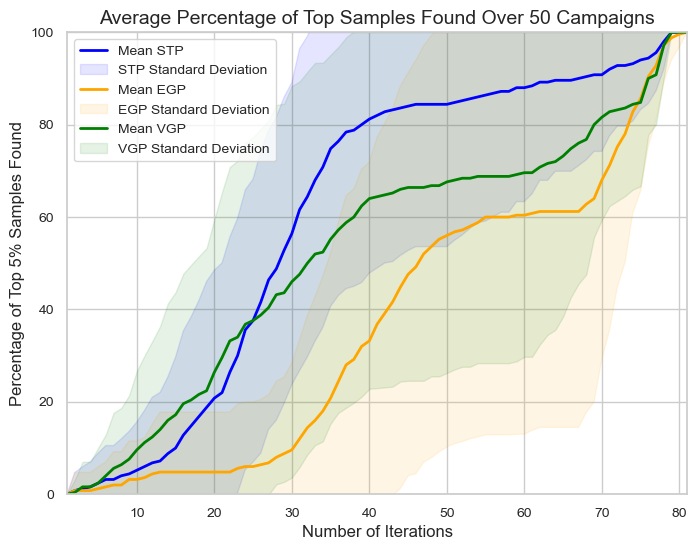

Starting P3HT
Number of samples: 230
Number of of top 5% samples: 12
Top 5% samples: [1243.67, 1089.12, 904.29, 852.33, 839.28, 838.31, 824.47, 804.11, 800.58, 788.8326479, 772.94, 770.35]


  0%|          | 0/50 [00:00<?, ?it/s]

Maximizing with STP
Seed: 654
Initial points: tensor([[4.5410e+01, 4.8510e+01, 2.1000e+00, 2.6400e+00, 1.3800e+00],
        [4.9580e+01, 4.5420e+01, 8.9000e-01, 2.2500e+00, 1.9300e+00],
        [8.3170e+01, 1.7200e+00, 3.5400e+00, 2.4300e+00, 9.0700e+00],
        [7.4190e+01, 7.0000e-02, 2.4760e+01, 1.7000e-01, 8.0000e-01],
        [3.7290e+01, 4.3200e+01, 2.7700e+00, 1.8100e+00, 1.4940e+01]],
       dtype=torch.float64)


  2%|▏         | 1/50 [03:07<2:33:23, 187.83s/it]

Iterations 223
Maximizing with STP
Seed: 114
Initial points: tensor([[2.0570e+01, 1.8000e-01, 3.5600e+01, 3.9410e+01, 4.1600e+00],
        [3.9050e+01, 4.1850e+01, 5.7500e+00, 4.0400e+00, 9.4000e+00],
        [4.0020e+01, 4.1490e+01, 8.0000e-02, 1.3950e+01, 4.5600e+00],
        [4.0670e+01, 5.9260e+01, 4.0000e-02, 4.0000e-02, 7.0000e-02],
        [4.2440e+01, 1.1100e+00, 1.4900e+00, 5.4040e+01, 9.5000e-01]],
       dtype=torch.float64)


  4%|▍         | 2/50 [06:02<2:24:08, 180.17s/it]

Iterations 216
Maximizing with STP
Seed: 25
Initial points: tensor([[50.7400, 41.0500,  1.6500,  4.6900,  1.8700],
        [83.1700,  1.7200,  3.5400,  2.4300,  9.0700],
        [84.0100,  2.4900,  0.6700,  4.7100,  8.1100],
        [54.4800,  0.6500,  0.5300,  0.4600, 43.8900],
        [84.5500,  1.9300,  1.4000,  3.2300,  8.8500]], dtype=torch.float64)


  6%|▌         | 3/50 [09:04<2:21:44, 180.95s/it]

Iterations 220
Maximizing with STP
Seed: 759
Initial points: tensor([[5.3660e+01, 3.8510e+01, 1.5700e+00, 4.7500e+00, 1.5800e+00],
        [4.7090e+01, 3.5560e+01, 5.7900e+00, 5.4700e+00, 6.1700e+00],
        [3.7690e+01, 4.3160e+01, 4.1400e+00, 6.2200e+00, 8.8000e+00],
        [4.1640e+01, 6.0000e-01, 5.9000e-01, 5.4700e+01, 2.4800e+00],
        [7.4190e+01, 7.0000e-02, 2.4760e+01, 1.7000e-01, 8.0000e-01]],
       dtype=torch.float64)


  8%|▊         | 4/50 [12:08<2:19:34, 182.06s/it]

Iterations 223
Maximizing with STP
Seed: 281
Initial points: tensor([[84.2300,  1.0600,  1.1300,  4.3400,  9.1500],
        [44.5700, 48.4700,  2.9300,  1.6000,  2.4000],
        [47.1300, 46.9500,  4.2800,  1.0800,  0.5700],
        [84.5500,  1.9300,  1.4000,  3.2300,  8.8500],
        [51.8350, 43.8050,  1.8800,  1.3800,  1.1300]], dtype=torch.float64)


 10%|█         | 5/50 [15:10<2:16:36, 182.14s/it]

Iterations 223
Maximizing with STP
Seed: 250
Initial points: tensor([[3.8920e+01, 4.9280e+01, 9.0000e-02, 9.5000e-01, 1.0670e+01],
        [4.5600e+01, 4.6500e+01, 1.6700e+00, 3.9600e+00, 2.2600e+00],
        [8.4010e+01, 2.4900e+00, 6.7000e-01, 4.7100e+00, 8.1100e+00],
        [8.4550e+01, 1.9300e+00, 1.4000e+00, 3.2300e+00, 8.8500e+00],
        [5.5340e+01, 3.8120e+01, 6.2700e+00, 1.0000e-02, 2.6000e-01]],
       dtype=torch.float64)


 12%|█▏        | 6/50 [18:13<2:13:40, 182.29s/it]

Iterations 224
Maximizing with STP
Seed: 228
Initial points: tensor([[80.2600,  0.5300, 12.0300,  5.4700,  1.7800],
        [84.0100,  2.4900,  0.6700,  4.7100,  8.1100],
        [46.0500, 49.9000,  2.2200,  0.7700,  1.0900],
        [50.6400, 48.2900,  0.2300,  0.4400,  0.4100],
        [51.8350, 43.8050,  1.8800,  1.3800,  1.1300]], dtype=torch.float64)


 14%|█▍        | 7/50 [21:13<2:10:08, 181.60s/it]

Iterations 222
Maximizing with STP
Seed: 142
Initial points: tensor([[4.9720e+01, 4.8060e+01, 1.1100e+00, 8.9000e-01, 2.3000e-01],
        [6.8110e+01, 2.8690e+01, 8.9000e-01, 9.7000e-01, 1.3500e+00],
        [6.0000e+01, 0.0000e+00, 0.0000e+00, 4.0000e+01, 0.0000e+00],
        [4.1900e+01, 4.8610e+01, 3.7800e+00, 1.8700e+00, 3.8300e+00],
        [7.3990e+01, 5.0000e-01, 2.5180e+01, 2.8000e-01, 4.0000e-02]],
       dtype=torch.float64)


 16%|█▌        | 8/50 [24:15<2:07:18, 181.87s/it]

Iterations 224
Maximizing with STP
Seed: 754
Initial points: tensor([[55.0000,  0.0000,  0.0000,  0.0000, 45.0000],
        [88.4500,  3.5000,  1.8900,  1.9600,  4.2100],
        [84.5500,  1.9300,  1.4000,  3.2300,  8.8500],
        [51.8350, 43.8050,  1.8800,  1.3800,  1.1300],
        [45.4100, 48.5100,  2.1000,  2.6400,  1.3800]], dtype=torch.float64)


 18%|█▊        | 9/50 [27:17<2:04:13, 181.80s/it]

Iterations 225
Maximizing with STP
Seed: 104
Initial points: tensor([[4.1900e+01, 4.8610e+01, 3.7800e+00, 1.8700e+00, 3.8300e+00],
        [4.1600e+01, 5.1430e+01, 2.1000e+00, 4.9100e+00, 4.0000e-02],
        [4.5000e+01, 0.0000e+00, 5.5000e+01, 0.0000e+00, 0.0000e+00],
        [6.9100e+01, 3.0830e+01, 4.0000e-02, 4.0000e-02, 4.0000e-02],
        [4.4750e+01, 5.2920e+01, 2.1000e-01, 1.3200e+00, 8.4000e-01]],
       dtype=torch.float64)


 20%|██        | 10/50 [30:17<2:00:55, 181.39s/it]

Iterations 220
Maximizing with STP
Seed: 692
Initial points: tensor([[4.3130e+01, 4.9300e+01, 3.1600e+00, 1.7200e+00, 2.7400e+00],
        [3.8920e+01, 4.9280e+01, 9.0000e-02, 9.5000e-01, 1.0670e+01],
        [4.1630e+01, 4.5990e+01, 8.1700e+00, 4.0000e-02, 4.2400e+00],
        [9.3870e+01, 2.4000e-01, 5.6000e-01, 2.4000e-01, 5.1100e+00],
        [4.2330e+01, 5.1830e+01, 2.7500e+00, 2.8700e+00, 3.2000e-01]],
       dtype=torch.float64)


 22%|██▏       | 11/50 [33:19<1:57:55, 181.43s/it]

Iterations 220
Maximizing with STP
Seed: 758
Initial points: tensor([[4.3800e+01, 4.5290e+01, 7.8900e+00, 2.4300e+00, 5.5000e-01],
        [8.0260e+01, 5.3000e-01, 1.2030e+01, 5.4700e+00, 1.7800e+00],
        [4.6860e+01, 4.3740e+01, 5.0800e+00, 7.8000e-01, 3.6100e+00],
        [4.0670e+01, 5.9260e+01, 4.0000e-02, 4.0000e-02, 7.0000e-02],
        [8.4550e+01, 1.9300e+00, 1.4000e+00, 3.2300e+00, 8.8500e+00]],
       dtype=torch.float64)


 24%|██▍       | 12/50 [36:18<1:54:26, 180.69s/it]

Iterations 218
Maximizing with STP
Seed: 913
Initial points: tensor([[5.3400e+01, 3.3900e+01, 1.1800e+00, 1.1340e+01, 2.5000e-01],
        [8.4550e+01, 1.9300e+00, 1.4000e+00, 3.2300e+00, 8.8500e+00],
        [4.3800e+01, 4.5290e+01, 7.8900e+00, 2.4300e+00, 5.5000e-01],
        [5.8760e+01, 3.9810e+01, 7.5000e-01, 1.5000e-01, 5.3000e-01],
        [4.8970e+01, 5.0340e+01, 4.0000e-02, 1.0000e-01, 5.6000e-01]],
       dtype=torch.float64)


 26%|██▌       | 13/50 [38:59<1:47:49, 174.84s/it]

Iterations 199
Maximizing with STP
Seed: 558
Initial points: tensor([[6.7100e+01, 3.0150e+01, 7.2000e-01, 4.0000e-02, 1.9500e+00],
        [5.4140e+01, 4.0570e+01, 4.0000e-02, 2.6800e+00, 2.6100e+00],
        [5.5340e+01, 3.8120e+01, 6.2700e+00, 1.0000e-02, 2.6000e-01],
        [8.8620e+01, 3.0000e-01, 3.4000e-01, 9.6400e+00, 1.1100e+00],
        [4.4890e+01, 4.7030e+01, 3.8100e+00, 1.1600e+00, 3.1000e+00]],
       dtype=torch.float64)


 28%|██▊       | 14/50 [41:40<1:42:18, 170.51s/it]

Iterations 200
Maximizing with STP
Seed: 89
Initial points: tensor([[9.0310e+01, 1.8000e-01, 6.2000e-01, 8.2500e+00, 6.5000e-01],
        [4.2330e+01, 5.1830e+01, 2.7500e+00, 2.8700e+00, 3.2000e-01],
        [5.3660e+01, 3.8510e+01, 1.5700e+00, 4.7500e+00, 1.5800e+00],
        [5.4140e+01, 4.0570e+01, 4.0000e-02, 2.6800e+00, 2.6100e+00],
        [4.4800e+01, 3.7400e+01, 6.8100e+00, 5.8300e+00, 5.1800e+00]],
       dtype=torch.float64)


 30%|███       | 15/50 [44:35<1:40:18, 171.94s/it]

Iterations 217
Maximizing with STP
Seed: 604
Initial points: tensor([[4.4300e+01, 5.4680e+01, 4.0000e-02, 2.9000e-01, 7.8000e-01],
        [9.2370e+01, 4.5000e-01, 1.8400e+00, 5.1000e-01, 4.8500e+00],
        [4.4570e+01, 4.8470e+01, 2.9300e+00, 1.6000e+00, 2.4000e+00],
        [4.5210e+01, 4.9390e+01, 3.5900e+00, 1.4500e+00, 4.1000e-01],
        [4.4570e+01, 4.8470e+01, 2.9300e+00, 1.6000e+00, 2.4000e+00]],
       dtype=torch.float64)


 32%|███▏      | 16/50 [47:40<1:39:36, 175.79s/it]

Iterations 225
Maximizing with STP
Seed: 432
Initial points: tensor([[4.8680e+01, 3.9720e+01, 1.0970e+01, 5.8000e-01, 4.0000e-02],
        [8.4860e+01, 3.4200e+00, 9.6000e-01, 2.8000e-01, 1.0410e+01],
        [5.0640e+01, 4.8290e+01, 2.3000e-01, 4.4000e-01, 4.1000e-01],
        [4.5640e+01, 4.8860e+01, 2.6400e+00, 1.7800e+00, 1.0900e+00],
        [4.7260e+01, 4.4460e+01, 7.3200e+00, 6.9000e-01, 2.3000e-01]],
       dtype=torch.float64)


 34%|███▍      | 17/50 [50:40<1:37:25, 177.14s/it]

Iterations 218
Maximizing with STP
Seed: 32
Initial points: tensor([[4.5150e+01, 4.2250e+01, 7.8200e+00, 1.9800e+00, 2.8300e+00],
        [7.4190e+01, 7.0000e-02, 2.4760e+01, 1.7000e-01, 8.0000e-01],
        [3.7690e+01, 4.3160e+01, 4.1400e+00, 6.2200e+00, 8.8000e+00],
        [8.9800e+01, 3.0100e+00, 1.5900e+00, 4.3600e+00, 1.2300e+00],
        [4.7130e+01, 4.6950e+01, 4.2800e+00, 1.0800e+00, 5.7000e-01]],
       dtype=torch.float64)


 36%|███▌      | 18/50 [53:44<1:35:32, 179.13s/it]

Iterations 223
Maximizing with STP
Seed: 30
Initial points: tensor([[5.9980e+01, 3.2340e+01, 5.8000e+00, 1.7100e+00, 6.0000e-02],
        [4.3170e+01, 3.4010e+01, 3.8900e+00, 2.0400e+00, 1.6960e+01],
        [9.6270e+01, 2.7000e-01, 2.0200e+00, 8.5000e-01, 5.1000e-01],
        [8.4550e+01, 1.9300e+00, 1.4000e+00, 3.2300e+00, 8.8500e+00],
        [8.3170e+01, 1.7200e+00, 3.5400e+00, 2.4300e+00, 9.0700e+00]],
       dtype=torch.float64)


 38%|███▊      | 19/50 [56:46<1:32:56, 179.90s/it]

Iterations 220
Maximizing with STP
Seed: 95
Initial points: tensor([[44.0100,  0.0900,  0.9000, 54.7100,  0.3000],
        [90.0000, 10.0000,  0.0000,  0.0000,  0.0000],
        [86.4250,  0.6800,  0.7350,  6.9900,  5.1300],
        [42.4400,  1.1100,  1.4900, 54.0400,  0.9500],
        [84.2300,  1.0600,  1.1300,  4.3400,  9.1500]], dtype=torch.float64)


 40%|████      | 20/50 [59:29<1:27:30, 175.02s/it]

Iterations 206
Maximizing with STP
Seed: 223
Initial points: tensor([[88.4500,  3.5000,  1.8900,  1.9600,  4.2100],
        [90.0000, 10.0000,  0.0000,  0.0000,  0.0000],
        [42.3000, 45.0700,  4.4900,  5.2100,  3.0200],
        [16.1500,  0.4600, 25.3800, 51.4200,  6.5500],
        [80.2600,  0.5300, 12.0300,  5.4700,  1.7800]], dtype=torch.float64)


 42%|████▏     | 21/50 [1:02:30<1:25:27, 176.81s/it]

Iterations 222
Maximizing with STP
Seed: 238
Initial points: tensor([[9.0000e+01, 1.0000e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [6.1930e+01, 3.0520e+01, 7.0500e+00, 2.0000e-01, 3.6000e-01],
        [4.8970e+01, 5.0340e+01, 4.0000e-02, 1.0000e-01, 5.6000e-01],
        [4.7130e+01, 4.6950e+01, 4.2800e+00, 1.0800e+00, 5.7000e-01],
        [4.4010e+01, 9.0000e-02, 9.0000e-01, 5.4710e+01, 3.0000e-01]],
       dtype=torch.float64)


 44%|████▍     | 22/50 [1:05:34<1:23:33, 179.04s/it]

Iterations 225
Maximizing with STP
Seed: 517
Initial points: tensor([[56.5900, 31.3400,  5.4600,  0.9300,  5.7300],
        [91.1300,  1.9900,  1.9500,  2.2400,  2.6900],
        [19.1500,  1.5900, 48.4000, 23.3300,  7.5700],
        [90.0000, 10.0000,  0.0000,  0.0000,  0.0000],
        [43.0900, 47.8500,  3.1400,  3.3000,  2.6700]], dtype=torch.float64)


 46%|████▌     | 23/50 [1:08:37<1:20:59, 180.00s/it]

Iterations 220
Maximizing with STP
Seed: 616
Initial points: tensor([[8.4230e+01, 1.0600e+00, 1.1300e+00, 4.3400e+00, 9.1500e+00],
        [4.3110e+01, 5.3000e-01, 5.3450e+01, 5.1000e-01, 2.3600e+00],
        [4.4610e+01, 4.7530e+01, 2.0500e+00, 3.1700e+00, 2.5800e+00],
        [4.3610e+01, 4.9290e+01, 2.8800e+00, 4.2200e+00, 4.0000e-02],
        [4.5210e+01, 4.9390e+01, 3.5900e+00, 1.4500e+00, 4.1000e-01]],
       dtype=torch.float64)


 48%|████▊     | 24/50 [1:11:34<1:17:39, 179.21s/it]

Iterations 219
Maximizing with STP
Seed: 27
Initial points: tensor([[89.8000,  3.0100,  1.5900,  4.3600,  1.2300],
        [95.0000,  0.0000,  0.0000,  0.0000,  5.0000],
        [58.7600, 39.8100,  0.7500,  0.1500,  0.5300],
        [34.9600, 44.3200,  1.8000, 14.0100,  4.9600],
        [91.1300,  1.9900,  1.9500,  2.2400,  2.6900]], dtype=torch.float64)


 50%|█████     | 25/50 [1:14:33<1:14:37, 179.11s/it]

Iterations 224
Maximizing with STP
Seed: 574
Initial points: tensor([[8.9800e+01, 3.0100e+00, 1.5900e+00, 4.3600e+00, 1.2300e+00],
        [5.0650e+01, 4.4590e+01, 4.0600e+00, 4.0000e-02, 6.9000e-01],
        [2.0570e+01, 1.8000e-01, 3.5600e+01, 3.9410e+01, 4.1600e+00],
        [7.4880e+01, 8.0000e-02, 2.0200e+00, 2.2010e+01, 1.0300e+00],
        [4.6860e+01, 4.3740e+01, 5.0800e+00, 7.8000e-01, 3.6100e+00]],
       dtype=torch.float64)


 52%|█████▏    | 26/50 [1:17:24<1:10:42, 176.78s/it]

Iterations 217
Maximizing with STP
Seed: 203
Initial points: tensor([[36.8800, 41.6000,  2.6700,  1.8500, 16.9900],
        [90.4800,  4.8200,  2.6100,  0.5500,  1.5700],
        [59.8200,  0.2300,  0.5000, 38.8900,  0.5500],
        [47.0900, 35.5600,  5.7900,  5.4700,  6.1700],
        [50.7400, 41.0500,  1.6500,  4.6900,  1.8700]], dtype=torch.float64)


 54%|█████▍    | 27/50 [1:20:24<1:08:06, 177.67s/it]

Iterations 225
Maximizing with STP
Seed: 733
Initial points: tensor([[4.4570e+01, 4.8470e+01, 2.9300e+00, 1.6000e+00, 2.4000e+00],
        [4.4800e+01, 3.7400e+01, 6.8100e+00, 5.8300e+00, 5.1800e+00],
        [6.1930e+01, 3.0520e+01, 7.0500e+00, 2.0000e-01, 3.6000e-01],
        [6.9100e+01, 3.0830e+01, 4.0000e-02, 4.0000e-02, 4.0000e-02],
        [4.9720e+01, 4.8060e+01, 1.1100e+00, 8.9000e-01, 2.3000e-01]],
       dtype=torch.float64)


 56%|█████▌    | 28/50 [1:23:02<1:03:01, 171.90s/it]

Iterations 201
Maximizing with STP
Seed: 665
Initial points: tensor([[7.1640e+01, 2.8160e+01, 4.0000e-02, 1.1000e-01, 5.0000e-02],
        [4.6440e+01, 4.9230e+01, 1.6600e+00, 1.7000e+00, 1.0600e+00],
        [1.9840e+01, 1.0600e+00, 2.8700e+01, 3.3620e+01, 1.6750e+01],
        [6.8110e+01, 2.8690e+01, 8.9000e-01, 9.7000e-01, 1.3500e+00],
        [5.8620e+01, 3.9890e+01, 4.0000e-02, 1.3200e+00, 1.4000e-01]],
       dtype=torch.float64)


 58%|█████▊    | 29/50 [1:26:07<1:01:32, 175.85s/it]

Iterations 225
Maximizing with STP
Seed: 718
Initial points: tensor([[4.0670e+01, 5.9260e+01, 4.0000e-02, 4.0000e-02, 7.0000e-02],
        [5.6590e+01, 3.1340e+01, 5.4600e+00, 9.3000e-01, 5.7300e+00],
        [9.1130e+01, 1.9900e+00, 1.9500e+00, 2.2400e+00, 2.6900e+00],
        [4.7200e+01, 4.9490e+01, 2.0100e+00, 3.1000e-01, 1.0100e+00],
        [3.7690e+01, 4.3160e+01, 4.1400e+00, 6.2200e+00, 8.8000e+00]],
       dtype=torch.float64)


 60%|██████    | 30/50 [1:28:59<58:10, 174.54s/it]  

Iterations 216
Maximizing with STP
Seed: 429
Initial points: tensor([[5.0650e+01, 4.4590e+01, 4.0600e+00, 4.0000e-02, 6.9000e-01],
        [8.8450e+01, 3.5000e+00, 1.8900e+00, 1.9600e+00, 4.2100e+00],
        [4.4890e+01, 4.7030e+01, 3.8100e+00, 1.1600e+00, 3.1000e+00],
        [3.4960e+01, 4.4320e+01, 1.8000e+00, 1.4010e+01, 4.9600e+00],
        [1.5000e+01, 0.0000e+00, 0.0000e+00, 8.5000e+01, 0.0000e+00]],
       dtype=torch.float64)


 62%|██████▏   | 31/50 [1:31:57<55:38, 175.73s/it]

Iterations 217
Maximizing with STP
Seed: 225
Initial points: tensor([[9.0310e+01, 1.8000e-01, 6.2000e-01, 8.2500e+00, 6.5000e-01],
        [4.5640e+01, 4.8860e+01, 2.6400e+00, 1.7800e+00, 1.0900e+00],
        [4.0670e+01, 5.9260e+01, 4.0000e-02, 4.0000e-02, 7.0000e-02],
        [3.8290e+01, 4.7370e+01, 9.5000e-01, 6.0000e-01, 1.2870e+01],
        [3.4010e+01, 3.8900e+01, 7.3000e-01, 1.2680e+01, 1.3650e+01]],
       dtype=torch.float64)


 64%|██████▍   | 32/50 [1:34:57<53:02, 176.79s/it]

Iterations 221
Maximizing with STP
Seed: 459
Initial points: tensor([[4.2330e+01, 5.1830e+01, 2.7500e+00, 2.8700e+00, 3.2000e-01],
        [7.3990e+01, 5.0000e-01, 2.5180e+01, 2.8000e-01, 4.0000e-02],
        [4.8620e+01, 5.0350e+01, 4.9000e-01, 5.3000e-01, 4.0000e-02],
        [8.3170e+01, 1.7200e+00, 3.5400e+00, 2.4300e+00, 9.0700e+00],
        [8.4570e+01, 9.0000e-01, 6.9000e-01, 5.8400e+00, 7.9800e+00]],
       dtype=torch.float64)


 66%|██████▌   | 33/50 [1:37:59<50:33, 178.43s/it]

Iterations 223
Maximizing with STP
Seed: 603
Initial points: tensor([[7.0000e+01, 3.0000e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [4.1630e+01, 4.5990e+01, 8.1700e+00, 4.0000e-02, 4.2400e+00],
        [8.4090e+01, 1.8500e+00, 6.5000e-01, 2.3600e+00, 1.1140e+01],
        [8.4570e+01, 9.0000e-01, 6.9000e-01, 5.8400e+00, 7.9800e+00],
        [4.4350e+01, 1.8000e-01, 5.4470e+01, 1.8000e-01, 8.1000e-01]],
       dtype=torch.float64)


 68%|██████▊   | 34/50 [1:40:56<47:25, 177.86s/it]

Iterations 219
Maximizing with STP
Seed: 284
Initial points: tensor([[4.4890e+01, 4.7030e+01, 3.8100e+00, 1.1600e+00, 3.1000e+00],
        [6.8940e+01, 2.6790e+01, 6.9000e-01, 1.0300e+00, 2.5700e+00],
        [8.4600e+01, 7.5600e+00, 4.0000e-02, 7.8300e+00, 6.0000e-02],
        [4.4570e+01, 4.8470e+01, 2.9300e+00, 1.6000e+00, 2.4000e+00],
        [5.0640e+01, 4.8290e+01, 2.3000e-01, 4.4000e-01, 4.1000e-01]],
       dtype=torch.float64)


 70%|███████   | 35/50 [1:43:54<44:29, 177.95s/it]

Iterations 221
Maximizing with STP
Seed: 828
Initial points: tensor([[19.5200,  1.2400, 46.2100, 25.8600,  7.2300],
        [20.5700,  0.1800, 35.6000, 39.4100,  4.1600],
        [55.3600, 38.3800,  1.1300,  4.1500,  1.0400],
        [40.0000, 60.0000,  0.0000,  0.0000,  0.0000],
        [95.0000,  0.0000,  0.0000,  0.0000,  5.0000]], dtype=torch.float64)


 72%|███████▏  | 36/50 [1:46:50<41:24, 177.46s/it]

Iterations 222
Maximizing with STP
Seed: 890
Initial points: tensor([[51.8100, 39.1000,  5.1500,  0.7800,  3.1400],
        [51.7300, 32.1200,  3.9200,  2.2900,  9.9600],
        [49.5100, 49.2400,  0.6200,  0.1200,  0.5600],
        [41.9000, 48.6100,  3.7800,  1.8700,  3.8300],
        [92.3700,  0.4500,  1.8400,  0.5100,  4.8500]], dtype=torch.float64)


 74%|███████▍  | 37/50 [1:49:40<37:57, 175.21s/it]

Iterations 212
Maximizing with STP
Seed: 6
Initial points: tensor([[8.8450e+01, 3.5000e+00, 1.8900e+00, 1.9600e+00, 4.2100e+00],
        [7.1640e+01, 2.8160e+01, 4.0000e-02, 1.1000e-01, 5.0000e-02],
        [1.8740e+01, 1.7000e-01, 1.8410e+01, 3.6130e+01, 2.6580e+01],
        [3.9050e+01, 4.1850e+01, 5.7500e+00, 4.0400e+00, 9.4000e+00],
        [4.8970e+01, 5.0340e+01, 4.0000e-02, 1.0000e-01, 5.6000e-01]],
       dtype=torch.float64)


 76%|███████▌  | 38/50 [1:52:36<35:07, 175.58s/it]

Iterations 222
Maximizing with STP
Seed: 777
Initial points: tensor([[4.7200e+01, 4.9490e+01, 2.0100e+00, 3.1000e-01, 1.0100e+00],
        [4.2440e+01, 1.1100e+00, 1.4900e+00, 5.4040e+01, 9.5000e-01],
        [7.7730e+01, 2.0640e+01, 1.5800e+00, 4.0000e-02, 4.0000e-02],
        [4.4800e+01, 3.7400e+01, 6.8100e+00, 5.8300e+00, 5.1800e+00],
        [1.8670e+01, 2.7000e-01, 4.7090e+01, 2.4030e+01, 9.9900e+00]],
       dtype=torch.float64)


 78%|███████▊  | 39/50 [1:55:37<32:28, 177.18s/it]

Iterations 225
Maximizing with STP
Seed: 825
Initial points: tensor([[5.8550e+01, 3.7360e+01, 1.9200e+00, 8.7000e-01, 1.2700e+00],
        [8.7890e+01, 2.0000e+00, 6.2600e+00, 2.4200e+00, 1.3300e+00],
        [1.9130e+01, 4.0000e-01, 4.6860e+01, 2.5410e+01, 8.2500e+00],
        [5.1730e+01, 3.2120e+01, 3.9200e+00, 2.2900e+00, 9.9600e+00],
        [7.1640e+01, 2.8160e+01, 4.0000e-02, 1.1000e-01, 5.0000e-02]],
       dtype=torch.float64)


 80%|████████  | 40/50 [1:58:32<29:25, 176.50s/it]

Iterations 218
Maximizing with STP
Seed: 163
Initial points: tensor([[4.5210e+01, 4.9390e+01, 3.5900e+00, 1.4500e+00, 4.1000e-01],
        [1.8740e+01, 1.7000e-01, 1.8410e+01, 3.6130e+01, 2.6580e+01],
        [4.1630e+01, 4.5990e+01, 8.1700e+00, 4.0000e-02, 4.2400e+00],
        [5.8620e+01, 3.9890e+01, 4.0000e-02, 1.3200e+00, 1.4000e-01],
        [9.1130e+01, 1.9900e+00, 1.9500e+00, 2.2400e+00, 2.6900e+00]],
       dtype=torch.float64)


 82%|████████▏ | 41/50 [2:01:30<26:32, 176.92s/it]

Iterations 222
Maximizing with STP
Seed: 714
Initial points: tensor([[46.8600, 43.7400,  5.0800,  0.7800,  3.6100],
        [74.8800,  0.0800,  2.0200, 22.0100,  1.0300],
        [40.0000, 60.0000,  0.0000,  0.0000,  0.0000],
        [19.1300,  0.4000, 46.8600, 25.4100,  8.2500],
        [34.0100, 38.9000,  0.7300, 12.6800, 13.6500]], dtype=torch.float64)


 84%|████████▍ | 42/50 [2:04:21<23:20, 175.04s/it]

Iterations 214
Maximizing with STP
Seed: 348
Initial points: tensor([[4.4570e+01, 4.8470e+01, 2.9300e+00, 1.6000e+00, 2.4000e+00],
        [4.4010e+01, 9.0000e-02, 9.0000e-01, 5.4710e+01, 3.0000e-01],
        [5.5340e+01, 3.8120e+01, 6.2700e+00, 1.0000e-02, 2.6000e-01],
        [8.3550e+01, 5.8000e-01, 3.0900e+00, 7.0100e+00, 5.7400e+00],
        [4.9720e+01, 4.8060e+01, 1.1100e+00, 8.9000e-01, 2.3000e-01]],
       dtype=torch.float64)


 86%|████████▌ | 43/50 [2:07:17<20:28, 175.49s/it]

Iterations 219
Maximizing with STP
Seed: 159
Initial points: tensor([[4.7490e+01, 5.0270e+01, 1.4700e+00, 6.5000e-01, 1.6000e-01],
        [4.2330e+01, 5.1830e+01, 2.7500e+00, 2.8700e+00, 3.2000e-01],
        [5.0000e+01, 5.0000e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [7.1640e+01, 2.8160e+01, 4.0000e-02, 1.1000e-01, 5.0000e-02],
        [5.4140e+01, 4.0570e+01, 4.0000e-02, 2.6800e+00, 2.6100e+00]],
       dtype=torch.float64)


 88%|████████▊ | 44/50 [2:10:37<18:16, 182.70s/it]

Iterations 225
Maximizing with STP
Seed: 220
Initial points: tensor([[6.6030e+01, 3.0010e+01, 2.6100e+00, 2.4000e-01, 1.0800e+00],
        [5.3990e+01, 4.4580e+01, 4.0000e-02, 5.4000e-01, 8.9000e-01],
        [4.9400e+01, 4.9480e+01, 5.4000e-01, 3.8000e-01, 2.1000e-01],
        [5.8550e+01, 3.7360e+01, 1.9200e+00, 8.7000e-01, 1.2700e+00],
        [4.0000e+01, 6.0000e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00]],
       dtype=torch.float64)


 90%|█████████ | 45/50 [2:13:38<15:11, 182.23s/it]

Iterations 217
Maximizing with STP
Seed: 980
Initial points: tensor([[44.8000, 37.4000,  6.8100,  5.8300,  5.1800],
        [50.3500, 40.6000,  5.3700,  2.4400,  1.2600],
        [90.4800,  4.8200,  2.6100,  0.5500,  1.5700],
        [42.4400,  1.1100,  1.4900, 54.0400,  0.9500],
        [84.8600,  3.4200,  0.9600,  0.2800, 10.4100]], dtype=torch.float64)


 92%|█████████▏| 46/50 [2:16:43<12:12, 183.22s/it]

Iterations 222
Maximizing with STP
Seed: 781
Initial points: tensor([[5.4140e+01, 4.0570e+01, 4.0000e-02, 2.6800e+00, 2.6100e+00],
        [3.4130e+01, 4.2190e+01, 8.7900e+00, 1.3220e+01, 1.6900e+00],
        [4.6570e+01, 4.8910e+01, 3.0800e+00, 1.1100e+00, 3.6000e-01],
        [1.5000e+01, 0.0000e+00, 0.0000e+00, 8.5000e+01, 0.0000e+00],
        [4.4350e+01, 1.8000e-01, 5.4470e+01, 1.8000e-01, 8.1000e-01]],
       dtype=torch.float64)


 94%|█████████▍| 47/50 [2:19:53<09:15, 185.17s/it]

Iterations 225
Maximizing with STP
Seed: 344
Initial points: tensor([[4.6860e+01, 4.3740e+01, 5.0800e+00, 7.8000e-01, 3.6100e+00],
        [4.4750e+01, 5.2920e+01, 2.1000e-01, 1.3200e+00, 8.4000e-01],
        [4.0670e+01, 5.9260e+01, 4.0000e-02, 4.0000e-02, 7.0000e-02],
        [4.8720e+01, 4.9780e+01, 4.5000e-01, 8.3000e-01, 2.3000e-01],
        [4.3090e+01, 4.7850e+01, 3.1400e+00, 3.3000e+00, 2.6700e+00]],
       dtype=torch.float64)


 96%|█████████▌| 48/50 [2:23:01<06:12, 186.06s/it]

Iterations 223
Maximizing with STP
Seed: 94
Initial points: tensor([[9.0310e+01, 1.8000e-01, 6.2000e-01, 8.2500e+00, 6.5000e-01],
        [8.4550e+01, 1.9300e+00, 1.4000e+00, 3.2300e+00, 8.8500e+00],
        [4.4010e+01, 9.0000e-02, 9.0000e-01, 5.4710e+01, 3.0000e-01],
        [5.5340e+01, 3.8120e+01, 6.2700e+00, 1.0000e-02, 2.6000e-01],
        [4.4890e+01, 4.7030e+01, 3.8100e+00, 1.1600e+00, 3.1000e+00]],
       dtype=torch.float64)


 98%|█████████▊| 49/50 [2:26:07<03:06, 186.05s/it]

Iterations 225
Maximizing with STP
Seed: 389
Initial points: tensor([[3.8290e+01, 4.7370e+01, 9.5000e-01, 6.0000e-01, 1.2870e+01],
        [5.9980e+01, 3.2340e+01, 5.8000e+00, 1.7100e+00, 6.0000e-02],
        [1.9150e+01, 1.5900e+00, 4.8400e+01, 2.3330e+01, 7.5700e+00],
        [4.8680e+01, 3.9720e+01, 1.0970e+01, 5.8000e-01, 4.0000e-02],
        [4.4890e+01, 4.7030e+01, 3.8100e+00, 1.1600e+00, 3.1000e+00]],
       dtype=torch.float64)


100%|██████████| 50/50 [2:29:13<00:00, 179.06s/it]


Iterations 222


  0%|          | 0/50 [00:00<?, ?it/s]

Maximizing with EGP
Seed: 654
Initial points: tensor([[4.5410e+01, 4.8510e+01, 2.1000e+00, 2.6400e+00, 1.3800e+00],
        [4.9580e+01, 4.5420e+01, 8.9000e-01, 2.2500e+00, 1.9300e+00],
        [8.3170e+01, 1.7200e+00, 3.5400e+00, 2.4300e+00, 9.0700e+00],
        [7.4190e+01, 7.0000e-02, 2.4760e+01, 1.7000e-01, 8.0000e-01],
        [3.7290e+01, 4.3200e+01, 2.7700e+00, 1.8100e+00, 1.4940e+01]],
       dtype=torch.float64)


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-07 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils

Iterations 225
Maximizing with EGP
Seed: 114
Initial points: tensor([[2.0570e+01, 1.8000e-01, 3.5600e+01, 3.9410e+01, 4.1600e+00],
        [3.9050e+01, 4.1850e+01, 5.7500e+00, 4.0400e+00, 9.4000e+00],
        [4.0020e+01, 4.1490e+01, 8.0000e-02, 1.3950e+01, 4.5600e+00],
        [4.0670e+01, 5.9260e+01, 4.0000e-02, 4.0000e-02, 7.0000e-02],
        [4.2440e+01, 1.1100e+00, 1.4900e+00, 5.4040e+01, 9.5000e-01]],
       dtype=torch.float64)


  4%|▍         | 2/50 [01:33<37:04, 46.34s/it]

Iterations 218
Maximizing with EGP
Seed: 25
Initial points: tensor([[50.7400, 41.0500,  1.6500,  4.6900,  1.8700],
        [83.1700,  1.7200,  3.5400,  2.4300,  9.0700],
        [84.0100,  2.4900,  0.6700,  4.7100,  8.1100],
        [54.4800,  0.6500,  0.5300,  0.4600, 43.8900],
        [84.5500,  1.9300,  1.4000,  3.2300,  8.8500]], dtype=torch.float64)


  6%|▌         | 3/50 [02:30<40:06, 51.21s/it]

Iterations 225
Maximizing with EGP
Seed: 759
Initial points: tensor([[5.3660e+01, 3.8510e+01, 1.5700e+00, 4.7500e+00, 1.5800e+00],
        [4.7090e+01, 3.5560e+01, 5.7900e+00, 5.4700e+00, 6.1700e+00],
        [3.7690e+01, 4.3160e+01, 4.1400e+00, 6.2200e+00, 8.8000e+00],
        [4.1640e+01, 6.0000e-01, 5.9000e-01, 5.4700e+01, 2.4800e+00],
        [7.4190e+01, 7.0000e-02, 2.4760e+01, 1.7000e-01, 8.0000e-01]],
       dtype=torch.float64)


  8%|▊         | 4/50 [03:21<39:03, 50.95s/it]

Iterations 225
Maximizing with EGP
Seed: 281
Initial points: tensor([[84.2300,  1.0600,  1.1300,  4.3400,  9.1500],
        [44.5700, 48.4700,  2.9300,  1.6000,  2.4000],
        [47.1300, 46.9500,  4.2800,  1.0800,  0.5700],
        [84.5500,  1.9300,  1.4000,  3.2300,  8.8500],
        [51.8350, 43.8050,  1.8800,  1.3800,  1.1300]], dtype=torch.float64)


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
 10%|█         | 5/50 [04:11<37:54, 50.54s/it]

Iterations 224
Maximizing with EGP
Seed: 250
Initial points: tensor([[3.8920e+01, 4.9280e+01, 9.0000e-02, 9.5000e-01, 1.0670e+01],
        [4.5600e+01, 4.6500e+01, 1.6700e+00, 3.9600e+00, 2.2600e+00],
        [8.4010e+01, 2.4900e+00, 6.7000e-01, 4.7100e+00, 8.1100e+00],
        [8.4550e+01, 1.9300e+00, 1.4000e+00, 3.2300e+00, 8.8500e+00],
        [5.5340e+01, 3.8120e+01, 6.2700e+00, 1.0000e-02, 2.6000e-01]],
       dtype=torch.float64)


 12%|█▏        | 6/50 [04:58<36:15, 49.44s/it]

Iterations 225
Maximizing with EGP
Seed: 228
Initial points: tensor([[80.2600,  0.5300, 12.0300,  5.4700,  1.7800],
        [84.0100,  2.4900,  0.6700,  4.7100,  8.1100],
        [46.0500, 49.9000,  2.2200,  0.7700,  1.0900],
        [50.6400, 48.2900,  0.2300,  0.4400,  0.4100],
        [51.8350, 43.8050,  1.8800,  1.3800,  1.1300]], dtype=torch.float64)


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
 14%|█▍        | 7/50 [05:49<35:43, 49.85s/it]

Iterations 225
Maximizing with EGP
Seed: 142
Initial points: tensor([[4.9720e+01, 4.8060e+01, 1.1100e+00, 8.9000e-01, 2.3000e-01],
        [6.8110e+01, 2.8690e+01, 8.9000e-01, 9.7000e-01, 1.3500e+00],
        [6.0000e+01, 0.0000e+00, 0.0000e+00, 4.0000e+01, 0.0000e+00],
        [4.1900e+01, 4.8610e+01, 3.7800e+00, 1.8700e+00, 3.8300e+00],
        [7.3990e+01, 5.0000e-01, 2.5180e+01, 2.8000e-01, 4.0000e-02]],
       dtype=torch.float64)


 16%|█▌        | 8/50 [06:36<34:22, 49.10s/it]

Iterations 225
Maximizing with EGP
Seed: 754
Initial points: tensor([[55.0000,  0.0000,  0.0000,  0.0000, 45.0000],
        [88.4500,  3.5000,  1.8900,  1.9600,  4.2100],
        [84.5500,  1.9300,  1.4000,  3.2300,  8.8500],
        [51.8350, 43.8050,  1.8800,  1.3800,  1.1300],
        [45.4100, 48.5100,  2.1000,  2.6400,  1.3800]], dtype=torch.float64)


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
 18%|█▊        | 9/50 [07:27<33:55, 49.65s/it]

Iterations 225
Maximizing with EGP
Seed: 104
Initial points: tensor([[4.1900e+01, 4.8610e+01, 3.7800e+00, 1.8700e+00, 3.8300e+00],
        [4.1600e+01, 5.1430e+01, 2.1000e+00, 4.9100e+00, 4.0000e-02],
        [4.5000e+01, 0.0000e+00, 5.5000e+01, 0.0000e+00, 0.0000e+00],
        [6.9100e+01, 3.0830e+01, 4.0000e-02, 4.0000e-02, 4.0000e-02],
        [4.4750e+01, 5.2920e+01, 2.1000e-01, 1.3200e+00, 8.4000e-01]],
       dtype=torch.float64)


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-07 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnin

Iterations 225
Maximizing with EGP
Seed: 692
Initial points: tensor([[4.3130e+01, 4.9300e+01, 3.1600e+00, 1.7200e+00, 2.7400e+00],
        [3.8920e+01, 4.9280e+01, 9.0000e-02, 9.5000e-01, 1.0670e+01],
        [4.1630e+01, 4.5990e+01, 8.1700e+00, 4.0000e-02, 4.2400e+00],
        [9.3870e+01, 2.4000e-01, 5.6000e-01, 2.4000e-01, 5.1100e+00],
        [4.2330e+01, 5.1830e+01, 2.7500e+00, 2.8700e+00, 3.2000e-01]],
       dtype=torch.float64)


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\gpytorch\distributions\multivariate_normal.py:319: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-07 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.wa

Iterations 225
Maximizing with EGP
Seed: 758
Initial points: tensor([[4.3800e+01, 4.5290e+01, 7.8900e+00, 2.4300e+00, 5.5000e-01],
        [8.0260e+01, 5.3000e-01, 1.2030e+01, 5.4700e+00, 1.7800e+00],
        [4.6860e+01, 4.3740e+01, 5.0800e+00, 7.8000e-01, 3.6100e+00],
        [4.0670e+01, 5.9260e+01, 4.0000e-02, 4.0000e-02, 7.0000e-02],
        [8.4550e+01, 1.9300e+00, 1.4000e+00, 3.2300e+00, 8.8500e+00]],
       dtype=torch.float64)


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
 24%|██▍       | 12/50 [09:58<31:07, 49.15s/it]

Iterations 224
Maximizing with EGP
Seed: 913
Initial points: tensor([[5.3400e+01, 3.3900e+01, 1.1800e+00, 1.1340e+01, 2.5000e-01],
        [8.4550e+01, 1.9300e+00, 1.4000e+00, 3.2300e+00, 8.8500e+00],
        [4.3800e+01, 4.5290e+01, 7.8900e+00, 2.4300e+00, 5.5000e-01],
        [5.8760e+01, 3.9810e+01, 7.5000e-01, 1.5000e-01, 5.3000e-01],
        [4.8970e+01, 5.0340e+01, 4.0000e-02, 1.0000e-01, 5.6000e-01]],
       dtype=torch.float64)


 26%|██▌       | 13/50 [10:51<31:06, 50.44s/it]

Iterations 225
Maximizing with EGP
Seed: 558
Initial points: tensor([[6.7100e+01, 3.0150e+01, 7.2000e-01, 4.0000e-02, 1.9500e+00],
        [5.4140e+01, 4.0570e+01, 4.0000e-02, 2.6800e+00, 2.6100e+00],
        [5.5340e+01, 3.8120e+01, 6.2700e+00, 1.0000e-02, 2.6000e-01],
        [8.8620e+01, 3.0000e-01, 3.4000e-01, 9.6400e+00, 1.1100e+00],
        [4.4890e+01, 4.7030e+01, 3.8100e+00, 1.1600e+00, 3.1000e+00]],
       dtype=torch.float64)


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
 28%|██▊       | 14/50 [11:39<29:53, 49.83s/it]

Iterations 225
Maximizing with EGP
Seed: 89
Initial points: tensor([[9.0310e+01, 1.8000e-01, 6.2000e-01, 8.2500e+00, 6.5000e-01],
        [4.2330e+01, 5.1830e+01, 2.7500e+00, 2.8700e+00, 3.2000e-01],
        [5.3660e+01, 3.8510e+01, 1.5700e+00, 4.7500e+00, 1.5800e+00],
        [5.4140e+01, 4.0570e+01, 4.0000e-02, 2.6800e+00, 2.6100e+00],
        [4.4800e+01, 3.7400e+01, 6.8100e+00, 5.8300e+00, 5.1800e+00]],
       dtype=torch.float64)


 30%|███       | 15/50 [12:26<28:27, 48.78s/it]

Iterations 225
Maximizing with EGP
Seed: 604
Initial points: tensor([[4.4300e+01, 5.4680e+01, 4.0000e-02, 2.9000e-01, 7.8000e-01],
        [9.2370e+01, 4.5000e-01, 1.8400e+00, 5.1000e-01, 4.8500e+00],
        [4.4570e+01, 4.8470e+01, 2.9300e+00, 1.6000e+00, 2.4000e+00],
        [4.5210e+01, 4.9390e+01, 3.5900e+00, 1.4500e+00, 4.1000e-01],
        [4.4570e+01, 4.8470e+01, 2.9300e+00, 1.6000e+00, 2.4000e+00]],
       dtype=torch.float64)


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\gpytorch\distributions\multivariate_normal.py:319: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-07 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.p

Iterations 225
Maximizing with EGP
Seed: 432
Initial points: tensor([[4.8680e+01, 3.9720e+01, 1.0970e+01, 5.8000e-01, 4.0000e-02],
        [8.4860e+01, 3.4200e+00, 9.6000e-01, 2.8000e-01, 1.0410e+01],
        [5.0640e+01, 4.8290e+01, 2.3000e-01, 4.4000e-01, 4.1000e-01],
        [4.5640e+01, 4.8860e+01, 2.6400e+00, 1.7800e+00, 1.0900e+00],
        [4.7260e+01, 4.4460e+01, 7.3200e+00, 6.9000e-01, 2.3000e-01]],
       dtype=torch.float64)


 34%|███▍      | 17/50 [14:13<27:59, 50.89s/it]

Iterations 225
Maximizing with EGP
Seed: 32
Initial points: tensor([[4.5150e+01, 4.2250e+01, 7.8200e+00, 1.9800e+00, 2.8300e+00],
        [7.4190e+01, 7.0000e-02, 2.4760e+01, 1.7000e-01, 8.0000e-01],
        [3.7690e+01, 4.3160e+01, 4.1400e+00, 6.2200e+00, 8.8000e+00],
        [8.9800e+01, 3.0100e+00, 1.5900e+00, 4.3600e+00, 1.2300e+00],
        [4.7130e+01, 4.6950e+01, 4.2800e+00, 1.0800e+00, 5.7000e-01]],
       dtype=torch.float64)


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-07 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\chole

Iterations 225
Maximizing with EGP
Seed: 30
Initial points: tensor([[5.9980e+01, 3.2340e+01, 5.8000e+00, 1.7100e+00, 6.0000e-02],
        [4.3170e+01, 3.4010e+01, 3.8900e+00, 2.0400e+00, 1.6960e+01],
        [9.6270e+01, 2.7000e-01, 2.0200e+00, 8.5000e-01, 5.1000e-01],
        [8.4550e+01, 1.9300e+00, 1.4000e+00, 3.2300e+00, 8.8500e+00],
        [8.3170e+01, 1.7200e+00, 3.5400e+00, 2.4300e+00, 9.0700e+00]],
       dtype=torch.float64)


 38%|███▊      | 19/50 [15:56<26:41, 51.68s/it]

Iterations 225
Maximizing with EGP
Seed: 95
Initial points: tensor([[44.0100,  0.0900,  0.9000, 54.7100,  0.3000],
        [90.0000, 10.0000,  0.0000,  0.0000,  0.0000],
        [86.4250,  0.6800,  0.7350,  6.9900,  5.1300],
        [42.4400,  1.1100,  1.4900, 54.0400,  0.9500],
        [84.2300,  1.0600,  1.1300,  4.3400,  9.1500]], dtype=torch.float64)


 40%|████      | 20/50 [16:47<25:44, 51.48s/it]

Iterations 225
Maximizing with EGP
Seed: 223
Initial points: tensor([[88.4500,  3.5000,  1.8900,  1.9600,  4.2100],
        [90.0000, 10.0000,  0.0000,  0.0000,  0.0000],
        [42.3000, 45.0700,  4.4900,  5.2100,  3.0200],
        [16.1500,  0.4600, 25.3800, 51.4200,  6.5500],
        [80.2600,  0.5300, 12.0300,  5.4700,  1.7800]], dtype=torch.float64)


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-07 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnin

Iterations 225
Maximizing with EGP
Seed: 238
Initial points: tensor([[9.0000e+01, 1.0000e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [6.1930e+01, 3.0520e+01, 7.0500e+00, 2.0000e-01, 3.6000e-01],
        [4.8970e+01, 5.0340e+01, 4.0000e-02, 1.0000e-01, 5.6000e-01],
        [4.7130e+01, 4.6950e+01, 4.2800e+00, 1.0800e+00, 5.7000e-01],
        [4.4010e+01, 9.0000e-02, 9.0000e-01, 5.4710e+01, 3.0000e-01]],
       dtype=torch.float64)


 44%|████▍     | 22/50 [18:34<24:20, 52.18s/it]

Iterations 224
Maximizing with EGP
Seed: 517
Initial points: tensor([[56.5900, 31.3400,  5.4600,  0.9300,  5.7300],
        [91.1300,  1.9900,  1.9500,  2.2400,  2.6900],
        [19.1500,  1.5900, 48.4000, 23.3300,  7.5700],
        [90.0000, 10.0000,  0.0000,  0.0000,  0.0000],
        [43.0900, 47.8500,  3.1400,  3.3000,  2.6700]], dtype=torch.float64)


 46%|████▌     | 23/50 [19:32<24:16, 53.96s/it]

Iterations 225
Maximizing with EGP
Seed: 616
Initial points: tensor([[8.4230e+01, 1.0600e+00, 1.1300e+00, 4.3400e+00, 9.1500e+00],
        [4.3110e+01, 5.3000e-01, 5.3450e+01, 5.1000e-01, 2.3600e+00],
        [4.4610e+01, 4.7530e+01, 2.0500e+00, 3.1700e+00, 2.5800e+00],
        [4.3610e+01, 4.9290e+01, 2.8800e+00, 4.2200e+00, 4.0000e-02],
        [4.5210e+01, 4.9390e+01, 3.5900e+00, 1.4500e+00, 4.1000e-01]],
       dtype=torch.float64)


 48%|████▊     | 24/50 [20:16<22:05, 50.98s/it]

Iterations 221
Maximizing with EGP
Seed: 27
Initial points: tensor([[89.8000,  3.0100,  1.5900,  4.3600,  1.2300],
        [95.0000,  0.0000,  0.0000,  0.0000,  5.0000],
        [58.7600, 39.8100,  0.7500,  0.1500,  0.5300],
        [34.9600, 44.3200,  1.8000, 14.0100,  4.9600],
        [91.1300,  1.9900,  1.9500,  2.2400,  2.6900]], dtype=torch.float64)


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
 50%|█████     | 25/50 [21:05<21:03, 50.55s/it]

Iterations 225
Maximizing with EGP
Seed: 574
Initial points: tensor([[8.9800e+01, 3.0100e+00, 1.5900e+00, 4.3600e+00, 1.2300e+00],
        [5.0650e+01, 4.4590e+01, 4.0600e+00, 4.0000e-02, 6.9000e-01],
        [2.0570e+01, 1.8000e-01, 3.5600e+01, 3.9410e+01, 4.1600e+00],
        [7.4880e+01, 8.0000e-02, 2.0200e+00, 2.2010e+01, 1.0300e+00],
        [4.6860e+01, 4.3740e+01, 5.0800e+00, 7.8000e-01, 3.6100e+00]],
       dtype=torch.float64)


 52%|█████▏    | 26/50 [22:04<21:09, 52.88s/it]

Iterations 225
Maximizing with EGP
Seed: 203
Initial points: tensor([[36.8800, 41.6000,  2.6700,  1.8500, 16.9900],
        [90.4800,  4.8200,  2.6100,  0.5500,  1.5700],
        [59.8200,  0.2300,  0.5000, 38.8900,  0.5500],
        [47.0900, 35.5600,  5.7900,  5.4700,  6.1700],
        [50.7400, 41.0500,  1.6500,  4.6900,  1.8700]], dtype=torch.float64)


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-07 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
 54%|█████▍    | 27/50 [23:01<20:47, 54.23s/it]

Iterations 225
Maximizing with EGP
Seed: 733
Initial points: tensor([[4.4570e+01, 4.8470e+01, 2.9300e+00, 1.6000e+00, 2.4000e+00],
        [4.4800e+01, 3.7400e+01, 6.8100e+00, 5.8300e+00, 5.1800e+00],
        [6.1930e+01, 3.0520e+01, 7.0500e+00, 2.0000e-01, 3.6000e-01],
        [6.9100e+01, 3.0830e+01, 4.0000e-02, 4.0000e-02, 4.0000e-02],
        [4.9720e+01, 4.8060e+01, 1.1100e+00, 8.9000e-01, 2.3000e-01]],
       dtype=torch.float64)


 56%|█████▌    | 28/50 [23:48<19:04, 52.04s/it]

Iterations 225
Maximizing with EGP
Seed: 665
Initial points: tensor([[7.1640e+01, 2.8160e+01, 4.0000e-02, 1.1000e-01, 5.0000e-02],
        [4.6440e+01, 4.9230e+01, 1.6600e+00, 1.7000e+00, 1.0600e+00],
        [1.9840e+01, 1.0600e+00, 2.8700e+01, 3.3620e+01, 1.6750e+01],
        [6.8110e+01, 2.8690e+01, 8.9000e-01, 9.7000e-01, 1.3500e+00],
        [5.8620e+01, 3.9890e+01, 4.0000e-02, 1.3200e+00, 1.4000e-01]],
       dtype=torch.float64)


 58%|█████▊    | 29/50 [24:39<18:09, 51.90s/it]

Iterations 225
Maximizing with EGP
Seed: 718
Initial points: tensor([[4.0670e+01, 5.9260e+01, 4.0000e-02, 4.0000e-02, 7.0000e-02],
        [5.6590e+01, 3.1340e+01, 5.4600e+00, 9.3000e-01, 5.7300e+00],
        [9.1130e+01, 1.9900e+00, 1.9500e+00, 2.2400e+00, 2.6900e+00],
        [4.7200e+01, 4.9490e+01, 2.0100e+00, 3.1000e-01, 1.0100e+00],
        [3.7690e+01, 4.3160e+01, 4.1400e+00, 6.2200e+00, 8.8000e+00]],
       dtype=torch.float64)


 60%|██████    | 30/50 [25:22<16:22, 49.12s/it]

Iterations 223
Maximizing with EGP
Seed: 429
Initial points: tensor([[5.0650e+01, 4.4590e+01, 4.0600e+00, 4.0000e-02, 6.9000e-01],
        [8.8450e+01, 3.5000e+00, 1.8900e+00, 1.9600e+00, 4.2100e+00],
        [4.4890e+01, 4.7030e+01, 3.8100e+00, 1.1600e+00, 3.1000e+00],
        [3.4960e+01, 4.4320e+01, 1.8000e+00, 1.4010e+01, 4.9600e+00],
        [1.5000e+01, 0.0000e+00, 0.0000e+00, 8.5000e+01, 0.0000e+00]],
       dtype=torch.float64)


 62%|██████▏   | 31/50 [26:17<16:04, 50.76s/it]

Iterations 225
Maximizing with EGP
Seed: 225
Initial points: tensor([[9.0310e+01, 1.8000e-01, 6.2000e-01, 8.2500e+00, 6.5000e-01],
        [4.5640e+01, 4.8860e+01, 2.6400e+00, 1.7800e+00, 1.0900e+00],
        [4.0670e+01, 5.9260e+01, 4.0000e-02, 4.0000e-02, 7.0000e-02],
        [3.8290e+01, 4.7370e+01, 9.5000e-01, 6.0000e-01, 1.2870e+01],
        [3.4010e+01, 3.8900e+01, 7.3000e-01, 1.2680e+01, 1.3650e+01]],
       dtype=torch.float64)


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
 64%|██████▍   | 32/50 [26:59<14:29, 48.29s/it]

Iterations 221
Maximizing with EGP
Seed: 459
Initial points: tensor([[4.2330e+01, 5.1830e+01, 2.7500e+00, 2.8700e+00, 3.2000e-01],
        [7.3990e+01, 5.0000e-01, 2.5180e+01, 2.8000e-01, 4.0000e-02],
        [4.8620e+01, 5.0350e+01, 4.9000e-01, 5.3000e-01, 4.0000e-02],
        [8.3170e+01, 1.7200e+00, 3.5400e+00, 2.4300e+00, 9.0700e+00],
        [8.4570e+01, 9.0000e-01, 6.9000e-01, 5.8400e+00, 7.9800e+00]],
       dtype=torch.float64)


 66%|██████▌   | 33/50 [27:54<14:13, 50.19s/it]

Iterations 225
Maximizing with EGP
Seed: 603
Initial points: tensor([[7.0000e+01, 3.0000e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [4.1630e+01, 4.5990e+01, 8.1700e+00, 4.0000e-02, 4.2400e+00],
        [8.4090e+01, 1.8500e+00, 6.5000e-01, 2.3600e+00, 1.1140e+01],
        [8.4570e+01, 9.0000e-01, 6.9000e-01, 5.8400e+00, 7.9800e+00],
        [4.4350e+01, 1.8000e-01, 5.4470e+01, 1.8000e-01, 8.1000e-01]],
       dtype=torch.float64)


 68%|██████▊   | 34/50 [28:44<13:22, 50.13s/it]

Iterations 224
Maximizing with EGP
Seed: 284
Initial points: tensor([[4.4890e+01, 4.7030e+01, 3.8100e+00, 1.1600e+00, 3.1000e+00],
        [6.8940e+01, 2.6790e+01, 6.9000e-01, 1.0300e+00, 2.5700e+00],
        [8.4600e+01, 7.5600e+00, 4.0000e-02, 7.8300e+00, 6.0000e-02],
        [4.4570e+01, 4.8470e+01, 2.9300e+00, 1.6000e+00, 2.4000e+00],
        [5.0640e+01, 4.8290e+01, 2.3000e-01, 4.4000e-01, 4.1000e-01]],
       dtype=torch.float64)


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\gpytorch\distributions\multivariate_normal.py:319: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\gpytorch\distributions\multivariate_normal.py:319: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\gpytorch\distributions\multivariate_normal.py:319: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original me

Iterations 225
Maximizing with EGP
Seed: 828
Initial points: tensor([[19.5200,  1.2400, 46.2100, 25.8600,  7.2300],
        [20.5700,  0.1800, 35.6000, 39.4100,  4.1600],
        [55.3600, 38.3800,  1.1300,  4.1500,  1.0400],
        [40.0000, 60.0000,  0.0000,  0.0000,  0.0000],
        [95.0000,  0.0000,  0.0000,  0.0000,  5.0000]], dtype=torch.float64)


 72%|███████▏  | 36/50 [30:12<10:55, 46.80s/it]

Iterations 223
Maximizing with EGP
Seed: 890
Initial points: tensor([[51.8100, 39.1000,  5.1500,  0.7800,  3.1400],
        [51.7300, 32.1200,  3.9200,  2.2900,  9.9600],
        [49.5100, 49.2400,  0.6200,  0.1200,  0.5600],
        [41.9000, 48.6100,  3.7800,  1.8700,  3.8300],
        [92.3700,  0.4500,  1.8400,  0.5100,  4.8500]], dtype=torch.float64)


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
 74%|███████▍  | 37/50 [31:01<10:16, 47.40s/it]

Iterations 225
Maximizing with EGP
Seed: 6
Initial points: tensor([[8.8450e+01, 3.5000e+00, 1.8900e+00, 1.9600e+00, 4.2100e+00],
        [7.1640e+01, 2.8160e+01, 4.0000e-02, 1.1000e-01, 5.0000e-02],
        [1.8740e+01, 1.7000e-01, 1.8410e+01, 3.6130e+01, 2.6580e+01],
        [3.9050e+01, 4.1850e+01, 5.7500e+00, 4.0400e+00, 9.4000e+00],
        [4.8970e+01, 5.0340e+01, 4.0000e-02, 1.0000e-01, 5.6000e-01]],
       dtype=torch.float64)


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-07 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils

Iterations 225
Maximizing with EGP
Seed: 777
Initial points: tensor([[4.7200e+01, 4.9490e+01, 2.0100e+00, 3.1000e-01, 1.0100e+00],
        [4.2440e+01, 1.1100e+00, 1.4900e+00, 5.4040e+01, 9.5000e-01],
        [7.7730e+01, 2.0640e+01, 1.5800e+00, 4.0000e-02, 4.0000e-02],
        [4.4800e+01, 3.7400e+01, 6.8100e+00, 5.8300e+00, 5.1800e+00],
        [1.8670e+01, 2.7000e-01, 4.7090e+01, 2.4030e+01, 9.9900e+00]],
       dtype=torch.float64)


 78%|███████▊  | 39/50 [32:37<08:47, 47.92s/it]

Iterations 225
Maximizing with EGP
Seed: 825
Initial points: tensor([[5.8550e+01, 3.7360e+01, 1.9200e+00, 8.7000e-01, 1.2700e+00],
        [8.7890e+01, 2.0000e+00, 6.2600e+00, 2.4200e+00, 1.3300e+00],
        [1.9130e+01, 4.0000e-01, 4.6860e+01, 2.5410e+01, 8.2500e+00],
        [5.1730e+01, 3.2120e+01, 3.9200e+00, 2.2900e+00, 9.9600e+00],
        [7.1640e+01, 2.8160e+01, 4.0000e-02, 1.1000e-01, 5.0000e-02]],
       dtype=torch.float64)


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
 80%|████████  | 40/50 [33:33<08:20, 50.10s/it]

Iterations 225
Maximizing with EGP
Seed: 163
Initial points: tensor([[4.5210e+01, 4.9390e+01, 3.5900e+00, 1.4500e+00, 4.1000e-01],
        [1.8740e+01, 1.7000e-01, 1.8410e+01, 3.6130e+01, 2.6580e+01],
        [4.1630e+01, 4.5990e+01, 8.1700e+00, 4.0000e-02, 4.2400e+00],
        [5.8620e+01, 3.9890e+01, 4.0000e-02, 1.3200e+00, 1.4000e-01],
        [9.1130e+01, 1.9900e+00, 1.9500e+00, 2.2400e+00, 2.6900e+00]],
       dtype=torch.float64)


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-07 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
 82%|████████▏ | 41/50 [34:21<07:26, 49.57s/it]

Iterations 225
Maximizing with EGP
Seed: 714
Initial points: tensor([[46.8600, 43.7400,  5.0800,  0.7800,  3.6100],
        [74.8800,  0.0800,  2.0200, 22.0100,  1.0300],
        [40.0000, 60.0000,  0.0000,  0.0000,  0.0000],
        [19.1300,  0.4000, 46.8600, 25.4100,  8.2500],
        [34.0100, 38.9000,  0.7300, 12.6800, 13.6500]], dtype=torch.float64)


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-07 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils

Iterations 225
Maximizing with EGP
Seed: 348
Initial points: tensor([[4.4570e+01, 4.8470e+01, 2.9300e+00, 1.6000e+00, 2.4000e+00],
        [4.4010e+01, 9.0000e-02, 9.0000e-01, 5.4710e+01, 3.0000e-01],
        [5.5340e+01, 3.8120e+01, 6.2700e+00, 1.0000e-02, 2.6000e-01],
        [8.3550e+01, 5.8000e-01, 3.0900e+00, 7.0100e+00, 5.7400e+00],
        [4.9720e+01, 4.8060e+01, 1.1100e+00, 8.9000e-01, 2.3000e-01]],
       dtype=torch.float64)


 86%|████████▌ | 43/50 [35:57<05:42, 48.90s/it]

Iterations 225
Maximizing with EGP
Seed: 159
Initial points: tensor([[4.7490e+01, 5.0270e+01, 1.4700e+00, 6.5000e-01, 1.6000e-01],
        [4.2330e+01, 5.1830e+01, 2.7500e+00, 2.8700e+00, 3.2000e-01],
        [5.0000e+01, 5.0000e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [7.1640e+01, 2.8160e+01, 4.0000e-02, 1.1000e-01, 5.0000e-02],
        [5.4140e+01, 4.0570e+01, 4.0000e-02, 2.6800e+00, 2.6100e+00]],
       dtype=torch.float64)


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\gpytorch\distributions\multivariate_normal.py:319: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-07 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.wa

Iterations 225
Maximizing with EGP
Seed: 220
Initial points: tensor([[6.6030e+01, 3.0010e+01, 2.6100e+00, 2.4000e-01, 1.0800e+00],
        [5.3990e+01, 4.4580e+01, 4.0000e-02, 5.4000e-01, 8.9000e-01],
        [4.9400e+01, 4.9480e+01, 5.4000e-01, 3.8000e-01, 2.1000e-01],
        [5.8550e+01, 3.7360e+01, 1.9200e+00, 8.7000e-01, 1.2700e+00],
        [4.0000e+01, 6.0000e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00]],
       dtype=torch.float64)


 90%|█████████ | 45/50 [37:32<03:58, 47.70s/it]

Iterations 224
Maximizing with EGP
Seed: 980
Initial points: tensor([[44.8000, 37.4000,  6.8100,  5.8300,  5.1800],
        [50.3500, 40.6000,  5.3700,  2.4400,  1.2600],
        [90.4800,  4.8200,  2.6100,  0.5500,  1.5700],
        [42.4400,  1.1100,  1.4900, 54.0400,  0.9500],
        [84.8600,  3.4200,  0.9600,  0.2800, 10.4100]], dtype=torch.float64)


 92%|█████████▏| 46/50 [38:29<03:21, 50.47s/it]

Iterations 225
Maximizing with EGP
Seed: 781
Initial points: tensor([[5.4140e+01, 4.0570e+01, 4.0000e-02, 2.6800e+00, 2.6100e+00],
        [3.4130e+01, 4.2190e+01, 8.7900e+00, 1.3220e+01, 1.6900e+00],
        [4.6570e+01, 4.8910e+01, 3.0800e+00, 1.1100e+00, 3.6000e-01],
        [1.5000e+01, 0.0000e+00, 0.0000e+00, 8.5000e+01, 0.0000e+00],
        [4.4350e+01, 1.8000e-01, 5.4470e+01, 1.8000e-01, 8.1000e-01]],
       dtype=torch.float64)


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-07 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils

Iterations 225
Maximizing with EGP
Seed: 344
Initial points: tensor([[4.6860e+01, 4.3740e+01, 5.0800e+00, 7.8000e-01, 3.6100e+00],
        [4.4750e+01, 5.2920e+01, 2.1000e-01, 1.3200e+00, 8.4000e-01],
        [4.0670e+01, 5.9260e+01, 4.0000e-02, 4.0000e-02, 7.0000e-02],
        [4.8720e+01, 4.9780e+01, 4.5000e-01, 8.3000e-01, 2.3000e-01],
        [4.3090e+01, 4.7850e+01, 3.1400e+00, 3.3000e+00, 2.6700e+00]],
       dtype=torch.float64)


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
 96%|█████████▌| 48/50 [40:00<01:35, 47.57s/it]

Iterations 219
Maximizing with EGP
Seed: 94
Initial points: tensor([[9.0310e+01, 1.8000e-01, 6.2000e-01, 8.2500e+00, 6.5000e-01],
        [8.4550e+01, 1.9300e+00, 1.4000e+00, 3.2300e+00, 8.8500e+00],
        [4.4010e+01, 9.0000e-02, 9.0000e-01, 5.4710e+01, 3.0000e-01],
        [5.5340e+01, 3.8120e+01, 6.2700e+00, 1.0000e-02, 2.6000e-01],
        [4.4890e+01, 4.7030e+01, 3.8100e+00, 1.1600e+00, 3.1000e+00]],
       dtype=torch.float64)


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-07 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils

Iterations 225
Maximizing with EGP
Seed: 389
Initial points: tensor([[3.8290e+01, 4.7370e+01, 9.5000e-01, 6.0000e-01, 1.2870e+01],
        [5.9980e+01, 3.2340e+01, 5.8000e+00, 1.7100e+00, 6.0000e-02],
        [1.9150e+01, 1.5900e+00, 4.8400e+01, 2.3330e+01, 7.5700e+00],
        [4.8680e+01, 3.9720e+01, 1.0970e+01, 5.8000e-01, 4.0000e-02],
        [4.4890e+01, 4.7030e+01, 3.8100e+00, 1.1600e+00, 3.1000e+00]],
       dtype=torch.float64)


100%|██████████| 50/50 [41:37<00:00, 49.95s/it]


Iterations 225


  0%|          | 0/50 [00:00<?, ?it/s]

Maximizing with VGP
Seed: 654
Initial points: tensor([[4.5410e+01, 4.8510e+01, 2.1000e+00, 2.6400e+00, 1.3800e+00],
        [4.9580e+01, 4.5420e+01, 8.9000e-01, 2.2500e+00, 1.9300e+00],
        [8.3170e+01, 1.7200e+00, 3.5400e+00, 2.4300e+00, 9.0700e+00],
        [7.4190e+01, 7.0000e-02, 2.4760e+01, 1.7000e-01, 8.0000e-01],
        [3.7290e+01, 4.3200e+01, 2.7700e+00, 1.8100e+00, 1.4940e+01]],
       dtype=torch.float64)


  2%|▏         | 1/50 [00:27<22:25, 27.46s/it]

Iterations 124
Maximizing with VGP
Seed: 114
Initial points: tensor([[2.0570e+01, 1.8000e-01, 3.5600e+01, 3.9410e+01, 4.1600e+00],
        [3.9050e+01, 4.1850e+01, 5.7500e+00, 4.0400e+00, 9.4000e+00],
        [4.0020e+01, 4.1490e+01, 8.0000e-02, 1.3950e+01, 4.5600e+00],
        [4.0670e+01, 5.9260e+01, 4.0000e-02, 4.0000e-02, 7.0000e-02],
        [4.2440e+01, 1.1100e+00, 1.4900e+00, 5.4040e+01, 9.5000e-01]],
       dtype=torch.float64)


  4%|▍         | 2/50 [00:51<20:27, 25.58s/it]

Iterations 113
Maximizing with VGP
Seed: 25
Initial points: tensor([[50.7400, 41.0500,  1.6500,  4.6900,  1.8700],
        [83.1700,  1.7200,  3.5400,  2.4300,  9.0700],
        [84.0100,  2.4900,  0.6700,  4.7100,  8.1100],
        [54.4800,  0.6500,  0.5300,  0.4600, 43.8900],
        [84.5500,  1.9300,  1.4000,  3.2300,  8.8500]], dtype=torch.float64)


  6%|▌         | 3/50 [01:26<23:25, 29.91s/it]

Iterations 148
Maximizing with VGP
Seed: 759
Initial points: tensor([[5.3660e+01, 3.8510e+01, 1.5700e+00, 4.7500e+00, 1.5800e+00],
        [4.7090e+01, 3.5560e+01, 5.7900e+00, 5.4700e+00, 6.1700e+00],
        [3.7690e+01, 4.3160e+01, 4.1400e+00, 6.2200e+00, 8.8000e+00],
        [4.1640e+01, 6.0000e-01, 5.9000e-01, 5.4700e+01, 2.4800e+00],
        [7.4190e+01, 7.0000e-02, 2.4760e+01, 1.7000e-01, 8.0000e-01]],
       dtype=torch.float64)


  8%|▊         | 4/50 [01:58<23:27, 30.59s/it]

Iterations 137
Maximizing with VGP
Seed: 281
Initial points: tensor([[84.2300,  1.0600,  1.1300,  4.3400,  9.1500],
        [44.5700, 48.4700,  2.9300,  1.6000,  2.4000],
        [47.1300, 46.9500,  4.2800,  1.0800,  0.5700],
        [84.5500,  1.9300,  1.4000,  3.2300,  8.8500],
        [51.8350, 43.8050,  1.8800,  1.3800,  1.1300]], dtype=torch.float64)


 10%|█         | 5/50 [02:28<22:45, 30.34s/it]

Iterations 132
Maximizing with VGP
Seed: 250
Initial points: tensor([[3.8920e+01, 4.9280e+01, 9.0000e-02, 9.5000e-01, 1.0670e+01],
        [4.5600e+01, 4.6500e+01, 1.6700e+00, 3.9600e+00, 2.2600e+00],
        [8.4010e+01, 2.4900e+00, 6.7000e-01, 4.7100e+00, 8.1100e+00],
        [8.4550e+01, 1.9300e+00, 1.4000e+00, 3.2300e+00, 8.8500e+00],
        [5.5340e+01, 3.8120e+01, 6.2700e+00, 1.0000e-02, 2.6000e-01]],
       dtype=torch.float64)


 12%|█▏        | 6/50 [03:02<23:08, 31.56s/it]

Iterations 144
Maximizing with VGP
Seed: 228
Initial points: tensor([[80.2600,  0.5300, 12.0300,  5.4700,  1.7800],
        [84.0100,  2.4900,  0.6700,  4.7100,  8.1100],
        [46.0500, 49.9000,  2.2200,  0.7700,  1.0900],
        [50.6400, 48.2900,  0.2300,  0.4400,  0.4100],
        [51.8350, 43.8050,  1.8800,  1.3800,  1.1300]], dtype=torch.float64)


 14%|█▍        | 7/50 [03:30<21:55, 30.58s/it]

Iterations 128
Maximizing with VGP
Seed: 142
Initial points: tensor([[4.9720e+01, 4.8060e+01, 1.1100e+00, 8.9000e-01, 2.3000e-01],
        [6.8110e+01, 2.8690e+01, 8.9000e-01, 9.7000e-01, 1.3500e+00],
        [6.0000e+01, 0.0000e+00, 0.0000e+00, 4.0000e+01, 0.0000e+00],
        [4.1900e+01, 4.8610e+01, 3.7800e+00, 1.8700e+00, 3.8300e+00],
        [7.3990e+01, 5.0000e-01, 2.5180e+01, 2.8000e-01, 4.0000e-02]],
       dtype=torch.float64)


 16%|█▌        | 8/50 [04:04<22:12, 31.72s/it]

Iterations 145
Maximizing with VGP
Seed: 754
Initial points: tensor([[55.0000,  0.0000,  0.0000,  0.0000, 45.0000],
        [88.4500,  3.5000,  1.8900,  1.9600,  4.2100],
        [84.5500,  1.9300,  1.4000,  3.2300,  8.8500],
        [51.8350, 43.8050,  1.8800,  1.3800,  1.1300],
        [45.4100, 48.5100,  2.1000,  2.6400,  1.3800]], dtype=torch.float64)


 18%|█▊        | 9/50 [04:34<21:15, 31.10s/it]

Iterations 131
Maximizing with VGP
Seed: 104
Initial points: tensor([[4.1900e+01, 4.8610e+01, 3.7800e+00, 1.8700e+00, 3.8300e+00],
        [4.1600e+01, 5.1430e+01, 2.1000e+00, 4.9100e+00, 4.0000e-02],
        [4.5000e+01, 0.0000e+00, 5.5000e+01, 0.0000e+00, 0.0000e+00],
        [6.9100e+01, 3.0830e+01, 4.0000e-02, 4.0000e-02, 4.0000e-02],
        [4.4750e+01, 5.2920e+01, 2.1000e-01, 1.3200e+00, 8.4000e-01]],
       dtype=torch.float64)


 20%|██        | 10/50 [05:04<20:26, 30.65s/it]

Iterations 131
Maximizing with VGP
Seed: 692
Initial points: tensor([[4.3130e+01, 4.9300e+01, 3.1600e+00, 1.7200e+00, 2.7400e+00],
        [3.8920e+01, 4.9280e+01, 9.0000e-02, 9.5000e-01, 1.0670e+01],
        [4.1630e+01, 4.5990e+01, 8.1700e+00, 4.0000e-02, 4.2400e+00],
        [9.3870e+01, 2.4000e-01, 5.6000e-01, 2.4000e-01, 5.1100e+00],
        [4.2330e+01, 5.1830e+01, 2.7500e+00, 2.8700e+00, 3.2000e-01]],
       dtype=torch.float64)


 22%|██▏       | 11/50 [05:34<19:49, 30.51s/it]

Iterations 133
Maximizing with VGP
Seed: 758
Initial points: tensor([[4.3800e+01, 4.5290e+01, 7.8900e+00, 2.4300e+00, 5.5000e-01],
        [8.0260e+01, 5.3000e-01, 1.2030e+01, 5.4700e+00, 1.7800e+00],
        [4.6860e+01, 4.3740e+01, 5.0800e+00, 7.8000e-01, 3.6100e+00],
        [4.0670e+01, 5.9260e+01, 4.0000e-02, 4.0000e-02, 7.0000e-02],
        [8.4550e+01, 1.9300e+00, 1.4000e+00, 3.2300e+00, 8.8500e+00]],
       dtype=torch.float64)


 24%|██▍       | 12/50 [06:00<18:31, 29.24s/it]

Iterations 120
Maximizing with VGP
Seed: 913
Initial points: tensor([[5.3400e+01, 3.3900e+01, 1.1800e+00, 1.1340e+01, 2.5000e-01],
        [8.4550e+01, 1.9300e+00, 1.4000e+00, 3.2300e+00, 8.8500e+00],
        [4.3800e+01, 4.5290e+01, 7.8900e+00, 2.4300e+00, 5.5000e-01],
        [5.8760e+01, 3.9810e+01, 7.5000e-01, 1.5000e-01, 5.3000e-01],
        [4.8970e+01, 5.0340e+01, 4.0000e-02, 1.0000e-01, 5.6000e-01]],
       dtype=torch.float64)


 26%|██▌       | 13/50 [06:27<17:37, 28.57s/it]

Iterations 123
Maximizing with VGP
Seed: 558
Initial points: tensor([[6.7100e+01, 3.0150e+01, 7.2000e-01, 4.0000e-02, 1.9500e+00],
        [5.4140e+01, 4.0570e+01, 4.0000e-02, 2.6800e+00, 2.6100e+00],
        [5.5340e+01, 3.8120e+01, 6.2700e+00, 1.0000e-02, 2.6000e-01],
        [8.8620e+01, 3.0000e-01, 3.4000e-01, 9.6400e+00, 1.1100e+00],
        [4.4890e+01, 4.7030e+01, 3.8100e+00, 1.1600e+00, 3.1000e+00]],
       dtype=torch.float64)


 28%|██▊       | 14/50 [06:57<17:16, 28.79s/it]

Iterations 130
Maximizing with VGP
Seed: 89
Initial points: tensor([[9.0310e+01, 1.8000e-01, 6.2000e-01, 8.2500e+00, 6.5000e-01],
        [4.2330e+01, 5.1830e+01, 2.7500e+00, 2.8700e+00, 3.2000e-01],
        [5.3660e+01, 3.8510e+01, 1.5700e+00, 4.7500e+00, 1.5800e+00],
        [5.4140e+01, 4.0570e+01, 4.0000e-02, 2.6800e+00, 2.6100e+00],
        [4.4800e+01, 3.7400e+01, 6.8100e+00, 5.8300e+00, 5.1800e+00]],
       dtype=torch.float64)


 30%|███       | 15/50 [07:24<16:27, 28.20s/it]

Iterations 122
Maximizing with VGP
Seed: 604
Initial points: tensor([[4.4300e+01, 5.4680e+01, 4.0000e-02, 2.9000e-01, 7.8000e-01],
        [9.2370e+01, 4.5000e-01, 1.8400e+00, 5.1000e-01, 4.8500e+00],
        [4.4570e+01, 4.8470e+01, 2.9300e+00, 1.6000e+00, 2.4000e+00],
        [4.5210e+01, 4.9390e+01, 3.5900e+00, 1.4500e+00, 4.1000e-01],
        [4.4570e+01, 4.8470e+01, 2.9300e+00, 1.6000e+00, 2.4000e+00]],
       dtype=torch.float64)


 32%|███▏      | 16/50 [07:49<15:26, 27.25s/it]

Iterations 115
Maximizing with VGP
Seed: 432
Initial points: tensor([[4.8680e+01, 3.9720e+01, 1.0970e+01, 5.8000e-01, 4.0000e-02],
        [8.4860e+01, 3.4200e+00, 9.6000e-01, 2.8000e-01, 1.0410e+01],
        [5.0640e+01, 4.8290e+01, 2.3000e-01, 4.4000e-01, 4.1000e-01],
        [4.5640e+01, 4.8860e+01, 2.6400e+00, 1.7800e+00, 1.0900e+00],
        [4.7260e+01, 4.4460e+01, 7.3200e+00, 6.9000e-01, 2.3000e-01]],
       dtype=torch.float64)


 34%|███▍      | 17/50 [08:19<15:34, 28.31s/it]

Iterations 135
Maximizing with VGP
Seed: 32
Initial points: tensor([[4.5150e+01, 4.2250e+01, 7.8200e+00, 1.9800e+00, 2.8300e+00],
        [7.4190e+01, 7.0000e-02, 2.4760e+01, 1.7000e-01, 8.0000e-01],
        [3.7690e+01, 4.3160e+01, 4.1400e+00, 6.2200e+00, 8.8000e+00],
        [8.9800e+01, 3.0100e+00, 1.5900e+00, 4.3600e+00, 1.2300e+00],
        [4.7130e+01, 4.6950e+01, 4.2800e+00, 1.0800e+00, 5.7000e-01]],
       dtype=torch.float64)


 36%|███▌      | 18/50 [08:49<15:19, 28.73s/it]

Iterations 131
Maximizing with VGP
Seed: 30
Initial points: tensor([[5.9980e+01, 3.2340e+01, 5.8000e+00, 1.7100e+00, 6.0000e-02],
        [4.3170e+01, 3.4010e+01, 3.8900e+00, 2.0400e+00, 1.6960e+01],
        [9.6270e+01, 2.7000e-01, 2.0200e+00, 8.5000e-01, 5.1000e-01],
        [8.4550e+01, 1.9300e+00, 1.4000e+00, 3.2300e+00, 8.8500e+00],
        [8.3170e+01, 1.7200e+00, 3.5400e+00, 2.4300e+00, 9.0700e+00]],
       dtype=torch.float64)


 38%|███▊      | 19/50 [09:20<15:10, 29.37s/it]

Iterations 135
Maximizing with VGP
Seed: 95
Initial points: tensor([[44.0100,  0.0900,  0.9000, 54.7100,  0.3000],
        [90.0000, 10.0000,  0.0000,  0.0000,  0.0000],
        [86.4250,  0.6800,  0.7350,  6.9900,  5.1300],
        [42.4400,  1.1100,  1.4900, 54.0400,  0.9500],
        [84.2300,  1.0600,  1.1300,  4.3400,  9.1500]], dtype=torch.float64)


 40%|████      | 20/50 [09:53<15:12, 30.40s/it]

Iterations 141
Maximizing with VGP
Seed: 223
Initial points: tensor([[88.4500,  3.5000,  1.8900,  1.9600,  4.2100],
        [90.0000, 10.0000,  0.0000,  0.0000,  0.0000],
        [42.3000, 45.0700,  4.4900,  5.2100,  3.0200],
        [16.1500,  0.4600, 25.3800, 51.4200,  6.5500],
        [80.2600,  0.5300, 12.0300,  5.4700,  1.7800]], dtype=torch.float64)


 42%|████▏     | 21/50 [10:31<15:54, 32.91s/it]

Iterations 158
Maximizing with VGP
Seed: 238
Initial points: tensor([[9.0000e+01, 1.0000e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [6.1930e+01, 3.0520e+01, 7.0500e+00, 2.0000e-01, 3.6000e-01],
        [4.8970e+01, 5.0340e+01, 4.0000e-02, 1.0000e-01, 5.6000e-01],
        [4.7130e+01, 4.6950e+01, 4.2800e+00, 1.0800e+00, 5.7000e-01],
        [4.4010e+01, 9.0000e-02, 9.0000e-01, 5.4710e+01, 3.0000e-01]],
       dtype=torch.float64)


 44%|████▍     | 22/50 [10:59<14:39, 31.42s/it]

Iterations 123
Maximizing with VGP
Seed: 517
Initial points: tensor([[56.5900, 31.3400,  5.4600,  0.9300,  5.7300],
        [91.1300,  1.9900,  1.9500,  2.2400,  2.6900],
        [19.1500,  1.5900, 48.4000, 23.3300,  7.5700],
        [90.0000, 10.0000,  0.0000,  0.0000,  0.0000],
        [43.0900, 47.8500,  3.1400,  3.3000,  2.6700]], dtype=torch.float64)


 46%|████▌     | 23/50 [11:33<14:28, 32.18s/it]

Iterations 146
Maximizing with VGP
Seed: 616
Initial points: tensor([[8.4230e+01, 1.0600e+00, 1.1300e+00, 4.3400e+00, 9.1500e+00],
        [4.3110e+01, 5.3000e-01, 5.3450e+01, 5.1000e-01, 2.3600e+00],
        [4.4610e+01, 4.7530e+01, 2.0500e+00, 3.1700e+00, 2.5800e+00],
        [4.3610e+01, 4.9290e+01, 2.8800e+00, 4.2200e+00, 4.0000e-02],
        [4.5210e+01, 4.9390e+01, 3.5900e+00, 1.4500e+00, 4.1000e-01]],
       dtype=torch.float64)


 48%|████▊     | 24/50 [11:58<12:54, 29.79s/it]

Iterations 114
Maximizing with VGP
Seed: 27
Initial points: tensor([[89.8000,  3.0100,  1.5900,  4.3600,  1.2300],
        [95.0000,  0.0000,  0.0000,  0.0000,  5.0000],
        [58.7600, 39.8100,  0.7500,  0.1500,  0.5300],
        [34.9600, 44.3200,  1.8000, 14.0100,  4.9600],
        [91.1300,  1.9900,  1.9500,  2.2400,  2.6900]], dtype=torch.float64)


 50%|█████     | 25/50 [12:29<12:34, 30.20s/it]

Iterations 138
Maximizing with VGP
Seed: 574
Initial points: tensor([[8.9800e+01, 3.0100e+00, 1.5900e+00, 4.3600e+00, 1.2300e+00],
        [5.0650e+01, 4.4590e+01, 4.0600e+00, 4.0000e-02, 6.9000e-01],
        [2.0570e+01, 1.8000e-01, 3.5600e+01, 3.9410e+01, 4.1600e+00],
        [7.4880e+01, 8.0000e-02, 2.0200e+00, 2.2010e+01, 1.0300e+00],
        [4.6860e+01, 4.3740e+01, 5.0800e+00, 7.8000e-01, 3.6100e+00]],
       dtype=torch.float64)


 52%|█████▏    | 26/50 [12:59<12:05, 30.23s/it]

Iterations 135
Maximizing with VGP
Seed: 203
Initial points: tensor([[36.8800, 41.6000,  2.6700,  1.8500, 16.9900],
        [90.4800,  4.8200,  2.6100,  0.5500,  1.5700],
        [59.8200,  0.2300,  0.5000, 38.8900,  0.5500],
        [47.0900, 35.5600,  5.7900,  5.4700,  6.1700],
        [50.7400, 41.0500,  1.6500,  4.6900,  1.8700]], dtype=torch.float64)


 54%|█████▍    | 27/50 [13:33<11:58, 31.24s/it]

Iterations 145
Maximizing with VGP
Seed: 733
Initial points: tensor([[4.4570e+01, 4.8470e+01, 2.9300e+00, 1.6000e+00, 2.4000e+00],
        [4.4800e+01, 3.7400e+01, 6.8100e+00, 5.8300e+00, 5.1800e+00],
        [6.1930e+01, 3.0520e+01, 7.0500e+00, 2.0000e-01, 3.6000e-01],
        [6.9100e+01, 3.0830e+01, 4.0000e-02, 4.0000e-02, 4.0000e-02],
        [4.9720e+01, 4.8060e+01, 1.1100e+00, 8.9000e-01, 2.3000e-01]],
       dtype=torch.float64)


 56%|█████▌    | 28/50 [14:11<12:10, 33.22s/it]

Iterations 157
Maximizing with VGP
Seed: 665
Initial points: tensor([[7.1640e+01, 2.8160e+01, 4.0000e-02, 1.1000e-01, 5.0000e-02],
        [4.6440e+01, 4.9230e+01, 1.6600e+00, 1.7000e+00, 1.0600e+00],
        [1.9840e+01, 1.0600e+00, 2.8700e+01, 3.3620e+01, 1.6750e+01],
        [6.8110e+01, 2.8690e+01, 8.9000e-01, 9.7000e-01, 1.3500e+00],
        [5.8620e+01, 3.9890e+01, 4.0000e-02, 1.3200e+00, 1.4000e-01]],
       dtype=torch.float64)


 58%|█████▊    | 29/50 [14:35<10:40, 30.48s/it]

Iterations 114
Maximizing with VGP
Seed: 718
Initial points: tensor([[4.0670e+01, 5.9260e+01, 4.0000e-02, 4.0000e-02, 7.0000e-02],
        [5.6590e+01, 3.1340e+01, 5.4600e+00, 9.3000e-01, 5.7300e+00],
        [9.1130e+01, 1.9900e+00, 1.9500e+00, 2.2400e+00, 2.6900e+00],
        [4.7200e+01, 4.9490e+01, 2.0100e+00, 3.1000e-01, 1.0100e+00],
        [3.7690e+01, 4.3160e+01, 4.1400e+00, 6.2200e+00, 8.8000e+00]],
       dtype=torch.float64)


 60%|██████    | 30/50 [15:05<10:09, 30.45s/it]

Iterations 135
Maximizing with VGP
Seed: 429
Initial points: tensor([[5.0650e+01, 4.4590e+01, 4.0600e+00, 4.0000e-02, 6.9000e-01],
        [8.8450e+01, 3.5000e+00, 1.8900e+00, 1.9600e+00, 4.2100e+00],
        [4.4890e+01, 4.7030e+01, 3.8100e+00, 1.1600e+00, 3.1000e+00],
        [3.4960e+01, 4.4320e+01, 1.8000e+00, 1.4010e+01, 4.9600e+00],
        [1.5000e+01, 0.0000e+00, 0.0000e+00, 8.5000e+01, 0.0000e+00]],
       dtype=torch.float64)


 62%|██████▏   | 31/50 [15:29<09:01, 28.52s/it]

Iterations 114
Maximizing with VGP
Seed: 225
Initial points: tensor([[9.0310e+01, 1.8000e-01, 6.2000e-01, 8.2500e+00, 6.5000e-01],
        [4.5640e+01, 4.8860e+01, 2.6400e+00, 1.7800e+00, 1.0900e+00],
        [4.0670e+01, 5.9260e+01, 4.0000e-02, 4.0000e-02, 7.0000e-02],
        [3.8290e+01, 4.7370e+01, 9.5000e-01, 6.0000e-01, 1.2870e+01],
        [3.4010e+01, 3.8900e+01, 7.3000e-01, 1.2680e+01, 1.3650e+01]],
       dtype=torch.float64)


 64%|██████▍   | 32/50 [15:56<08:27, 28.20s/it]

Iterations 126
Maximizing with VGP
Seed: 459
Initial points: tensor([[4.2330e+01, 5.1830e+01, 2.7500e+00, 2.8700e+00, 3.2000e-01],
        [7.3990e+01, 5.0000e-01, 2.5180e+01, 2.8000e-01, 4.0000e-02],
        [4.8620e+01, 5.0350e+01, 4.9000e-01, 5.3000e-01, 4.0000e-02],
        [8.3170e+01, 1.7200e+00, 3.5400e+00, 2.4300e+00, 9.0700e+00],
        [8.4570e+01, 9.0000e-01, 6.9000e-01, 5.8400e+00, 7.9800e+00]],
       dtype=torch.float64)


 66%|██████▌   | 33/50 [16:27<08:09, 28.79s/it]

Iterations 136
Maximizing with VGP
Seed: 603
Initial points: tensor([[7.0000e+01, 3.0000e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [4.1630e+01, 4.5990e+01, 8.1700e+00, 4.0000e-02, 4.2400e+00],
        [8.4090e+01, 1.8500e+00, 6.5000e-01, 2.3600e+00, 1.1140e+01],
        [8.4570e+01, 9.0000e-01, 6.9000e-01, 5.8400e+00, 7.9800e+00],
        [4.4350e+01, 1.8000e-01, 5.4470e+01, 1.8000e-01, 8.1000e-01]],
       dtype=torch.float64)


 68%|██████▊   | 34/50 [16:57<07:47, 29.21s/it]

Iterations 135
Maximizing with VGP
Seed: 284
Initial points: tensor([[4.4890e+01, 4.7030e+01, 3.8100e+00, 1.1600e+00, 3.1000e+00],
        [6.8940e+01, 2.6790e+01, 6.9000e-01, 1.0300e+00, 2.5700e+00],
        [8.4600e+01, 7.5600e+00, 4.0000e-02, 7.8300e+00, 6.0000e-02],
        [4.4570e+01, 4.8470e+01, 2.9300e+00, 1.6000e+00, 2.4000e+00],
        [5.0640e+01, 4.8290e+01, 2.3000e-01, 4.4000e-01, 4.1000e-01]],
       dtype=torch.float64)


 70%|███████   | 35/50 [17:27<07:20, 29.38s/it]

Iterations 134
Maximizing with VGP
Seed: 828
Initial points: tensor([[19.5200,  1.2400, 46.2100, 25.8600,  7.2300],
        [20.5700,  0.1800, 35.6000, 39.4100,  4.1600],
        [55.3600, 38.3800,  1.1300,  4.1500,  1.0400],
        [40.0000, 60.0000,  0.0000,  0.0000,  0.0000],
        [95.0000,  0.0000,  0.0000,  0.0000,  5.0000]], dtype=torch.float64)


 72%|███████▏  | 36/50 [17:54<06:41, 28.70s/it]

Iterations 126
Maximizing with VGP
Seed: 890
Initial points: tensor([[51.8100, 39.1000,  5.1500,  0.7800,  3.1400],
        [51.7300, 32.1200,  3.9200,  2.2900,  9.9600],
        [49.5100, 49.2400,  0.6200,  0.1200,  0.5600],
        [41.9000, 48.6100,  3.7800,  1.8700,  3.8300],
        [92.3700,  0.4500,  1.8400,  0.5100,  4.8500]], dtype=torch.float64)


 74%|███████▍  | 37/50 [18:22<06:13, 28.72s/it]

Iterations 131
Maximizing with VGP
Seed: 6
Initial points: tensor([[8.8450e+01, 3.5000e+00, 1.8900e+00, 1.9600e+00, 4.2100e+00],
        [7.1640e+01, 2.8160e+01, 4.0000e-02, 1.1000e-01, 5.0000e-02],
        [1.8740e+01, 1.7000e-01, 1.8410e+01, 3.6130e+01, 2.6580e+01],
        [3.9050e+01, 4.1850e+01, 5.7500e+00, 4.0400e+00, 9.4000e+00],
        [4.8970e+01, 5.0340e+01, 4.0000e-02, 1.0000e-01, 5.6000e-01]],
       dtype=torch.float64)


 76%|███████▌  | 38/50 [18:51<05:44, 28.73s/it]

Iterations 131
Maximizing with VGP
Seed: 777
Initial points: tensor([[4.7200e+01, 4.9490e+01, 2.0100e+00, 3.1000e-01, 1.0100e+00],
        [4.2440e+01, 1.1100e+00, 1.4900e+00, 5.4040e+01, 9.5000e-01],
        [7.7730e+01, 2.0640e+01, 1.5800e+00, 4.0000e-02, 4.0000e-02],
        [4.4800e+01, 3.7400e+01, 6.8100e+00, 5.8300e+00, 5.1800e+00],
        [1.8670e+01, 2.7000e-01, 4.7090e+01, 2.4030e+01, 9.9900e+00]],
       dtype=torch.float64)


 78%|███████▊  | 39/50 [19:16<05:02, 27.49s/it]

Iterations 117
Maximizing with VGP
Seed: 825
Initial points: tensor([[5.8550e+01, 3.7360e+01, 1.9200e+00, 8.7000e-01, 1.2700e+00],
        [8.7890e+01, 2.0000e+00, 6.2600e+00, 2.4200e+00, 1.3300e+00],
        [1.9130e+01, 4.0000e-01, 4.6860e+01, 2.5410e+01, 8.2500e+00],
        [5.1730e+01, 3.2120e+01, 3.9200e+00, 2.2900e+00, 9.9600e+00],
        [7.1640e+01, 2.8160e+01, 4.0000e-02, 1.1000e-01, 5.0000e-02]],
       dtype=torch.float64)


 80%|████████  | 40/50 [19:47<04:45, 28.52s/it]

Iterations 138
Maximizing with VGP
Seed: 163
Initial points: tensor([[4.5210e+01, 4.9390e+01, 3.5900e+00, 1.4500e+00, 4.1000e-01],
        [1.8740e+01, 1.7000e-01, 1.8410e+01, 3.6130e+01, 2.6580e+01],
        [4.1630e+01, 4.5990e+01, 8.1700e+00, 4.0000e-02, 4.2400e+00],
        [5.8620e+01, 3.9890e+01, 4.0000e-02, 1.3200e+00, 1.4000e-01],
        [9.1130e+01, 1.9900e+00, 1.9500e+00, 2.2400e+00, 2.6900e+00]],
       dtype=torch.float64)


 82%|████████▏ | 41/50 [20:19<04:27, 29.67s/it]

Iterations 142
Maximizing with VGP
Seed: 714
Initial points: tensor([[46.8600, 43.7400,  5.0800,  0.7800,  3.6100],
        [74.8800,  0.0800,  2.0200, 22.0100,  1.0300],
        [40.0000, 60.0000,  0.0000,  0.0000,  0.0000],
        [19.1300,  0.4000, 46.8600, 25.4100,  8.2500],
        [34.0100, 38.9000,  0.7300, 12.6800, 13.6500]], dtype=torch.float64)


 84%|████████▍ | 42/50 [20:48<03:54, 29.34s/it]

Iterations 130
Maximizing with VGP
Seed: 348
Initial points: tensor([[4.4570e+01, 4.8470e+01, 2.9300e+00, 1.6000e+00, 2.4000e+00],
        [4.4010e+01, 9.0000e-02, 9.0000e-01, 5.4710e+01, 3.0000e-01],
        [5.5340e+01, 3.8120e+01, 6.2700e+00, 1.0000e-02, 2.6000e-01],
        [8.3550e+01, 5.8000e-01, 3.0900e+00, 7.0100e+00, 5.7400e+00],
        [4.9720e+01, 4.8060e+01, 1.1100e+00, 8.9000e-01, 2.3000e-01]],
       dtype=torch.float64)


 86%|████████▌ | 43/50 [21:16<03:23, 29.05s/it]

Iterations 130
Maximizing with VGP
Seed: 159
Initial points: tensor([[4.7490e+01, 5.0270e+01, 1.4700e+00, 6.5000e-01, 1.6000e-01],
        [4.2330e+01, 5.1830e+01, 2.7500e+00, 2.8700e+00, 3.2000e-01],
        [5.0000e+01, 5.0000e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [7.1640e+01, 2.8160e+01, 4.0000e-02, 1.1000e-01, 5.0000e-02],
        [5.4140e+01, 4.0570e+01, 4.0000e-02, 2.6800e+00, 2.6100e+00]],
       dtype=torch.float64)


 88%|████████▊ | 44/50 [21:37<02:39, 26.58s/it]

Iterations 103
Maximizing with VGP
Seed: 220
Initial points: tensor([[6.6030e+01, 3.0010e+01, 2.6100e+00, 2.4000e-01, 1.0800e+00],
        [5.3990e+01, 4.4580e+01, 4.0000e-02, 5.4000e-01, 8.9000e-01],
        [4.9400e+01, 4.9480e+01, 5.4000e-01, 3.8000e-01, 2.1000e-01],
        [5.8550e+01, 3.7360e+01, 1.9200e+00, 8.7000e-01, 1.2700e+00],
        [4.0000e+01, 6.0000e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00]],
       dtype=torch.float64)


 90%|█████████ | 45/50 [22:01<02:08, 25.78s/it]

Iterations 115
Maximizing with VGP
Seed: 980
Initial points: tensor([[44.8000, 37.4000,  6.8100,  5.8300,  5.1800],
        [50.3500, 40.6000,  5.3700,  2.4400,  1.2600],
        [90.4800,  4.8200,  2.6100,  0.5500,  1.5700],
        [42.4400,  1.1100,  1.4900, 54.0400,  0.9500],
        [84.8600,  3.4200,  0.9600,  0.2800, 10.4100]], dtype=torch.float64)


 92%|█████████▏| 46/50 [22:37<01:55, 28.90s/it]

Iterations 154
Maximizing with VGP
Seed: 781
Initial points: tensor([[5.4140e+01, 4.0570e+01, 4.0000e-02, 2.6800e+00, 2.6100e+00],
        [3.4130e+01, 4.2190e+01, 8.7900e+00, 1.3220e+01, 1.6900e+00],
        [4.6570e+01, 4.8910e+01, 3.0800e+00, 1.1100e+00, 3.6000e-01],
        [1.5000e+01, 0.0000e+00, 0.0000e+00, 8.5000e+01, 0.0000e+00],
        [4.4350e+01, 1.8000e-01, 5.4470e+01, 1.8000e-01, 8.1000e-01]],
       dtype=torch.float64)


 94%|█████████▍| 47/50 [23:16<01:35, 31.93s/it]

Iterations 162
Maximizing with VGP
Seed: 344
Initial points: tensor([[4.6860e+01, 4.3740e+01, 5.0800e+00, 7.8000e-01, 3.6100e+00],
        [4.4750e+01, 5.2920e+01, 2.1000e-01, 1.3200e+00, 8.4000e-01],
        [4.0670e+01, 5.9260e+01, 4.0000e-02, 4.0000e-02, 7.0000e-02],
        [4.8720e+01, 4.9780e+01, 4.5000e-01, 8.3000e-01, 2.3000e-01],
        [4.3090e+01, 4.7850e+01, 3.1400e+00, 3.3000e+00, 2.6700e+00]],
       dtype=torch.float64)


 96%|█████████▌| 48/50 [23:47<01:03, 31.72s/it]

Iterations 139
Maximizing with VGP
Seed: 94
Initial points: tensor([[9.0310e+01, 1.8000e-01, 6.2000e-01, 8.2500e+00, 6.5000e-01],
        [8.4550e+01, 1.9300e+00, 1.4000e+00, 3.2300e+00, 8.8500e+00],
        [4.4010e+01, 9.0000e-02, 9.0000e-01, 5.4710e+01, 3.0000e-01],
        [5.5340e+01, 3.8120e+01, 6.2700e+00, 1.0000e-02, 2.6000e-01],
        [4.4890e+01, 4.7030e+01, 3.8100e+00, 1.1600e+00, 3.1000e+00]],
       dtype=torch.float64)


 98%|█████████▊| 49/50 [24:12<00:29, 29.61s/it]

Iterations 118
Maximizing with VGP
Seed: 389
Initial points: tensor([[3.8290e+01, 4.7370e+01, 9.5000e-01, 6.0000e-01, 1.2870e+01],
        [5.9980e+01, 3.2340e+01, 5.8000e+00, 1.7100e+00, 6.0000e-02],
        [1.9150e+01, 1.5900e+00, 4.8400e+01, 2.3330e+01, 7.5700e+00],
        [4.8680e+01, 3.9720e+01, 1.0970e+01, 5.8000e-01, 4.0000e-02],
        [4.4890e+01, 4.7030e+01, 3.8100e+00, 1.1600e+00, 3.1000e+00]],
       dtype=torch.float64)


100%|██████████| 50/50 [24:44<00:00, 29.70s/it]

Iterations 143


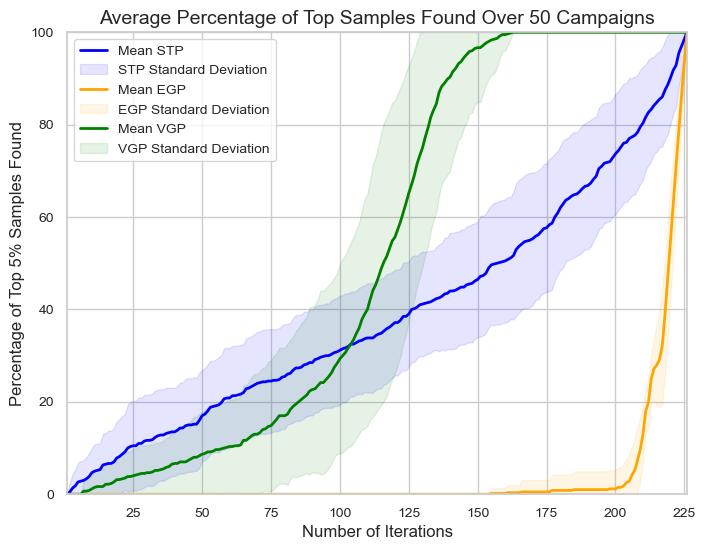

In [16]:
for element in maxDatasets:

    print(f"Starting {element}")

    dataset = element
    
    data = pd.read_csv(f"datasets\{dataset}_dataset.csv")
    data = data.groupby(data.columns[-1]).mean().reset_index()
    train_x = torch.tensor(data.iloc[:, 1:].values)
    train_y = torch.tensor(data.iloc[:, 0].values).unsqueeze(1) 

    N = len(train_x)

    # We are using prededfined candidates, so we can scale at the start
    TorchStd = TorchStandardScaler()
    TorchStd.fit(train_x)
    TorchNorm = TorchNormalizer()
    TorchNorm.fit(train_x)
    
    set_seeds(42)

    print(f"Number of samples: {N}")
    
    n_top = int(math.ceil(N * 0.05))

    # find the top 5% of the samples
    train_y_df = pd.DataFrame(train_y.numpy(), columns=[0])
    top_samples = train_y_df.nlargest(n_top, train_y_df.columns[0], keep='first').iloc[:, 0].values.tolist()
    print(f"Number of of top 5% samples: {len(top_samples)}")
    print(f"Top 5% samples: {top_samples}")

    def TopSamplesAmnt(y, top_samples):
        return len([i for i in y if i in top_samples]) / len(top_samples)

    # Generate a list of seeds randomly picked from the range 0-1000 equal to the number of campaigns without repeating
    seedList = random.sample(range(1000), campaigns)
            
    for i in trange(len(seedList)):
        globals()['topSTP' + str(i)], globals()['iterationSTP' + str(i)] = runMaxSTP(seedList[i])

    for i in trange(len(seedList)):
        globals()['topEGP' + str(i)], globals()['iterationEGP' + str(i)] = runMaxEGP(seedList[i])

    for i in trange(len(seedList)):
        globals()['topVGP' + str(i)], globals()['iterationVGP' + str(i)] = runMaxVGP(seedList[i])


    num_arrays = len(seedList)  
    # Function to dynamically collect arrays
    def collect_arrays(prefix, num_arrays):
        arrays = []
        for i in range(num_arrays):
            array = globals().get(f'{prefix}{i}', None)
            if array is not None:
                arrays.append(array)
        return arrays

    # Function to pad arrays with the last element to match the maximum length
    def pad_array(array, max_length):
        return np.pad(array, (0, max_length - len(array)), 'constant', constant_values=array[-1])

    def find_max_length(prefix, num_arrays):
        arrays = collect_arrays(prefix, num_arrays)
        return max(len(arr) for arr in arrays)

    # Process arrays for each type
    def process_arrays(prefix, num_arrays, max_length):
        arrays = collect_arrays(prefix, num_arrays)
        padded_arrays = [pad_array(arr, max_length) for arr in arrays]
        stack = np.stack(padded_arrays)
        mean_values = np.mean(stack, axis=0)
        std_values = np.std(stack, axis=0)
        return mean_values, std_values

    # Process arrays for STP, EGP, and VGP
    max_length_STP = find_max_length('topSTP', num_arrays)
    max_length_EGP = find_max_length('topEGP', num_arrays)
    max_length_VGP = find_max_length('topVGP', num_arrays)
    max_length = max(max_length_STP, max_length_EGP, max_length_VGP)
    mean_topSTP, std_valuesSTP = process_arrays('topSTP', num_arrays, max_length)
    mean_topEGP, std_valuesEGP = process_arrays('topEGP', num_arrays, max_length)
    mean_topVGP, std_valuesVGP = process_arrays('topVGP', num_arrays, max_length)

    # Ensure that the number of iterations matches the longest array length
    max_length = max(max_length_STP, max_length_EGP, max_length_VGP)
    iterations = np.arange(1, max_length + 1)



    sns.set(style="whitegrid")
    # Plot the mean and fill between the min and max for each type
    plt.figure(figsize=(8, 6))

    # Plot for STP
    sns.lineplot(x=iterations, y=mean_topSTP, label='Mean STP', color='blue', linewidth=2)
    plt.fill_between(iterations, mean_topSTP - std_valuesSTP, mean_topSTP + std_valuesSTP, label='STP Standard Deviation', color='blue', alpha=0.1)

    # Plot for EGP
    sns.lineplot(x=iterations, y=mean_topEGP, label='Mean EGP', color='orange', linewidth=2)
    plt.fill_between(iterations, mean_topEGP - std_valuesEGP, mean_topEGP + std_valuesEGP, label='EGP Standard Deviation', color='orange', alpha=0.1)

    # Plot for VGP
    plt.plot(iterations, mean_topVGP, label='Mean VGP', color='green', linewidth=2)
    plt.fill_between(iterations, mean_topVGP - std_valuesVGP, mean_topVGP + std_valuesVGP, label='VGP Standard Deviation', color='green', alpha=0.1)

    plt.xlabel('Number of Iterations', fontsize=12)
    plt.ylabel('Percentage of Top 5% Samples Found', fontsize=12)
    plt.title(f'Average Percentage of Top Samples Found Over {num_arrays} Campaigns', fontsize=14)
    plt.legend(fontsize=10, loc='upper left')

    # Customize ticks
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

    # Adjust axis limits and aspect ratio if needed
    plt.ylim(0, 100)
    plt.xlim(1, max_length)


    # save the plot 
    plt.savefig(f"{dataset}50Campaign50OptLoopMean")
    plt.show()


# Minimum Tests

<string>:7: SyntaxWarning: invalid escape sequence '\{'
<>:7: SyntaxWarning: invalid escape sequence '\{'
<string>:7: SyntaxWarning: invalid escape sequence '\{'
<>:7: SyntaxWarning: invalid escape sequence '\{'
C:\Users\stan\AppData\Local\Temp\ipykernel_65552\3720585052.py:7: SyntaxWarning: invalid escape sequence '\{'
  data = pd.read_csv(f"datasets\{dataset}_dataset.csv")


Starting Perovskite
Number of of top 5% samples: 7
Top 5% samples: [1755056.0, 1583406.0, 1497320.0, 1413800.0, 1375402.0, 1300295.0, 1281399.0]


  0%|          | 0/50 [00:00<?, ?it/s]

Minimizing with STP
Seed: 654
Initial points: tensor([[0.3800, 0.6200, 0.0000],
        [0.0500, 0.7885, 0.1615],
        [0.2600, 0.3800, 0.3600],
        [0.8000, 0.1100, 0.0900],
        [0.0000, 1.0000, 0.0000]])


  2%|▏         | 1/50 [01:03<51:27, 63.02s/it]

Iterations 133
Minimizing with STP
Seed: 114
Initial points: tensor([[0.3200, 0.6800, 0.0000],
        [0.1700, 0.8000, 0.0300],
        [0.0000, 1.0000, 0.0000],
        [0.2500, 0.7000, 0.0600],
        [0.0000, 0.5000, 0.5000]])


  4%|▍         | 2/50 [02:06<50:38, 63.30s/it]

Iterations 134
Minimizing with STP
Seed: 25
Initial points: tensor([[0.5000, 0.0000, 0.5000],
        [0.1300, 0.8700, 0.0000],
        [0.2500, 0.5000, 0.2500],
        [0.5000, 0.2500, 0.2500],
        [0.0500, 0.7885, 0.1615]])


  6%|▌         | 3/50 [03:09<49:25, 63.09s/it]

Iterations 133
Minimizing with STP
Seed: 759
Initial points: tensor([[0.1200, 0.8100, 0.0700],
        [0.1300, 0.7900, 0.0800],
        [0.8000, 0.1100, 0.0900],
        [0.7500, 0.2500, 0.0000],
        [0.2600, 0.3800, 0.3600]])


  8%|▊         | 4/50 [04:15<49:21, 64.38s/it]

Iterations 133
Minimizing with STP
Seed: 281
Initial points: tensor([[0.1600, 0.7500, 0.0900],
        [0.5000, 0.2500, 0.2500],
        [0.2400, 0.3700, 0.3900],
        [0.8900, 0.0000, 0.1100],
        [0.0500, 0.7885, 0.1615]])


 10%|█         | 5/50 [05:22<48:52, 65.18s/it]

Iterations 134
Minimizing with STP
Seed: 250
Initial points: tensor([[0.1700, 0.8000, 0.0300],
        [0.8000, 0.1100, 0.0900],
        [0.5000, 0.5000, 0.0000],
        [0.2500, 0.5000, 0.2500],
        [0.0000, 0.7500, 0.2500]])


 12%|█▏        | 6/50 [06:31<48:49, 66.59s/it]

Iterations 134
Minimizing with STP
Seed: 228
Initial points: tensor([[0.6600, 0.2400, 0.1000],
        [0.2500, 0.7000, 0.0600],
        [0.8300, 0.0300, 0.1400],
        [0.5000, 0.2500, 0.2500],
        [0.4400, 0.5500, 0.0100]])


 14%|█▍        | 7/50 [07:37<47:39, 66.50s/it]

Iterations 134
Minimizing with STP
Seed: 142
Initial points: tensor([[0.2500, 0.7100, 0.0400],
        [0.8900, 0.0000, 0.1100],
        [0.2800, 0.6500, 0.0700],
        [0.6800, 0.1300, 0.1900],
        [0.1300, 0.7900, 0.0800]])


 16%|█▌        | 8/50 [08:45<46:44, 66.78s/it]

Iterations 133
Minimizing with STP
Seed: 754
Initial points: tensor([[0.1700, 0.8000, 0.0300],
        [0.0600, 0.8500, 0.0900],
        [0.2300, 0.6600, 0.1100],
        [0.5000, 0.5000, 0.0000],
        [0.7600, 0.2400, 0.0000]])


 18%|█▊        | 9/50 [09:50<45:21, 66.39s/it]

Iterations 134
Minimizing with STP
Seed: 104
Initial points: tensor([[0.3200, 0.6700, 0.0100],
        [0.9100, 0.0100, 0.0800],
        [0.1300, 0.8700, 0.0000],
        [0.5300, 0.4700, 0.0000],
        [0.1300, 0.8700, 0.0000]])


 20%|██        | 10/50 [10:55<43:52, 65.82s/it]

Iterations 133
Minimizing with STP
Seed: 692
Initial points: tensor([[0.1200, 0.8100, 0.0700],
        [0.0000, 0.7500, 0.2500],
        [0.8000, 0.1100, 0.0900],
        [0.1300, 0.7900, 0.0800],
        [0.8800, 0.0000, 0.1200]])


 22%|██▏       | 11/50 [12:00<42:41, 65.67s/it]

Iterations 134
Minimizing with STP
Seed: 758
Initial points: tensor([[0.0500, 0.7885, 0.1615],
        [0.0900, 0.8700, 0.0400],
        [0.1200, 0.7700, 0.1100],
        [0.3100, 0.3600, 0.3300],
        [0.1600, 0.8400, 0.0000]])


 24%|██▍       | 12/50 [13:06<41:32, 65.59s/it]

Iterations 134
Minimizing with STP
Seed: 913
Initial points: tensor([[0.3200, 0.6800, 0.0000],
        [0.0500, 0.7885, 0.1615],
        [0.1200, 0.7700, 0.1100],
        [0.8000, 0.1100, 0.0900],
        [1.0000, 0.0000, 0.0000]])


 26%|██▌       | 13/50 [14:12<40:34, 65.80s/it]

Iterations 134
Minimizing with STP
Seed: 558
Initial points: tensor([[0.3200, 0.6700, 0.0100],
        [0.1400, 0.8400, 0.0200],
        [0.1900, 0.8100, 0.0000],
        [0.1300, 0.8700, 0.0000],
        [0.7000, 0.2900, 0.0100]])


 28%|██▊       | 14/50 [15:17<39:21, 65.60s/it]

Iterations 134
Minimizing with STP
Seed: 89
Initial points: tensor([[0.2600, 0.3700, 0.3600],
        [0.1300, 0.8700, 0.0000],
        [0.3400, 0.6400, 0.0200],
        [0.7100, 0.0600, 0.2300],
        [0.1900, 0.7000, 0.1100]])


 30%|███       | 15/50 [16:22<38:12, 65.50s/it]

Iterations 134
Minimizing with STP
Seed: 604
Initial points: tensor([[0.8400, 0.0000, 0.1600],
        [0.3700, 0.6300, 0.0000],
        [0.2300, 0.7700, 0.0000],
        [0.7100, 0.0100, 0.2800],
        [0.1300, 0.7900, 0.0800]])


 32%|███▏      | 16/50 [17:27<36:57, 65.23s/it]

Iterations 133
Minimizing with STP
Seed: 432
Initial points: tensor([[0.2500, 0.7000, 0.0600],
        [0.1700, 0.8200, 0.0100],
        [0.6300, 0.3700, 0.0000],
        [0.2600, 0.3800, 0.3600],
        [0.2600, 0.3800, 0.3600]])


 34%|███▍      | 17/50 [18:32<35:52, 65.22s/it]

Iterations 134
Minimizing with STP
Seed: 32
Initial points: tensor([[0.0900, 0.9100, 0.0000],
        [0.0000, 0.5000, 0.5000],
        [0.3000, 0.6900, 0.0100],
        [0.1200, 0.8100, 0.0700],
        [0.5000, 0.0000, 0.5000]])


 36%|███▌      | 18/50 [19:37<34:41, 65.06s/it]

Iterations 133
Minimizing with STP
Seed: 30
Initial points: tensor([[0.7500, 0.2500, 0.0000],
        [0.1300, 0.8500, 0.0200],
        [0.6300, 0.3700, 0.0000],
        [0.1700, 0.8000, 0.0300],
        [0.2800, 0.3700, 0.3500]])


 38%|███▊      | 19/50 [20:42<33:35, 65.02s/it]

Iterations 134
Minimizing with STP
Seed: 95
Initial points: tensor([[0.6300, 0.3700, 0.0000],
        [0.1600, 0.8400, 0.0000],
        [0.6600, 0.2400, 0.1000],
        [0.2600, 0.3700, 0.3600],
        [0.6900, 0.3100, 0.0000]])


 40%|████      | 20/50 [21:47<32:32, 65.09s/it]

Iterations 134
Minimizing with STP
Seed: 223
Initial points: tensor([[0.1700, 0.8000, 0.0300],
        [0.1600, 0.8300, 0.0100],
        [0.2500, 0.7000, 0.0600],
        [0.0500, 0.7885, 0.1615],
        [0.3500, 0.6500, 0.0000]])


 42%|████▏     | 21/50 [22:51<31:22, 64.91s/it]

Iterations 133
Minimizing with STP
Seed: 238
Initial points: tensor([[0.1800, 0.8200, 0.0000],
        [0.0000, 0.5000, 0.5000],
        [0.3100, 0.3600, 0.3300],
        [0.2600, 0.3800, 0.3600],
        [0.1600, 0.8400, 0.0000]])


 44%|████▍     | 22/50 [23:55<30:08, 64.59s/it]

Iterations 132
Minimizing with STP
Seed: 517
Initial points: tensor([[0.0500, 0.7885, 0.1615],
        [0.7000, 0.2900, 0.0100],
        [0.2600, 0.3700, 0.3600],
        [0.8000, 0.1100, 0.0900],
        [0.1700, 0.8000, 0.0300]])


 46%|████▌     | 23/50 [25:01<29:09, 64.81s/it]

Iterations 134
Minimizing with STP
Seed: 616
Initial points: tensor([[0.8800, 0.0000, 0.1200],
        [0.6900, 0.3100, 0.0000],
        [0.2200, 0.7800, 0.0000],
        [0.3400, 0.6400, 0.0200],
        [0.1300, 0.8700, 0.0000]])


 48%|████▊     | 24/50 [26:06<28:07, 64.91s/it]

Iterations 134
Minimizing with STP
Seed: 27
Initial points: tensor([[0.7500, 0.0000, 0.2500],
        [0.0000, 0.7500, 0.2500],
        [0.6900, 0.3100, 0.0000],
        [0.8400, 0.0000, 0.1600],
        [0.1200, 0.8100, 0.0700]])


 50%|█████     | 25/50 [27:10<27:00, 64.82s/it]

Iterations 133
Minimizing with STP
Seed: 574
Initial points: tensor([[0.5900, 0.4100, 0.0000],
        [0.1800, 0.7800, 0.0400],
        [0.1600, 0.7500, 0.0900],
        [0.1700, 0.8200, 0.0100],
        [0.0000, 0.7500, 0.2500]])


 52%|█████▏    | 26/50 [28:16<26:00, 65.01s/it]

Iterations 134
Minimizing with STP
Seed: 203
Initial points: tensor([[0.1000, 0.8900, 0.0100],
        [0.1300, 0.7900, 0.0800],
        [0.7000, 0.2900, 0.0100],
        [0.1900, 0.7000, 0.1100],
        [0.1400, 0.8400, 0.0200]])


 54%|█████▍    | 27/50 [29:22<25:00, 65.22s/it]

Iterations 134
Minimizing with STP
Seed: 733
Initial points: tensor([[0.7500, 0.2500, 0.0000],
        [0.1700, 0.8000, 0.0300],
        [0.2000, 0.6900, 0.1100],
        [0.0000, 0.7500, 0.2500],
        [0.2800, 0.6500, 0.0700]])


 56%|█████▌    | 28/50 [30:27<23:55, 65.27s/it]

Iterations 134
Minimizing with STP
Seed: 665
Initial points: tensor([[0.8900, 0.0000, 0.1100],
        [0.1300, 0.8700, 0.0000],
        [0.1600, 0.8400, 0.0000],
        [0.0000, 0.5000, 0.5000],
        [0.1000, 0.9000, 0.0000]])


 58%|█████▊    | 29/50 [31:32<22:50, 65.28s/it]

Iterations 134
Minimizing with STP
Seed: 718
Initial points: tensor([[0.2400, 0.3700, 0.3900],
        [0.3700, 0.6200, 0.0100],
        [0.3200, 0.6800, 0.0000],
        [0.3900, 0.6100, 0.0000],
        [0.5900, 0.4100, 0.0000]])


 60%|██████    | 30/50 [32:37<21:45, 65.26s/it]

Iterations 134
Minimizing with STP
Seed: 429
Initial points: tensor([[0.7100, 0.0600, 0.2300],
        [0.0000, 1.0000, 0.0000],
        [0.8400, 0.0000, 0.1600],
        [0.1800, 0.7600, 0.0600],
        [0.0000, 0.0000, 1.0000]])


 62%|██████▏   | 31/50 [33:43<20:41, 65.33s/it]

Iterations 134
Minimizing with STP
Seed: 225
Initial points: tensor([[0.0000, 0.7500, 0.2500],
        [0.3000, 0.6900, 0.0100],
        [0.2600, 0.3800, 0.3600],
        [0.3500, 0.6500, 0.0000],
        [0.0000, 0.0000, 1.0000]])


 64%|██████▍   | 32/50 [34:48<19:34, 65.26s/it]

Iterations 134
Minimizing with STP
Seed: 459
Initial points: tensor([[0.1700, 0.8000, 0.0300],
        [0.2500, 0.7100, 0.0400],
        [0.3200, 0.6800, 0.0000],
        [0.2800, 0.3700, 0.3500],
        [0.2700, 0.3400, 0.4000]])


 66%|██████▌   | 33/50 [35:53<18:28, 65.18s/it]

Iterations 134
Minimizing with STP
Seed: 603
Initial points: tensor([[0.6800, 0.1300, 0.1900],
        [0.3200, 0.6800, 0.0000],
        [0.1300, 0.8700, 0.0000],
        [0.0000, 0.0000, 1.0000],
        [0.5000, 0.5000, 0.0000]])


 68%|██████▊   | 34/50 [36:58<17:23, 65.20s/it]

Iterations 134
Minimizing with STP
Seed: 284
Initial points: tensor([[0.7600, 0.2400, 0.0000],
        [0.0000, 0.7500, 0.2500],
        [0.1300, 0.8700, 0.0000],
        [0.9100, 0.0100, 0.0800],
        [0.2500, 0.7500, 0.0000]])


 70%|███████   | 35/50 [38:03<16:14, 64.96s/it]

Iterations 133
Minimizing with STP
Seed: 828
Initial points: tensor([[0.1900, 0.8100, 0.0000],
        [0.0600, 0.8500, 0.0900],
        [0.0500, 0.7885, 0.1615],
        [0.0000, 0.7500, 0.2500],
        [0.2700, 0.3400, 0.4000]])


 72%|███████▏  | 36/50 [39:07<15:07, 64.80s/it]

Iterations 133
Minimizing with STP
Seed: 890
Initial points: tensor([[0.3400, 0.6400, 0.0200],
        [0.2300, 0.7700, 0.0000],
        [1.0000, 0.0000, 0.0000],
        [0.7000, 0.2900, 0.0100],
        [0.0000, 0.0000, 1.0000]])


 74%|███████▍  | 37/50 [40:12<14:03, 64.92s/it]

Iterations 134
Minimizing with STP
Seed: 6
Initial points: tensor([[0.1700, 0.8000, 0.0300],
        [0.1300, 0.8700, 0.0000],
        [0.0500, 0.7885, 0.1615],
        [0.2300, 0.6600, 0.1100],
        [0.7100, 0.0100, 0.2800]])


 76%|███████▌  | 38/50 [41:17<12:58, 64.85s/it]

Iterations 133
Minimizing with STP
Seed: 777
Initial points: tensor([[0.1700, 0.8000, 0.0300],
        [0.1400, 0.8400, 0.0200],
        [0.2500, 0.7500, 0.0000],
        [0.2300, 0.7700, 0.0000],
        [0.2700, 0.3400, 0.4000]])


 78%|███████▊  | 39/50 [42:22<11:54, 64.91s/it]

Iterations 134
Minimizing with STP
Seed: 825
Initial points: tensor([[0.2500, 0.7500, 0.0000],
        [0.7500, 0.0000, 0.2500],
        [0.2600, 0.3800, 0.3600],
        [0.8800, 0.0000, 0.1200],
        [0.6600, 0.2400, 0.1000]])


 80%|████████  | 40/50 [43:27<10:49, 64.91s/it]

Iterations 134
Minimizing with STP
Seed: 163
Initial points: tensor([[0.3000, 0.6900, 0.0100],
        [0.2000, 0.6900, 0.1100],
        [0.8400, 0.0000, 0.1600],
        [0.2400, 0.3700, 0.3900],
        [0.3200, 0.6800, 0.0000]])


 82%|████████▏ | 41/50 [44:32<09:44, 64.96s/it]

Iterations 134
Minimizing with STP
Seed: 714
Initial points: tensor([[0.2500, 0.7500, 0.0000],
        [1.0000, 0.0000, 0.0000],
        [0.3700, 0.6200, 0.0100],
        [0.7500, 0.2500, 0.0000],
        [0.5900, 0.4100, 0.0000]])


 84%|████████▍ | 42/50 [45:38<08:41, 65.13s/it]

Iterations 134
Minimizing with STP
Seed: 348
Initial points: tensor([[0.2500, 0.7000, 0.0600],
        [0.2800, 0.3700, 0.3500],
        [0.5000, 0.5000, 0.0000],
        [0.5000, 0.2500, 0.2500],
        [0.3400, 0.5400, 0.1200]])


 86%|████████▌ | 43/50 [46:43<07:36, 65.17s/it]

Iterations 134
Minimizing with STP
Seed: 159
Initial points: tensor([[0.2500, 0.7500, 0.0000],
        [0.1300, 0.8700, 0.0000],
        [0.0000, 0.7500, 0.2500],
        [0.0000, 1.0000, 0.0000],
        [0.3800, 0.6200, 0.0000]])


 88%|████████▊ | 44/50 [47:48<06:30, 65.16s/it]

Iterations 134
Minimizing with STP
Seed: 220
Initial points: tensor([[0.8400, 0.0000, 0.1600],
        [0.9100, 0.0100, 0.0800],
        [0.0000, 0.0000, 1.0000],
        [0.2500, 0.7000, 0.0600],
        [0.5000, 0.2500, 0.2500]])


 90%|█████████ | 45/50 [48:53<05:26, 65.20s/it]

Iterations 134
Minimizing with STP
Seed: 980
Initial points: tensor([[0.1300, 0.8700, 0.0000],
        [0.7800, 0.0900, 0.1300],
        [0.2500, 0.7500, 0.0000],
        [0.0000, 1.0000, 0.0000],
        [0.0000, 0.0000, 1.0000]])


 92%|█████████▏| 46/50 [49:59<04:21, 65.25s/it]

Iterations 134
Minimizing with STP
Seed: 781
Initial points: tensor([[0.0000, 1.0000, 0.0000],
        [0.3900, 0.6100, 0.0000],
        [0.0900, 0.8700, 0.0400],
        [0.4300, 0.5700, 0.0000],
        [0.2600, 0.3800, 0.3600]])


 94%|█████████▍| 47/50 [51:04<03:15, 65.23s/it]

Iterations 134
Minimizing with STP
Seed: 344
Initial points: tensor([[0.0500, 0.7885, 0.1615],
        [0.1200, 0.7700, 0.1100],
        [0.8400, 0.0000, 0.1600],
        [0.1900, 0.7000, 0.1100],
        [0.8000, 0.1100, 0.0900]])


 96%|█████████▌| 48/50 [52:09<02:10, 65.25s/it]

Iterations 134
Minimizing with STP
Seed: 94
Initial points: tensor([[0.2700, 0.7200, 0.0100],
        [0.1300, 0.8700, 0.0000],
        [0.6300, 0.3700, 0.0000],
        [0.4100, 0.5800, 0.0100],
        [0.1600, 0.8300, 0.0100]])


 98%|█████████▊| 49/50 [53:14<01:05, 65.01s/it]

Iterations 133
Minimizing with STP
Seed: 389
Initial points: tensor([[0.8800, 0.0000, 0.1200],
        [0.2200, 0.7200, 0.0600],
        [0.3500, 0.6500, 0.0000],
        [0.8900, 0.0000, 0.1100],
        [0.6900, 0.3100, 0.0000]])


100%|██████████| 50/50 [54:19<00:00, 65.18s/it]


Iterations 134


  0%|          | 0/50 [00:00<?, ?it/s]

Minimizing with EGP
Seed: 654
Initial points: tensor([[0.7500, 0.2500, 0.0000],
        [0.1800, 0.7800, 0.0400],
        [0.8900, 0.0000, 0.1100],
        [0.8000, 0.1100, 0.0900],
        [1.0000, 0.0000, 0.0000]])


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, display

Iterations 134
Minimizing with EGP
Seed: 114
Initial points: tensor([[0.1700, 0.8000, 0.0300],
        [0.1600, 0.7500, 0.0900],
        [0.2600, 0.3800, 0.3600],
        [0.3500, 0.6500, 0.0000],
        [0.1300, 0.7900, 0.0800]])


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, display

Iterations 134
Minimizing with EGP
Seed: 25
Initial points: tensor([[0.2600, 0.3800, 0.3600],
        [0.8300, 0.0000, 0.1700],
        [0.8400, 0.0000, 0.1600],
        [0.8700, 0.1200, 0.0100],
        [0.1600, 0.8300, 0.0100]])


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, display

Iterations 134
Minimizing with EGP
Seed: 759
Initial points: tensor([[0.2300, 0.6600, 0.1100],
        [0.2500, 0.7000, 0.0600],
        [0.2800, 0.3700, 0.3500],
        [0.6800, 0.1300, 0.1900],
        [0.2700, 0.3400, 0.4000]])


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, display

Iterations 134
Minimizing with EGP
Seed: 281
Initial points: tensor([[0.3000, 0.6900, 0.0100],
        [0.8100, 0.0000, 0.1900],
        [0.1300, 0.8700, 0.0000],
        [0.3500, 0.6500, 0.0000],
        [0.3700, 0.6300, 0.0000]])


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:

Iterations 134
Minimizing with EGP
Seed: 250
Initial points: tensor([[0.4400, 0.5500, 0.0100],
        [0.2500, 0.7000, 0.0600],
        [0.7100, 0.0100, 0.2800],
        [0.0000, 0.0000, 1.0000],
        [0.2300, 0.6600, 0.1100]])


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, display

Iterations 134
Minimizing with EGP
Seed: 228
Initial points: tensor([[0.1300, 0.7900, 0.0800],
        [0.4400, 0.5500, 0.0100],
        [0.1800, 0.7600, 0.0600],
        [0.4100, 0.5800, 0.0100],
        [0.1900, 0.7000, 0.1100]])


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, display

Iterations 134
Minimizing with EGP
Seed: 142
Initial points: tensor([[0.1600, 0.8400, 0.0000],
        [0.3900, 0.6100, 0.0000],
        [0.1300, 0.8500, 0.0200],
        [0.3500, 0.6500, 0.0000],
        [0.3800, 0.6200, 0.0000]])


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, display

Iterations 134
Minimizing with EGP
Seed: 754
Initial points: tensor([[0.2000, 0.8000, 0.0000],
        [0.0500, 0.7885, 0.1615],
        [0.1300, 0.7900, 0.0800],
        [0.6800, 0.1300, 0.1900],
        [0.2700, 0.7200, 0.0100]])


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, display

Iterations 134
Minimizing with EGP
Seed: 104
Initial points: tensor([[0.2500, 0.5000, 0.2500],
        [0.1800, 0.7600, 0.0600],
        [0.7000, 0.2900, 0.0100],
        [0.0900, 0.9100, 0.0000],
        [0.1000, 0.9000, 0.0000]])


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils

Iterations 134
Minimizing with EGP
Seed: 692
Initial points: tensor([[0.0000, 0.5000, 0.5000],
        [0.2500, 0.7100, 0.0400],
        [0.1700, 0.8000, 0.0300],
        [0.5000, 0.2500, 0.2500],
        [0.1800, 0.7600, 0.0600]])


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, display

Iterations 134
Minimizing with EGP
Seed: 758
Initial points: tensor([[0.5000, 0.0000, 0.5000],
        [0.0000, 0.5000, 0.5000],
        [0.1000, 0.9000, 0.0000],
        [0.3800, 0.6200, 0.0000],
        [0.5000, 0.0000, 0.5000]])


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\gpytorch\distributions\multivariate_normal.py:319: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\gpytorch\distributions\multivariate_normal.py:319: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying origin

Iterations 134
Minimizing with EGP
Seed: 913
Initial points: tensor([[0.2600, 0.3800, 0.3600],
        [0.0900, 0.8700, 0.0400],
        [0.8100, 0.0000, 0.1900],
        [0.5000, 0.0000, 0.5000],
        [0.8000, 0.1100, 0.0900]])


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, display

Iterations 134
Minimizing with EGP
Seed: 558
Initial points: tensor([[0.7000, 0.2900, 0.0100],
        [0.1700, 0.8000, 0.0300],
        [0.1300, 0.7900, 0.0800],
        [0.7600, 0.2400, 0.0000],
        [0.0500, 0.7885, 0.1615]])


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\gpytorch\distributions\multivariate_normal.py:319: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\gpytorch\distributions\multivariate_normal.py:319: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying origin

Iterations 134
Minimizing with EGP
Seed: 89
Initial points: tensor([[0.1600, 0.7500, 0.0900],
        [0.1300, 0.8700, 0.0000],
        [0.0500, 0.7885, 0.1615],
        [0.1800, 0.7600, 0.0600],
        [1.0000, 0.0000, 0.0000]])


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, display

Iterations 134
Minimizing with EGP
Seed: 604
Initial points: tensor([[0.0000, 1.0000, 0.0000],
        [0.7000, 0.2900, 0.0100],
        [0.3900, 0.6100, 0.0000],
        [0.2600, 0.7400, 0.0000],
        [0.2300, 0.7700, 0.0000]])


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, display

Iterations 134
Minimizing with EGP
Seed: 432
Initial points: tensor([[0.6800, 0.1300, 0.1900],
        [0.2600, 0.3800, 0.3600],
        [0.2300, 0.6600, 0.1100],
        [0.3000, 0.3900, 0.3200],
        [0.3000, 0.6900, 0.0100]])


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, display

Iterations 134
Minimizing with EGP
Seed: 32
Initial points: tensor([[0.1400, 0.8400, 0.0200],
        [0.5000, 0.0000, 0.5000],
        [0.1000, 0.8900, 0.0100],
        [0.0900, 0.8500, 0.0600],
        [0.8400, 0.0000, 0.1600]])


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils

Iterations 134
Minimizing with EGP
Seed: 30
Initial points: tensor([[0.5700, 0.4300, 0.0000],
        [0.8100, 0.0000, 0.1900],
        [0.3700, 0.6200, 0.0100],
        [0.5000, 0.5000, 0.0000],
        [0.4400, 0.5500, 0.0100]])


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, display

Iterations 134
Minimizing with EGP
Seed: 95
Initial points: tensor([[0.0600, 0.8500, 0.0900],
        [0.1000, 0.9000, 0.0000],
        [0.1300, 0.7900, 0.0800],
        [0.1000, 0.8900, 0.0100],
        [0.2600, 0.3800, 0.3600]])


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, display

Iterations 134
Minimizing with EGP
Seed: 223
Initial points: tensor([[1.0000, 0.0000, 0.0000],
        [0.8900, 0.0000, 0.1100],
        [0.8400, 0.0000, 0.1600],
        [0.0000, 0.7500, 0.2500],
        [0.0500, 0.7885, 0.1615]])


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\gpytorch\distribution

Iterations 134
Minimizing with EGP
Seed: 238
Initial points: tensor([[0.1800, 0.7800, 0.0400],
        [0.2500, 0.5000, 0.2500],
        [0.9100, 0.0100, 0.0800],
        [0.3100, 0.3600, 0.3300],
        [0.1300, 0.8700, 0.0000]])


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, display

Iterations 134
Minimizing with EGP
Seed: 517
Initial points: tensor([[0.0000, 1.0000, 0.0000],
        [0.8400, 0.0000, 0.1600],
        [0.0000, 0.7500, 0.2500],
        [0.8300, 0.0000, 0.1700],
        [0.3000, 0.6900, 0.0100]])


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, display

Iterations 134
Minimizing with EGP
Seed: 616
Initial points: tensor([[0.6600, 0.2400, 0.1000],
        [0.1900, 0.8100, 0.0000],
        [0.0900, 0.8500, 0.0600],
        [0.6300, 0.3700, 0.0000],
        [0.0000, 0.0000, 1.0000]])


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, display

Iterations 134
Minimizing with EGP
Seed: 27
Initial points: tensor([[0.1200, 0.7700, 0.1100],
        [0.2500, 0.7500, 0.0000],
        [0.1800, 0.8200, 0.0000],
        [0.1000, 0.9000, 0.0000],
        [0.0500, 0.7885, 0.1615]])


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\gpytorch\distributions\multivariate_normal.py:319: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\gpytorch\distributions\multivariate_normal.py:319: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\gpytorch\distributions\multivariate_normal.py:319: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\gpytorch\distributions\multivariate_normal.py:319: NumericalWarning: Negative variance values detected. This is likely due to numerical i

Iterations 134
Minimizing with EGP
Seed: 574
Initial points: tensor([[0.7500, 0.2500, 0.0000],
        [0.7000, 0.2900, 0.0100],
        [0.2000, 0.6900, 0.1100],
        [0.2300, 0.6600, 0.1100],
        [0.6800, 0.1300, 0.1900]])


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, display

Iterations 134
Minimizing with EGP
Seed: 203
Initial points: tensor([[0.7600, 0.2400, 0.0000],
        [0.5900, 0.4100, 0.0000],
        [0.8300, 0.0300, 0.1400],
        [0.2700, 0.3400, 0.4000],
        [0.1700, 0.8000, 0.0300]])


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, display

Iterations 134
Minimizing with EGP
Seed: 733
Initial points: tensor([[0.1800, 0.7800, 0.0400],
        [0.2000, 0.6900, 0.1100],
        [0.8700, 0.1200, 0.0100],
        [0.1300, 0.7900, 0.0800],
        [0.1300, 0.7900, 0.0800]])


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\gpytorch\distributions\multivariate_normal.py:319: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\gpytorch\distributions\multivariate_normal.py:319: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40:

Iterations 134
Minimizing with EGP
Seed: 665
Initial points: tensor([[0.2500, 0.7000, 0.0600],
        [0.8300, 0.0000, 0.1700],
        [0.1300, 0.8500, 0.0200],
        [0.6800, 0.1300, 0.1900],
        [0.1000, 0.8900, 0.0100]])


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, display

Iterations 134
Minimizing with EGP
Seed: 718
Initial points: tensor([[0.3200, 0.6700, 0.0100],
        [0.2700, 0.7200, 0.0100],
        [0.5000, 0.5000, 0.0000],
        [0.2200, 0.7800, 0.0000],
        [0.6800, 0.1300, 0.1900]])


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, display

Iterations 134
Minimizing with EGP
Seed: 429
Initial points: tensor([[0.9100, 0.0100, 0.0800],
        [0.2300, 0.6600, 0.1100],
        [0.1900, 0.7000, 0.1100],
        [0.3000, 0.6900, 0.0100],
        [0.5000, 0.5000, 0.0000]])


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, display

Iterations 134
Minimizing with EGP
Seed: 225
Initial points: tensor([[0.7500, 0.0000, 0.2500],
        [1.0000, 0.0000, 0.0000],
        [0.4100, 0.5800, 0.0100],
        [0.1800, 0.8200, 0.0000],
        [0.6300, 0.3700, 0.0000]])


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils

Iterations 134
Minimizing with EGP
Seed: 459
Initial points: tensor([[0.2500, 0.7500, 0.0000],
        [0.6300, 0.3700, 0.0000],
        [0.1600, 0.7500, 0.0900],
        [0.1600, 0.8400, 0.0000],
        [0.5000, 0.2500, 0.2500]])


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, display

Iterations 134
Minimizing with EGP
Seed: 603
Initial points: tensor([[0.8400, 0.0000, 0.1600],
        [0.3100, 0.3600, 0.3300],
        [0.2800, 0.3700, 0.3500],
        [0.2600, 0.7400, 0.0000],
        [0.7100, 0.0100, 0.2800]])


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, display

Iterations 134
Minimizing with EGP
Seed: 284
Initial points: tensor([[0.1000, 0.8900, 0.0100],
        [0.3500, 0.6500, 0.0000],
        [0.1300, 0.7900, 0.0800],
        [1.0000, 0.0000, 0.0000],
        [0.3700, 0.6300, 0.0000]])


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, display

Iterations 134
Minimizing with EGP
Seed: 828
Initial points: tensor([[0.0600, 0.8500, 0.0900],
        [0.3000, 0.6900, 0.0100],
        [0.2500, 0.0000, 0.7500],
        [0.7500, 0.2500, 0.0000],
        [0.7500, 0.2500, 0.0000]])


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\gpytorch\distributions\multivariate_normal.py:319: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying o

Iterations 134
Minimizing with EGP
Seed: 890
Initial points: tensor([[0.3400, 0.6400, 0.0200],
        [0.2500, 0.5000, 0.2500],
        [1.0000, 0.0000, 0.0000],
        [0.0900, 0.8700, 0.0400],
        [1.0000, 0.0000, 0.0000]])


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, display

Iterations 134
Minimizing with EGP
Seed: 6
Initial points: tensor([[0.2000, 0.8000, 0.0000],
        [0.1400, 0.8400, 0.0200],
        [0.3000, 0.6900, 0.0100],
        [0.6300, 0.3700, 0.0000],
        [0.0500, 0.7885, 0.1615]])


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, display

Iterations 134
Minimizing with EGP
Seed: 777
Initial points: tensor([[0.3400, 0.5400, 0.1200],
        [0.5300, 0.4700, 0.0000],
        [0.3500, 0.6500, 0.0000],
        [0.3000, 0.3900, 0.3200],
        [0.1400, 0.8400, 0.0200]])


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, display

Iterations 134
Minimizing with EGP
Seed: 825
Initial points: tensor([[0.0000, 0.7500, 0.2500],
        [0.8300, 0.0300, 0.1400],
        [0.6300, 0.3700, 0.0000],
        [0.9600, 0.0400, 0.0000],
        [0.3700, 0.6200, 0.0100]])


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, display

Iterations 134
Minimizing with EGP
Seed: 163
Initial points: tensor([[0.1300, 0.8700, 0.0000],
        [0.1600, 0.8400, 0.0000],
        [0.2500, 0.7000, 0.0600],
        [0.2200, 0.7800, 0.0000],
        [0.1300, 0.7900, 0.0800]])


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\gpytorch\distributions\multivariate_normal.py:319: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\gpytorch\distributions\multivariate_normal.py:319: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\gpytorch\distributions\multivariate_normal.py:319: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
c:\Users\sta

Iterations 134
Minimizing with EGP
Seed: 714
Initial points: tensor([[0.4100, 0.5800, 0.0100],
        [0.3500, 0.6500, 0.0000],
        [0.3500, 0.6500, 0.0000],
        [0.2500, 0.5000, 0.2500],
        [0.2600, 0.7400, 0.0000]])


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, display

Iterations 134
Minimizing with EGP
Seed: 348
Initial points: tensor([[0.4400, 0.5500, 0.0100],
        [0.3500, 0.6500, 0.0000],
        [0.2800, 0.6500, 0.0700],
        [0.5700, 0.4300, 0.0000],
        [0.2200, 0.7800, 0.0000]])


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils

Iterations 134
Minimizing with EGP
Seed: 159
Initial points: tensor([[0.1000, 0.9000, 0.0000],
        [0.6300, 0.3700, 0.0000],
        [0.2800, 0.6500, 0.0700],
        [0.3000, 0.6900, 0.0100],
        [0.2800, 0.3700, 0.3500]])


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, display

Iterations 134
Minimizing with EGP
Seed: 220
Initial points: tensor([[0.0900, 0.9100, 0.0000],
        [0.5000, 0.5000, 0.0000],
        [0.1300, 0.7900, 0.0800],
        [0.1600, 0.7500, 0.0900],
        [0.0000, 1.0000, 0.0000]])


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, display

Iterations 134
Minimizing with EGP
Seed: 980
Initial points: tensor([[0.7100, 0.0100, 0.2800],
        [0.2300, 0.7700, 0.0000],
        [0.2500, 0.7000, 0.0600],
        [0.1900, 0.8100, 0.0000],
        [0.2600, 0.7400, 0.0000]])


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\gpytorch\distributions\multivariate_normal.py:319: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\gpytorch\distributions\multivariate_normal.py:319: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40:

Iterations 134
Minimizing with EGP
Seed: 781
Initial points: tensor([[0.0900, 0.8700, 0.0400],
        [0.2500, 0.7100, 0.0400],
        [0.8400, 0.0000, 0.1600],
        [0.1600, 0.8400, 0.0000],
        [0.6600, 0.2400, 0.1000]])


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:

Iterations 134
Minimizing with EGP
Seed: 344
Initial points: tensor([[0.0000, 1.0000, 0.0000],
        [0.0500, 0.7885, 0.1615],
        [0.0500, 0.7885, 0.1615],
        [0.5000, 0.5000, 0.0000],
        [0.7500, 0.2500, 0.0000]])


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, display

Iterations 134
Minimizing with EGP
Seed: 94
Initial points: tensor([[0.8100, 0.0000, 0.1900],
        [0.8700, 0.1200, 0.0100],
        [0.1800, 0.7600, 0.0600],
        [0.1300, 0.8700, 0.0000],
        [0.2500, 0.7000, 0.0600]])


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, display

Iterations 134
Minimizing with EGP
Seed: 389
Initial points: tensor([[0.3500, 0.6500, 0.0000],
        [0.6600, 0.2400, 0.1000],
        [0.1300, 0.8700, 0.0000],
        [0.2300, 0.6600, 0.1100],
        [0.2800, 0.6500, 0.0700]])


c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\stan\miniconda3\envs\researchTP\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, display

Iterations 134


  0%|          | 0/50 [00:00<?, ?it/s]

Minimizing with VGP
Seed: 654
Initial points: tensor([[0.3800, 0.6200, 0.0000],
        [0.0500, 0.7885, 0.1615],
        [0.2600, 0.3800, 0.3600],
        [0.8000, 0.1100, 0.0900],
        [0.0000, 1.0000, 0.0000]])


  2%|▏         | 1/50 [00:30<25:06, 30.74s/it]

Iterations 134
Minimizing with VGP
Seed: 114
Initial points: tensor([[0.3200, 0.6800, 0.0000],
        [0.1700, 0.8000, 0.0300],
        [0.0000, 1.0000, 0.0000],
        [0.2500, 0.7000, 0.0600],
        [0.0000, 0.5000, 0.5000]])


  4%|▍         | 2/50 [01:01<24:22, 30.46s/it]

Iterations 134
Minimizing with VGP
Seed: 25
Initial points: tensor([[0.5000, 0.0000, 0.5000],
        [0.1300, 0.8700, 0.0000],
        [0.2500, 0.5000, 0.2500],
        [0.5000, 0.2500, 0.2500],
        [0.0500, 0.7885, 0.1615]])


  6%|▌         | 3/50 [01:31<23:58, 30.61s/it]

Iterations 134
Minimizing with VGP
Seed: 759
Initial points: tensor([[0.1200, 0.8100, 0.0700],
        [0.1300, 0.7900, 0.0800],
        [0.8000, 0.1100, 0.0900],
        [0.7500, 0.2500, 0.0000],
        [0.2600, 0.3800, 0.3600]])


  8%|▊         | 4/50 [02:01<23:12, 30.27s/it]

Iterations 134
Minimizing with VGP
Seed: 281
Initial points: tensor([[0.1600, 0.7500, 0.0900],
        [0.5000, 0.2500, 0.2500],
        [0.2400, 0.3700, 0.3900],
        [0.8900, 0.0000, 0.1100],
        [0.0500, 0.7885, 0.1615]])


 10%|█         | 5/50 [02:31<22:33, 30.07s/it]

Iterations 134
Minimizing with VGP
Seed: 250
Initial points: tensor([[0.1700, 0.8000, 0.0300],
        [0.8000, 0.1100, 0.0900],
        [0.5000, 0.5000, 0.0000],
        [0.2500, 0.5000, 0.2500],
        [0.0000, 0.7500, 0.2500]])


 12%|█▏        | 6/50 [03:00<21:55, 29.91s/it]

Iterations 134
Minimizing with VGP
Seed: 228
Initial points: tensor([[0.6600, 0.2400, 0.1000],
        [0.2500, 0.7000, 0.0600],
        [0.8300, 0.0300, 0.1400],
        [0.5000, 0.2500, 0.2500],
        [0.4400, 0.5500, 0.0100]])


 14%|█▍        | 7/50 [03:30<21:24, 29.87s/it]

Iterations 134
Minimizing with VGP
Seed: 142
Initial points: tensor([[0.2500, 0.7100, 0.0400],
        [0.8900, 0.0000, 0.1100],
        [0.2800, 0.6500, 0.0700],
        [0.6800, 0.1300, 0.1900],
        [0.1300, 0.7900, 0.0800]])


 16%|█▌        | 8/50 [03:59<20:46, 29.68s/it]

Iterations 133
Minimizing with VGP
Seed: 754
Initial points: tensor([[0.1700, 0.8000, 0.0300],
        [0.0600, 0.8500, 0.0900],
        [0.2300, 0.6600, 0.1100],
        [0.5000, 0.5000, 0.0000],
        [0.7600, 0.2400, 0.0000]])


 18%|█▊        | 9/50 [04:29<20:17, 29.69s/it]

Iterations 134
Minimizing with VGP
Seed: 104
Initial points: tensor([[0.3200, 0.6700, 0.0100],
        [0.9100, 0.0100, 0.0800],
        [0.1300, 0.8700, 0.0000],
        [0.5300, 0.4700, 0.0000],
        [0.1300, 0.8700, 0.0000]])


 20%|██        | 10/50 [04:59<19:46, 29.66s/it]

Iterations 134
Minimizing with VGP
Seed: 692
Initial points: tensor([[0.1200, 0.8100, 0.0700],
        [0.0000, 0.7500, 0.2500],
        [0.8000, 0.1100, 0.0900],
        [0.1300, 0.7900, 0.0800],
        [0.8800, 0.0000, 0.1200]])


 22%|██▏       | 11/50 [05:28<19:11, 29.52s/it]

Iterations 133
Minimizing with VGP
Seed: 758
Initial points: tensor([[0.0500, 0.7885, 0.1615],
        [0.0900, 0.8700, 0.0400],
        [0.1200, 0.7700, 0.1100],
        [0.3100, 0.3600, 0.3300],
        [0.1600, 0.8400, 0.0000]])


 24%|██▍       | 12/50 [05:57<18:41, 29.52s/it]

Iterations 134
Minimizing with VGP
Seed: 913
Initial points: tensor([[0.3200, 0.6800, 0.0000],
        [0.0500, 0.7885, 0.1615],
        [0.1200, 0.7700, 0.1100],
        [0.8000, 0.1100, 0.0900],
        [1.0000, 0.0000, 0.0000]])


 26%|██▌       | 13/50 [06:27<18:13, 29.56s/it]

Iterations 134
Minimizing with VGP
Seed: 558
Initial points: tensor([[0.3200, 0.6700, 0.0100],
        [0.1400, 0.8400, 0.0200],
        [0.1900, 0.8100, 0.0000],
        [0.1300, 0.8700, 0.0000],
        [0.7000, 0.2900, 0.0100]])


 28%|██▊       | 14/50 [06:56<17:36, 29.34s/it]

Iterations 133
Minimizing with VGP
Seed: 89
Initial points: tensor([[0.2600, 0.3700, 0.3600],
        [0.1300, 0.8700, 0.0000],
        [0.3400, 0.6400, 0.0200],
        [0.7100, 0.0600, 0.2300],
        [0.1900, 0.7000, 0.1100]])


 30%|███       | 15/50 [07:25<17:02, 29.21s/it]

Iterations 134
Minimizing with VGP
Seed: 604
Initial points: tensor([[0.8400, 0.0000, 0.1600],
        [0.3700, 0.6300, 0.0000],
        [0.2300, 0.7700, 0.0000],
        [0.7100, 0.0100, 0.2800],
        [0.1300, 0.7900, 0.0800]])


 32%|███▏      | 16/50 [07:54<16:30, 29.14s/it]

Iterations 134
Minimizing with VGP
Seed: 432
Initial points: tensor([[0.2500, 0.7000, 0.0600],
        [0.1700, 0.8200, 0.0100],
        [0.6300, 0.3700, 0.0000],
        [0.2600, 0.3800, 0.3600],
        [0.2600, 0.3800, 0.3600]])


 34%|███▍      | 17/50 [08:23<16:00, 29.09s/it]

Iterations 134
Minimizing with VGP
Seed: 32
Initial points: tensor([[0.0900, 0.9100, 0.0000],
        [0.0000, 0.5000, 0.5000],
        [0.3000, 0.6900, 0.0100],
        [0.1200, 0.8100, 0.0700],
        [0.5000, 0.0000, 0.5000]])


 36%|███▌      | 18/50 [08:52<15:30, 29.07s/it]

Iterations 134
Minimizing with VGP
Seed: 30
Initial points: tensor([[0.7500, 0.2500, 0.0000],
        [0.1300, 0.8500, 0.0200],
        [0.6300, 0.3700, 0.0000],
        [0.1700, 0.8000, 0.0300],
        [0.2800, 0.3700, 0.3500]])


 38%|███▊      | 19/50 [09:21<15:02, 29.12s/it]

Iterations 134
Minimizing with VGP
Seed: 95
Initial points: tensor([[0.6300, 0.3700, 0.0000],
        [0.1600, 0.8400, 0.0000],
        [0.6600, 0.2400, 0.1000],
        [0.2600, 0.3700, 0.3600],
        [0.6900, 0.3100, 0.0000]])


 40%|████      | 20/50 [09:50<14:32, 29.07s/it]

Iterations 134
Minimizing with VGP
Seed: 223
Initial points: tensor([[0.1700, 0.8000, 0.0300],
        [0.1600, 0.8300, 0.0100],
        [0.2500, 0.7000, 0.0600],
        [0.0500, 0.7885, 0.1615],
        [0.3500, 0.6500, 0.0000]])


 42%|████▏     | 21/50 [10:19<14:03, 29.08s/it]

Iterations 134
Minimizing with VGP
Seed: 238
Initial points: tensor([[0.1800, 0.8200, 0.0000],
        [0.0000, 0.5000, 0.5000],
        [0.3100, 0.3600, 0.3300],
        [0.2600, 0.3800, 0.3600],
        [0.1600, 0.8400, 0.0000]])


 44%|████▍     | 22/50 [10:48<13:33, 29.05s/it]

Iterations 134
Minimizing with VGP
Seed: 517
Initial points: tensor([[0.0500, 0.7885, 0.1615],
        [0.7000, 0.2900, 0.0100],
        [0.2600, 0.3700, 0.3600],
        [0.8000, 0.1100, 0.0900],
        [0.1700, 0.8000, 0.0300]])


 46%|████▌     | 23/50 [11:17<13:03, 29.02s/it]

Iterations 134
Minimizing with VGP
Seed: 616
Initial points: tensor([[0.8800, 0.0000, 0.1200],
        [0.6900, 0.3100, 0.0000],
        [0.2200, 0.7800, 0.0000],
        [0.3400, 0.6400, 0.0200],
        [0.1300, 0.8700, 0.0000]])


 48%|████▊     | 24/50 [11:46<12:34, 29.01s/it]

Iterations 134
Minimizing with VGP
Seed: 27
Initial points: tensor([[0.7500, 0.0000, 0.2500],
        [0.0000, 0.7500, 0.2500],
        [0.6900, 0.3100, 0.0000],
        [0.8400, 0.0000, 0.1600],
        [0.1200, 0.8100, 0.0700]])


 50%|█████     | 25/50 [12:15<12:06, 29.05s/it]

Iterations 134
Minimizing with VGP
Seed: 574
Initial points: tensor([[0.5900, 0.4100, 0.0000],
        [0.1800, 0.7800, 0.0400],
        [0.1600, 0.7500, 0.0900],
        [0.1700, 0.8200, 0.0100],
        [0.0000, 0.7500, 0.2500]])


 52%|█████▏    | 26/50 [12:44<11:37, 29.06s/it]

Iterations 134
Minimizing with VGP
Seed: 203
Initial points: tensor([[0.1000, 0.8900, 0.0100],
        [0.1300, 0.7900, 0.0800],
        [0.7000, 0.2900, 0.0100],
        [0.1900, 0.7000, 0.1100],
        [0.1400, 0.8400, 0.0200]])


 54%|█████▍    | 27/50 [13:14<11:09, 29.13s/it]

Iterations 134
Minimizing with VGP
Seed: 733
Initial points: tensor([[0.7500, 0.2500, 0.0000],
        [0.1700, 0.8000, 0.0300],
        [0.2000, 0.6900, 0.1100],
        [0.0000, 0.7500, 0.2500],
        [0.2800, 0.6500, 0.0700]])


 56%|█████▌    | 28/50 [13:43<10:40, 29.10s/it]

Iterations 134
Minimizing with VGP
Seed: 665
Initial points: tensor([[0.8900, 0.0000, 0.1100],
        [0.1300, 0.8700, 0.0000],
        [0.1600, 0.8400, 0.0000],
        [0.0000, 0.5000, 0.5000],
        [0.1000, 0.9000, 0.0000]])


 58%|█████▊    | 29/50 [14:12<10:11, 29.11s/it]

Iterations 134
Minimizing with VGP
Seed: 718
Initial points: tensor([[0.2400, 0.3700, 0.3900],
        [0.3700, 0.6200, 0.0100],
        [0.3200, 0.6800, 0.0000],
        [0.3900, 0.6100, 0.0000],
        [0.5900, 0.4100, 0.0000]])


 60%|██████    | 30/50 [14:41<09:41, 29.09s/it]

Iterations 134
Minimizing with VGP
Seed: 429
Initial points: tensor([[0.7100, 0.0600, 0.2300],
        [0.0000, 1.0000, 0.0000],
        [0.8400, 0.0000, 0.1600],
        [0.1800, 0.7600, 0.0600],
        [0.0000, 0.0000, 1.0000]])


 62%|██████▏   | 31/50 [15:10<09:13, 29.13s/it]

Iterations 134
Minimizing with VGP
Seed: 225
Initial points: tensor([[0.0000, 0.7500, 0.2500],
        [0.3000, 0.6900, 0.0100],
        [0.2600, 0.3800, 0.3600],
        [0.3500, 0.6500, 0.0000],
        [0.0000, 0.0000, 1.0000]])


 64%|██████▍   | 32/50 [15:39<08:43, 29.09s/it]

Iterations 134
Minimizing with VGP
Seed: 459
Initial points: tensor([[0.1700, 0.8000, 0.0300],
        [0.2500, 0.7100, 0.0400],
        [0.3200, 0.6800, 0.0000],
        [0.2800, 0.3700, 0.3500],
        [0.2700, 0.3400, 0.4000]])


 66%|██████▌   | 33/50 [16:08<08:14, 29.07s/it]

Iterations 134
Minimizing with VGP
Seed: 603
Initial points: tensor([[0.6800, 0.1300, 0.1900],
        [0.3200, 0.6800, 0.0000],
        [0.1300, 0.8700, 0.0000],
        [0.0000, 0.0000, 1.0000],
        [0.5000, 0.5000, 0.0000]])


 68%|██████▊   | 34/50 [16:37<07:44, 29.04s/it]

Iterations 134
Minimizing with VGP
Seed: 284
Initial points: tensor([[0.7600, 0.2400, 0.0000],
        [0.0000, 0.7500, 0.2500],
        [0.1300, 0.8700, 0.0000],
        [0.9100, 0.0100, 0.0800],
        [0.2500, 0.7500, 0.0000]])


 70%|███████   | 35/50 [17:06<07:15, 29.02s/it]

Iterations 134
Minimizing with VGP
Seed: 828
Initial points: tensor([[0.1900, 0.8100, 0.0000],
        [0.0600, 0.8500, 0.0900],
        [0.0500, 0.7885, 0.1615],
        [0.0000, 0.7500, 0.2500],
        [0.2700, 0.3400, 0.4000]])


 72%|███████▏  | 36/50 [17:35<06:46, 29.03s/it]

Iterations 134
Minimizing with VGP
Seed: 890
Initial points: tensor([[0.3400, 0.6400, 0.0200],
        [0.2300, 0.7700, 0.0000],
        [1.0000, 0.0000, 0.0000],
        [0.7000, 0.2900, 0.0100],
        [0.0000, 0.0000, 1.0000]])


 74%|███████▍  | 37/50 [18:04<06:16, 28.94s/it]

Iterations 133
Minimizing with VGP
Seed: 6
Initial points: tensor([[0.1700, 0.8000, 0.0300],
        [0.1300, 0.8700, 0.0000],
        [0.0500, 0.7885, 0.1615],
        [0.2300, 0.6600, 0.1100],
        [0.7100, 0.0100, 0.2800]])


 76%|███████▌  | 38/50 [18:33<05:47, 28.92s/it]

Iterations 133
Minimizing with VGP
Seed: 777
Initial points: tensor([[0.1700, 0.8000, 0.0300],
        [0.1400, 0.8400, 0.0200],
        [0.2500, 0.7500, 0.0000],
        [0.2300, 0.7700, 0.0000],
        [0.2700, 0.3400, 0.4000]])


 78%|███████▊  | 39/50 [19:03<05:21, 29.27s/it]

Iterations 134
Minimizing with VGP
Seed: 825
Initial points: tensor([[0.2500, 0.7500, 0.0000],
        [0.7500, 0.0000, 0.2500],
        [0.2600, 0.3800, 0.3600],
        [0.8800, 0.0000, 0.1200],
        [0.6600, 0.2400, 0.1000]])


 80%|████████  | 40/50 [19:33<04:56, 29.63s/it]

Iterations 134
Minimizing with VGP
Seed: 163
Initial points: tensor([[0.3000, 0.6900, 0.0100],
        [0.2000, 0.6900, 0.1100],
        [0.8400, 0.0000, 0.1600],
        [0.2400, 0.3700, 0.3900],
        [0.3200, 0.6800, 0.0000]])


 82%|████████▏ | 41/50 [20:03<04:28, 29.81s/it]

Iterations 134
Minimizing with VGP
Seed: 714
Initial points: tensor([[0.2500, 0.7500, 0.0000],
        [1.0000, 0.0000, 0.0000],
        [0.3700, 0.6200, 0.0100],
        [0.7500, 0.2500, 0.0000],
        [0.5900, 0.4100, 0.0000]])


 84%|████████▍ | 42/50 [20:33<03:59, 29.90s/it]

Iterations 134
Minimizing with VGP
Seed: 348
Initial points: tensor([[0.2500, 0.7000, 0.0600],
        [0.2800, 0.3700, 0.3500],
        [0.5000, 0.5000, 0.0000],
        [0.5000, 0.2500, 0.2500],
        [0.3400, 0.5400, 0.1200]])


 86%|████████▌ | 43/50 [21:04<03:29, 29.98s/it]

Iterations 134
Minimizing with VGP
Seed: 159
Initial points: tensor([[0.2500, 0.7500, 0.0000],
        [0.1300, 0.8700, 0.0000],
        [0.0000, 0.7500, 0.2500],
        [0.0000, 1.0000, 0.0000],
        [0.3800, 0.6200, 0.0000]])


 88%|████████▊ | 44/50 [21:34<03:00, 30.08s/it]

Iterations 134
Minimizing with VGP
Seed: 220
Initial points: tensor([[0.8400, 0.0000, 0.1600],
        [0.9100, 0.0100, 0.0800],
        [0.0000, 0.0000, 1.0000],
        [0.2500, 0.7000, 0.0600],
        [0.5000, 0.2500, 0.2500]])


 90%|█████████ | 45/50 [22:04<02:30, 30.03s/it]

Iterations 133
Minimizing with VGP
Seed: 980
Initial points: tensor([[0.1300, 0.8700, 0.0000],
        [0.7800, 0.0900, 0.1300],
        [0.2500, 0.7500, 0.0000],
        [0.0000, 1.0000, 0.0000],
        [0.0000, 0.0000, 1.0000]])


 92%|█████████▏| 46/50 [22:34<02:00, 30.08s/it]

Iterations 134
Minimizing with VGP
Seed: 781
Initial points: tensor([[0.0000, 1.0000, 0.0000],
        [0.3900, 0.6100, 0.0000],
        [0.0900, 0.8700, 0.0400],
        [0.4300, 0.5700, 0.0000],
        [0.2600, 0.3800, 0.3600]])


 94%|█████████▍| 47/50 [23:04<01:30, 30.11s/it]

Iterations 134
Minimizing with VGP
Seed: 344
Initial points: tensor([[0.0500, 0.7885, 0.1615],
        [0.1200, 0.7700, 0.1100],
        [0.8400, 0.0000, 0.1600],
        [0.1900, 0.7000, 0.1100],
        [0.8000, 0.1100, 0.0900]])


 96%|█████████▌| 48/50 [23:34<01:00, 30.03s/it]

Iterations 133
Minimizing with VGP
Seed: 94
Initial points: tensor([[0.2700, 0.7200, 0.0100],
        [0.1300, 0.8700, 0.0000],
        [0.6300, 0.3700, 0.0000],
        [0.4100, 0.5800, 0.0100],
        [0.1600, 0.8300, 0.0100]])


 98%|█████████▊| 49/50 [24:04<00:30, 30.05s/it]

Iterations 134
Minimizing with VGP
Seed: 389
Initial points: tensor([[0.8800, 0.0000, 0.1200],
        [0.2200, 0.7200, 0.0600],
        [0.3500, 0.6500, 0.0000],
        [0.8900, 0.0000, 0.1100],
        [0.6900, 0.3100, 0.0000]])


100%|██████████| 50/50 [24:35<00:00, 29.50s/it]

Iterations 134


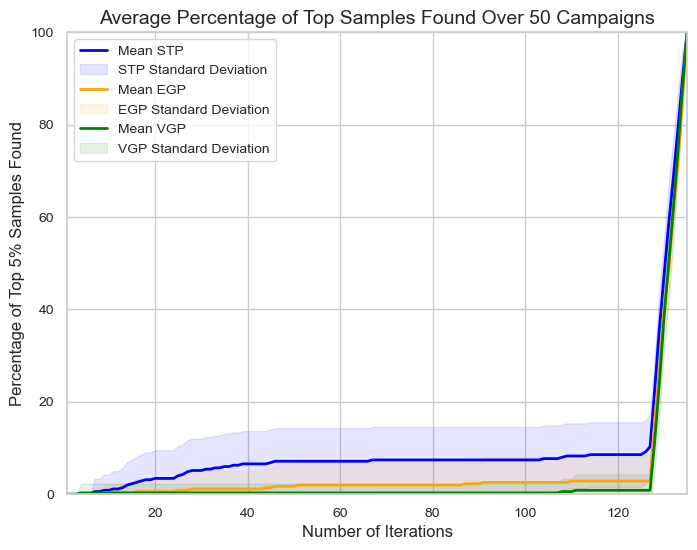

In [17]:
for element in minDatasets:

    print(f"Starting {element}")
    
    dataset = element

    data = pd.read_csv(f"datasets\{dataset}_dataset.csv")
    data = data.groupby(data.columns[-1]).mean().reset_index()
    train_x = torch.tensor(data.iloc[:, 1:].values, dtype=torch.float)
    train_y = torch.tensor(data.iloc[:, 0].values, dtype=torch.float).unsqueeze(1)

    N = len(train_x)

    # We are using prededfined candidates, so we can scale at the start
    TorchStd = TorchStandardScaler()
    TorchStd.fit(train_x)
    TorchNorm = TorchNormalizer()
    TorchNorm.fit(train_x)

    total_samples = len(train_y)

    set_seeds(42)

    n_top = int(math.ceil(N * 0.05))

    # find the top 5% of the samples
    train_y_df = pd.DataFrame(train_y.numpy(), columns=[0])
    top_samples = train_y_df.nlargest(n_top, train_y_df.columns[0], keep='first').iloc[:, 0].values.tolist()
    print(f"Number of of top 5% samples: {len(top_samples)}")
    print(f"Top 5% samples: {top_samples}")

    def TopSamplesAmnt(y, top_samples):
        return len([i for i in y if i in top_samples]) / len(top_samples)

    # Generate a list of seeds randomly picked from the range 0-1000 equal to the number of campaigns without repeating
    seedList = random.sample(range(1000), campaigns)
            
    for i in trange(len(seedList)):
        globals()['topSTP' + str(i)], globals()['iterationSTP' + str(i)] = runMinSTP(seedList[i])

    for i in trange(len(seedList)):
        globals()['topEGP' + str(i)], globals()['iterationEGP' + str(i)] = runMinEGP(seedList[i])

    for i in trange(len(seedList)):
        globals()['topVGP' + str(i)], globals()['iterationVGP' + str(i)] = runMinVGP(seedList[i])


    num_arrays = len(seedList)  
    # Function to dynamically collect arrays
    def collect_arrays(prefix, num_arrays):
        arrays = []
        for i in range(num_arrays):
            array = globals().get(f'{prefix}{i}', None)
            if array is not None:
                arrays.append(array)
        return arrays

    # Function to pad arrays with the last element to match the maximum length
    def pad_array(array, max_length):
        return np.pad(array, (0, max_length - len(array)), 'constant', constant_values=array[-1])

    def find_max_length(prefix, num_arrays):
        arrays = collect_arrays(prefix, num_arrays)
        return max(len(arr) for arr in arrays)

    # Process arrays for each type
    def process_arrays(prefix, num_arrays, max_length):
        arrays = collect_arrays(prefix, num_arrays)
        padded_arrays = [pad_array(arr, max_length) for arr in arrays]
        stack = np.stack(padded_arrays)
        mean_values = np.mean(stack, axis=0)
        std_values = np.std(stack, axis=0)
        return mean_values, std_values

    # Process arrays for STP, EGP, and VGP
    max_length_STP = find_max_length('topSTP', num_arrays)
    max_length_EGP = find_max_length('topEGP', num_arrays)
    max_length_VGP = find_max_length('topVGP', num_arrays)
    max_length = max(max_length_STP, max_length_EGP, max_length_VGP)
    mean_topSTP, std_valuesSTP = process_arrays('topSTP', num_arrays, max_length)
    mean_topEGP, std_valuesEGP = process_arrays('topEGP', num_arrays, max_length)
    mean_topVGP, std_valuesVGP = process_arrays('topVGP', num_arrays, max_length)

    # Ensure that the number of iterations matches the longest array length
    max_length = max(max_length_STP, max_length_EGP, max_length_VGP)
    iterations = np.arange(1, max_length + 1)



    sns.set(style="whitegrid")
    # Plot the mean and fill between the min and max for each type
    plt.figure(figsize=(8, 6))

    # Plot for STP
    sns.lineplot(x=iterations, y=mean_topSTP, label='Mean STP', color='blue', linewidth=2)
    plt.fill_between(iterations, mean_topSTP - std_valuesSTP, mean_topSTP + std_valuesSTP, label='STP Standard Deviation', color='blue', alpha=0.1)

    # Plot for EGP
    sns.lineplot(x=iterations, y=mean_topEGP, label='Mean EGP', color='orange', linewidth=2)
    plt.fill_between(iterations, mean_topEGP - std_valuesEGP, mean_topEGP + std_valuesEGP, label='EGP Standard Deviation', color='orange', alpha=0.1)

    # Plot for VGP
    plt.plot(iterations, mean_topVGP, label='Mean VGP', color='green', linewidth=2)
    plt.fill_between(iterations, mean_topVGP - std_valuesVGP, mean_topVGP + std_valuesVGP, label='VGP Standard Deviation', color='green', alpha=0.1)

    plt.xlabel('Number of Iterations', fontsize=12)
    plt.ylabel('Percentage of Top 5% Samples Found', fontsize=12)
    plt.title(f'Average Percentage of Top Samples Found Over {num_arrays} Campaigns', fontsize=14)
    plt.legend(fontsize=10, loc='upper left')

    # Customize ticks
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

    # Adjust axis limits and aspect ratio if needed
    plt.ylim(0, 100)
    plt.xlim(1, max_length)


    # save the plot 
    plt.savefig(f"{dataset}50Campaign50OptLoopMean")
    plt.show()